# Submission by Yashas Kumar S

# Video Classification using TimeSFormer

This notebook contains code for a video classification model for 5 classes: Long jump, Javelin throw, Skiing, Pole vault, and Horse riding respectively.

### **(Results are plotted in the cell just before the last 2 cells).**

(I thought of working with the **VideoMAE model** as well, but it seemed overly complicated for a classification task of 5 classes with only 700 training videos. So, I settled on a simpler TimeSformer model which was pretrained on the Kinetics-400 dataset.)

I analyzed the dataset containing videos from these 5 classes and plotted corresponding graphs for comprehensive data understanding.

I divided the data into **80/10/10** for training, validation, and testing respectively to ensure proper model evaluation.

I added comprehensive augmentations to the training dataset (both temporal and spatial augmentations).  The data was preprocessed by resizing frames to 224×224 pixels as required by the TimeSformer architecture to have a fair comparison between my custom implementation and the model obtained from transfer learning.

First, I implemented a custom video transformer model from scratch to establish a baseline understanding of transformer architectures for video classification. This model features:
- Frame-based CNN backbone for feature extraction
- Multi-head attention mechanism with temporal modeling
- Custom positional encoding for video sequences
- Trainable from scratch without pretrained weights

The **custom model** was trained for **80 epochs with a learning rate of 1e-3.**

This was done to help me create a benchmark to compare against a pretrained model of my choosing. This custom model has **4 Conv layers** to extract features from the frames and they are passed to** 4 encoder layers** and then finally into a classification head to make their prediction. This was a simple architecture I came up with to create the benchmark.

After setting benchmarks through the custom implementation, I loaded the pretrained **TimeSformer model** and analyzed its architecture, which consists of **12 transformer encoder layers with 768 hidden dimensions and 12 attention heads**.

The model was then trained using transfer learning - freezing all transformer layers **except the final encoder layer and the classifier**. This approach gave excellent results on both the UCF test set and YouTube videos, demonstrating strong performance through effective transfer learning and comprehensive data augmentation strategies.

Finally, I created comprehensive analysis including performance graphs, confusion matrices, and generalization analysis on real-world YouTube videos to evaluate model performance across different scenarios.

## **(Extra work done at the end!(Experimentation))**

### **Code to test the trained models on custom videos is present at the end of the notebook (last 2 cells)**

## Importing the necessary libraries

In [ ]:
import os
import cv2
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import random
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from PIL import Image
from transformers import AutoModelForVideoClassification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
from datetime import datetime
from collections import defaultdict
from google.colab import drive
from IPython.display import Video, display

## Creating a config variable where I can define all the required parameters to avoid duplication

In [ ]:
CONFIG = {
    'num_classes': 5,
    'model_save_dir': '/content/drive/MyDrive/Big_vision_task_files&folders/trained_models', # Path where all the trained models are stored
    'root_dir': '/content/drive/MyDrive/Big_vision_task_files&folders', # Defines the root directory
    'custom_lr': 1e-3, # Learning rate used to train the custom transformer based model
    'custom_batch_size': 64, # Batch size used to train the custom transformer based model
    'custom_epochs': 80, # Number of the epochs the custom transformer based model is trained for
    'model_name': "facebook/timesformer-base-finetuned-k400", # The pretrained model chosen for performing transfer learning
    'learning_rate': 1e-4, #Starting with a small lr as I am just finetuning a huge model to classify 5 classes
    'epochs': 5, # Number of epochs to finetune the TimeSformer model
    'batch_size': 4, # Batch size used during training of the TimeSformer model
    'num_frames':8 # Number of frames to be considered from a video for training (Equally spaced 8 frames are taken from the video)
}

### Reason I used only 8 frames from a video
- The original TimeSformer model was trained on videos which were not more than 10 seconds long of 25 FPS and they determined 8 equally spaced frames were more than enough to make the judgement.
- TimeSformer was also experimented with 16 frames and 32 frames, but the results were better when the number of frames taken was 8.
- The video clip length of UCF101 dataset is not more than 4 seconds and they too have clips of 25 FPS which is why I decided to stick with 8 frames only.

(I experimented with 16 and 32 frames on the UCF101 dataset as well thinking that the model would get more information to make a better judgement, but the performance decreased).

## Connecting the notebook to my google drive to access the dataset and store models and results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Create directories
os.makedirs(CONFIG['model_save_dir'], exist_ok=True)

print("Directories created successfully!")

MessageError: Error: credential propagation was unsuccessful

## Set the device to be used for running the notebook & defining the class names

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

class_names = ['HorseRiding', 'JavelinThrow', 'LongJump', 'PoleVault', 'Skiing']

Device: cuda


## Analyzing the dataset

In [ ]:
# Function to analyze the videos in the dataset:
#   -> Checks the number of frames in all videos
#   -> Checks the overall FPS of the videos
#   -> Calculates average duration of the videos
#   -> Calculates the number of videos/samples for every class to make sure the distribution is good
#   -> Calculates average duration of the videos of each class
#   -> Calculates total frames per class

def analyze_dataset_statistics(root_dir):
    """Comprehensive dataset analysis before loading"""
    print(f"{'='*80}")
    print("COMPREHENSIVE DATASET ANALYSIS")
    print(f"{'='*80}")

    if not os.path.exists(root_dir):
        print(f"Dataset directory not found: {root_dir}")
        return None

    classes = sorted(os.listdir(root_dir))
    print(f"Total classes found: {len(classes)}")
    print(f"Class names: {classes}")

    dataset_stats = {
        'total_videos': 0,
        'total_duration': 0,
        'total_frames': 0,
        'class_distribution': {},
        'video_durations': [],
        'video_frame_counts': [],
        'fps_distribution': [],
        'resolution_distribution': defaultdict(int)
    }

    video_extensions = ('.mp4', '.avi', '.mov', '.mkv', '.flv', '.webm', '.m4v')

    print(f"\nAnalyzing videos in each class:")
    print("-" * 60)
    print(f"{'Class':<15} {'Videos':<8} {'Avg Duration':<12} {'Avg Frames':<12} {'Avg FPS':<10}")
    print("-" * 60)

    for class_name in classes:
        class_dir = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        video_files = [f for f in os.listdir(class_dir) if f.lower().endswith(video_extensions)]

        class_videos = len(video_files)
        class_durations = []
        class_frames = []
        class_fps = []

        for video_file in video_files:
            video_path = os.path.join(class_dir, video_file)

            try:
                cap = cv2.VideoCapture(video_path)
                if cap.isOpened():
                    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                    fps = cap.get(cv2.CAP_PROP_FPS)
                    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                    duration = frame_count / fps if fps > 0 else 0

                    class_durations.append(duration)
                    class_frames.append(frame_count)
                    class_fps.append(fps)

                    dataset_stats['video_durations'].append(duration)
                    dataset_stats['video_frame_counts'].append(frame_count)
                    dataset_stats['fps_distribution'].append(fps)
                    dataset_stats['resolution_distribution'][f"{width}x{height}"] += 1

                cap.release()
            except Exception as e:
                print(f"    Error analyzing {video_file}: {e}")

        avg_duration = np.mean(class_durations) if class_durations else 0
        avg_frames = np.mean(class_frames) if class_frames else 0
        avg_fps = np.mean(class_fps) if class_fps else 0

        dataset_stats['class_distribution'][class_name] = {
            'count': class_videos,
            'avg_duration': avg_duration,
            'avg_frames': avg_frames,
            'avg_fps': avg_fps,
            'total_frames': sum(class_frames)
        }

        dataset_stats['total_videos'] += class_videos
        dataset_stats['total_frames'] += sum(class_frames)
        dataset_stats['total_duration'] += sum(class_durations)

        print(f"{class_name:<15} {class_videos:<8} {avg_duration:<12.1f} {avg_frames:<12.0f} {avg_fps:<10.1f}")

    print("-" * 60)
    print(f"{'TOTAL':<15} {dataset_stats['total_videos']:<8} {dataset_stats['total_duration']/dataset_stats['total_videos']:<12.1f} "
          f"{dataset_stats['total_frames']/dataset_stats['total_videos']:<12.0f} {np.mean(dataset_stats['fps_distribution']):<10.1f}")

    # Detailed statistics
    print(f"\nDETAILED DATASET STATISTICS:")
    print(f"Total videos: {dataset_stats['total_videos']}")
    print(f"Total duration: {dataset_stats['total_duration']/3600:.1f} hours ({dataset_stats['total_duration']/60:.1f} minutes)")
    print(f"Total frames: {dataset_stats['total_frames']:,}")
    print(f"Average video duration: {np.mean(dataset_stats['video_durations']):.1f} ± {np.std(dataset_stats['video_durations']):.1f} seconds")
    print(f"Average frames per video: {np.mean(dataset_stats['video_frame_counts']):.0f} ± {np.std(dataset_stats['video_frame_counts']):.0f}")
    print(f"Average FPS: {np.mean(dataset_stats['fps_distribution']):.1f} ± {np.std(dataset_stats['fps_distribution']):.1f}")

    # Resolution distribution
    print(f"\nRESOLUTION DISTRIBUTION:")
    for resolution, count in sorted(dataset_stats['resolution_distribution'].items(),
                                  key=lambda x: x[1], reverse=True):
        percentage = (count / dataset_stats['total_videos']) * 100
        print(f"  {resolution}: {count} videos ({percentage:.1f}%)")

    # Class distribution analysis
    print(f"\nCLASS BALANCE ANALYSIS:")
    min_videos = min(stats['count'] for stats in dataset_stats['class_distribution'].values())
    max_videos = max(stats['count'] for stats in dataset_stats['class_distribution'].values())
    balance_ratio = min_videos / max_videos

    print(f"Min videos per class: {min_videos}")
    print(f"Max videos per class: {max_videos}")
    print(f"Class balance ratio: {balance_ratio:.3f} (1.0 = perfectly balanced)")

    if balance_ratio < 0.5:
        print("WARNING: Significant class imbalance detected!")
    elif balance_ratio < 0.8:
        print("NOTE: Moderate class imbalance present")
    else:
        print("Dataset is reasonably balanced")

    # Create visualizations
    create_dataset_visualizations(dataset_stats)

    return dataset_stats

######### Function to plot the above calculated metrics ##########
def create_dataset_visualizations(dataset_stats):
    """Create comprehensive dataset visualization plots"""
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.hist(dataset_stats['video_durations'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Video Duration Distribution')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 3, 2)
    plt.hist(dataset_stats['video_frame_counts'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title('Frame Count Distribution')
    plt.xlabel('Number of Frames')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 3, 3)
    plt.hist(dataset_stats['fps_distribution'], bins=20, alpha=0.7, color='salmon', edgecolor='black')
    plt.title('FPS Distribution')
    plt.xlabel('Frames Per Second')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 3, 4)
    class_names = list(dataset_stats['class_distribution'].keys())
    class_counts = [dataset_stats['class_distribution'][cls]['count'] for cls in class_names]
    plt.bar(class_names, class_counts, color='lightcoral', alpha=0.7)
    plt.title('Videos per Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Videos')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 3, 5)
    avg_durations = [dataset_stats['class_distribution'][cls]['avg_duration'] for cls in class_names]
    plt.bar(class_names, avg_durations, color='gold', alpha=0.7)
    plt.title('Average Duration per Class')
    plt.xlabel('Class')
    plt.ylabel('Average Duration (seconds)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 3, 6)
    total_frames_per_class = [dataset_stats['class_distribution'][cls]['total_frames'] for cls in class_names]
    plt.bar(class_names, total_frames_per_class, color='mediumpurple', alpha=0.7)
    plt.title('Total Frames per Class')
    plt.xlabel('Class')
    plt.ylabel('Total Frames')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    plt.show()

ANALYZING DATASET
COMPREHENSIVE DATASET ANALYSIS
Total classes found: 5
Class names: ['HorseRiding', 'JavelinThrow', 'LongJump', 'PoleVault', 'Skiing']

Analyzing videos in each class:
------------------------------------------------------------
Class           Videos   Avg Duration Avg Frames   Avg FPS   
------------------------------------------------------------
HorseRiding     164      6.4          191          30.0      
JavelinThrow    117      4.1          101          25.0      
LongJump        131      5.3          133          25.0      
PoleVault       149      5.6          169          30.0      
Skiing          135      8.6          216          25.0      
------------------------------------------------------------
TOTAL           696      6.1          165          27.2      

DETAILED DATASET STATISTICS:
Total videos: 696
Total duration: 1.2 hours (70.4 minutes)
Total frames: 114,973
Average video duration: 6.1 ± 2.3 seconds
Average frames per video: 165 ± 62
Average FP

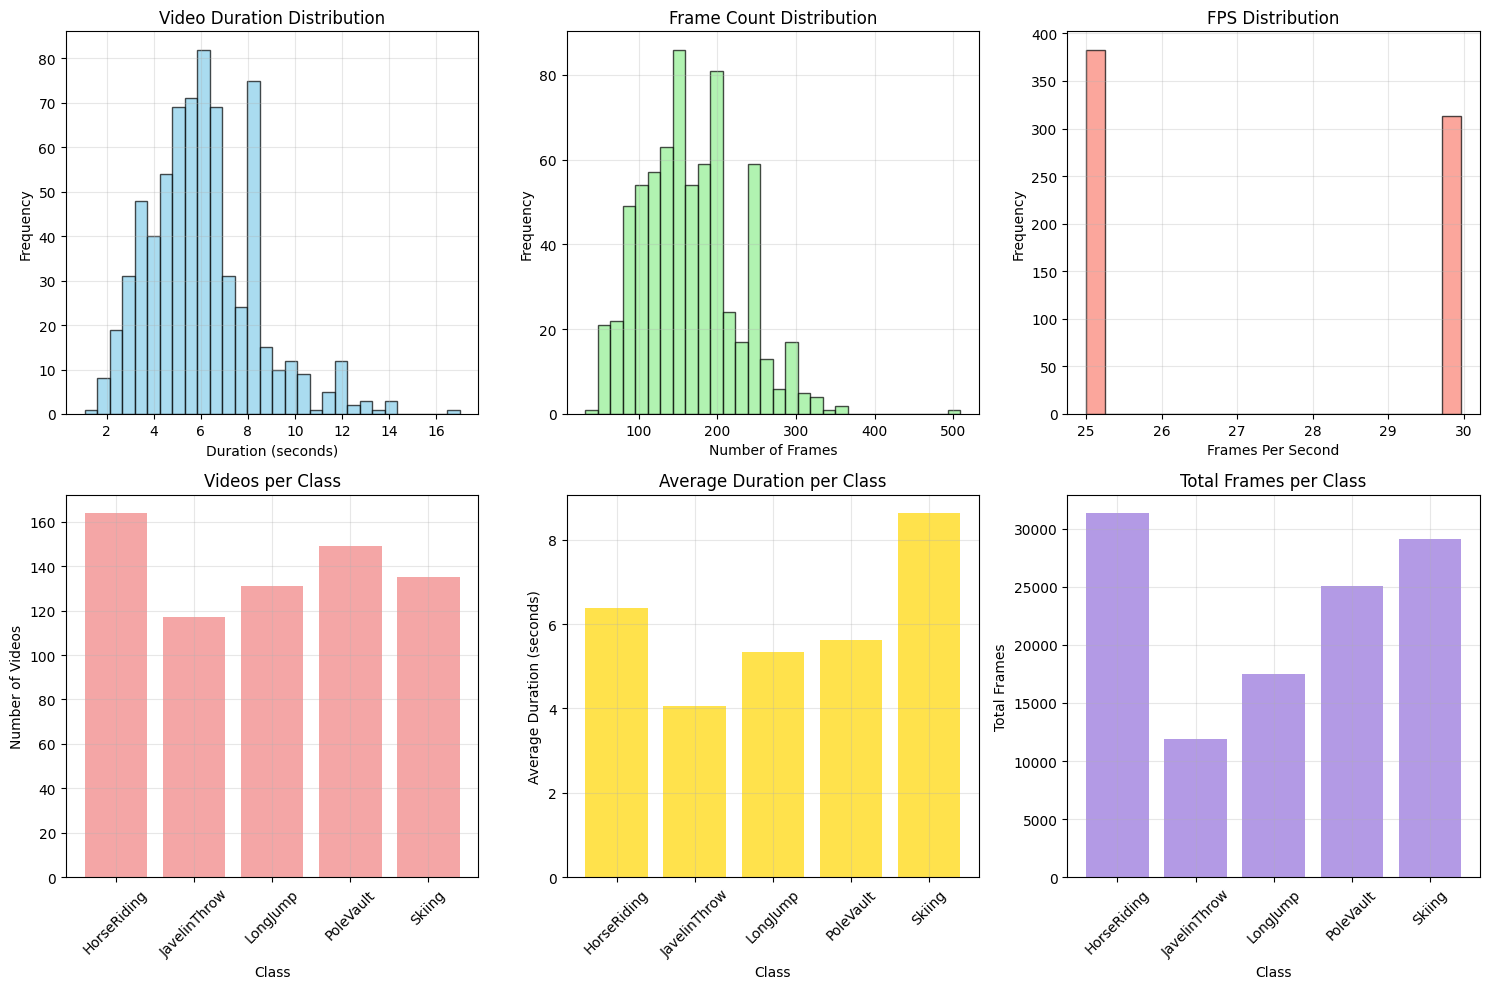


DATASET ANALYSIS COMPLETE - Proceeding to benchmark


In [ ]:
# Dataset configuration
root_folder = "/content/drive/MyDrive/Big_vision_task_files&folders/UCF-101"

# COMPREHENSIVE DATASET ANALYSIS
print("ANALYZING DATASET")
dataset_stats = analyze_dataset_statistics(root_folder)

print(f"\n{'='*60}")
print("DATASET ANALYSIS COMPLETE - Proceeding to benchmark")
print(f"{'='*60}")

## Created the dataset class which basically helps with loading the data that I can use as input to my model.

This has instructions to perform both spatial and temporal augmentations to the input videos.

- Spatial augmentations:
  Playing with the noise component, brightness of the frames, contrast of the frames, etc.

- Temporal augmentations:
  Slowing down the videos, Frame dropping, reversing the video, etc.


In [ ]:
class VideoDataset(Dataset):
    def __init__(self, root_dir, num_frames=8, transform=None, augment=True):
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.transform = transform
        self.augment = augment
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []

        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for vf in os.listdir(cls_dir):
                if vf.lower().endswith(('.mp4','.avi','.mov','.mkv')):
                    self.samples.append((os.path.join(cls_dir, vf), self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def _temporal_augmentation(self, frames):
        """Temporal augmentations for video frames"""
        if not self.augment or random.random() > 0.7:
            return frames

        aug_type = random.choice(['speed_up', 'slow_down', 'reverse', 'frame_drop', 'frame_repeat'])

        if aug_type == 'speed_up':
            return frames[::2] if len(frames) > self.num_frames else frames
        elif aug_type == 'slow_down':
            slow_frames = []
            for frame in frames:
                slow_frames.extend([frame, frame])
            return slow_frames[:len(frames)]
        elif aug_type == 'reverse':
            return frames[::-1]
        elif aug_type == 'frame_drop':
            keep_indices = sorted(random.sample(range(len(frames)), int(0.8 * len(frames))))
            return [frames[i] for i in keep_indices]
        elif aug_type == 'frame_repeat':
            repeated = []
            for frame in frames:
                repeated.append(frame)
                if random.random() < 0.3:
                    repeated.append(frame)
            return repeated[:len(frames)]

        return frames

    def _spatial_augmentation(self, frame):
        """Spatial augmentations applied to individual frames"""
        if not self.augment or random.random() > 0.6:
            return frame

        # Apply multiple augmentations with different probabilities
        augmented_frame = frame.copy()

        # Color augmentations
        if random.random() > 0.5:
            # Brightness
            brightness_factor = random.uniform(0.8, 1.2)
            augmented_frame = cv2.convertScaleAbs(augmented_frame, alpha=brightness_factor, beta=0)

        if random.random() > 0.5:
            # Contrast
            contrast_factor = random.uniform(0.8, 1.2)
            augmented_frame = cv2.convertScaleAbs(augmented_frame, alpha=contrast_factor, beta=0)

        # Noise augmentation
        if random.random() > 0.7:
            noise = np.random.normal(0, 5, augmented_frame.shape).astype(np.uint8)
            augmented_frame = cv2.add(augmented_frame, noise)

        # Blur augmentation
        if random.random() > 0.8:
            kernel_size = random.choice([3, 5])
            augmented_frame = cv2.GaussianBlur(augmented_frame, (kernel_size, kernel_size), 0)

        # Color saturation
        if random.random() > 0.7:
            hsv = cv2.cvtColor(augmented_frame, cv2.COLOR_RGB2HSV)
            saturation_factor = random.uniform(0.8, 1.2)
            hsv[:,:,1] = np.clip(hsv[:,:,1] * saturation_factor, 0, 255)
            augmented_frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

        return augmented_frame

    def _extract_frames_with_augmentation(self, video_path):
        """Extract frames with temporal sampling augmentation"""
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        total_frames = max(total_frames, 1)

        # Temporal sampling with augmentation
        if self.augment and random.random() > 0.5:
            window_start = random.randint(0, max(0, total_frames - int(1.5 * self.num_frames)))
            window_end = min(window_start + int(1.5 * self.num_frames), total_frames)
            sample_frames = max(self.num_frames, window_end - window_start)
            indices = np.linspace(window_start, window_end - 1, sample_frames).astype(int)
        else:
            indices = np.linspace(0, total_frames - 1, self.num_frames).astype(int)

        # Extract frames
        frames = []
        i = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if i in indices:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            i += 1
        cap.release()

        # Pad if needed
        while len(frames) < self.num_frames:
            if frames:
                frames.append(frames[-1])
            else:
                frames.append(np.zeros((224, 224, 3), dtype=np.uint8))

        # Apply temporal augmentations
        frames = self._temporal_augmentation(frames)

        # Apply spatial augmentations to each frame individually
        if self.augment:
            frames = [self._spatial_augmentation(frame) for frame in frames]

        # Ensure we have exactly num_frames
        if len(frames) > self.num_frames:
            indices = np.linspace(0, len(frames) - 1, self.num_frames).astype(int)
            frames = [frames[i] for i in indices]
        elif len(frames) < self.num_frames:
            while len(frames) < self.num_frames:
                frames.append(frames[-1])

        return frames

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        frames = self._extract_frames_with_augmentation(path)

        # Convert to PIL Images and apply transforms
        frames_tensor = []
        for frame in frames:
            pil_frame = Image.fromarray(frame)

            # Additional per-frame geometric augmentations during training
            if self.augment and random.random() > 0.7:
                if random.random() > 0.5:
                    angle = random.uniform(-15, 15)
                    pil_frame = TF.rotate(pil_frame, angle)
                if random.random() > 0.5:
                    pil_frame = TF.hflip(pil_frame)
                if random.random() > 0.8:
                    # Random crop and resize
                    i, j, h, w = transforms.RandomResizedCrop.get_params(
                        pil_frame, scale=(0.8, 1.0), ratio=(0.75, 1.33)
                    )
                    pil_frame = TF.crop(pil_frame, i, j, h, w)
                    pil_frame = TF.resize(pil_frame, (224, 224))

            # Apply transform if provided
            if self.transform:
                transformed = self.transform(pil_frame)
            else:
                transformed = transforms.ToTensor()(pil_frame)

            frames_tensor.append(transformed)

        video_tensor = torch.stack(frames_tensor, dim=0)

        # Mixup augmentation at tensor level
        if self.augment and random.random() > 0.9:
            same_class_samples = [s for s in self.samples if s[1] == label and s[0] != path]
            if same_class_samples:
                mix_path, _ = random.choice(same_class_samples)
                mix_frames = self._extract_frames_with_augmentation(mix_path)
                mix_tensor_frames = []
                for frame in mix_frames:
                    pil_frame = Image.fromarray(frame)
                    if self.transform:
                        transformed = self.transform(pil_frame)
                    else:
                        transformed = transforms.ToTensor()(pil_frame)
                    mix_tensor_frames.append(transformed)

                mix_tensor = torch.stack(mix_tensor_frames)

                alpha = random.uniform(0.2, 0.8)
                video_tensor = alpha * video_tensor + (1 - alpha) * mix_tensor

        return video_tensor, label

# Gives detailed analysis of the data loaded for training, testing and validation

In [ ]:
# FIXED DATA LOADER CREATION
def get_data_loaders_with_analysis(root_dir, batch_size=CONFIG['batch_size'], num_frames=8, seed=42):
    """Enhanced data loaders with detailed split analysis - FIXED VERSION"""
    print(f"\n{'='*80}")
    print("CREATING DATA LOADERS WITH DETAILED ANALYSIS")
    print(f"{'='*80}")

    # Transformations
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Create base dataset ONLY for getting sample paths and labels
    base_dataset = VideoDataset(root_dir, num_frames=num_frames, transform=None, augment=False)
    total = len(base_dataset)
    train_size = int(0.8 * total)  # 80% training
    val_size = int(0.1 * total)    # 10% validation
    test_size = total - train_size - val_size  # 10% testing

    print(f"Total dataset size: {total} videos")
    print(f"Train split: {train_size} videos ({train_size/total*100:.1f}%)")
    print(f"Validation split: {val_size} videos ({val_size/total*100:.1f}%)")
    print(f"Test split: {test_size} videos ({test_size/total*100:.1f}%)")

    # Split indices
    indices = list(range(total))
    random.seed(seed)
    random.shuffle(indices)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    # Analyze class distribution in each split
    print(f"\nCLASS DISTRIBUTION ANALYSIS:")
    class_names = base_dataset.classes

    def analyze_split_distribution(indices, split_name):
        class_counts = defaultdict(int)
        for idx in indices:
            _, label = base_dataset.samples[idx]
            class_name = class_names[label]
            class_counts[class_name] += 1

        print(f"\n{split_name} set distribution:")
        print("-" * 40)
        for class_name in class_names:
            count = class_counts[class_name]
            percentage = (count / len(indices)) * 100
            print(f"  {class_name:<15}: {count:>3} videos ({percentage:>5.1f}%)")

        return dict(class_counts)

    train_dist = analyze_split_distribution(train_indices, "Training")
    val_dist = analyze_split_distribution(val_indices, "Validation")
    test_dist = analyze_split_distribution(test_indices, "Test")

    # Create CUSTOM dataset subsets with proper augmentation handling
    class CustomVideoSubset(Dataset):
        def __init__(self, base_dataset, indices, transform, augment):
            self.base_dataset = base_dataset
            self.indices = indices
            self.samples = [base_dataset.samples[i] for i in indices]

            # Create new dataset instance with proper augmentation settings
            self.dataset = VideoDataset(
                base_dataset.root_dir,
                base_dataset.num_frames,
                transform,
                augment
            )
            # Override samples to only include this subset
            self.dataset.samples = self.samples

        def __len__(self):
            return len(self.indices)

        def __getitem__(self, idx):
            # Get the actual sample index in the subset
            return self.dataset.__getitem__(idx)

    # Create subset datasets with proper augmentation control
    train_dataset = CustomVideoSubset(base_dataset, train_indices, train_transform, augment=True)
    val_dataset = CustomVideoSubset(base_dataset, val_indices, val_test_transform, augment=False)
    test_dataset = CustomVideoSubset(base_dataset, test_indices, val_test_transform, augment=False)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

    print(f"\nDATA LOADER SPECIFICATIONS:")
    print(f"Batch size: {batch_size}")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")
    print(f"Training augmentations: {'ENABLED' if train_dataset.dataset.augment else 'DISABLED'}")
    print(f"Validation/Test augmentations: {'ENABLED' if val_dataset.dataset.augment else 'DISABLED'}")

    # Visualize split distribution
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    splits = [('Training', train_dist), ('Validation', val_dist), ('Test', test_dist)]
    colors = ['skyblue', 'lightgreen', 'salmon']

    for idx, (split_name, distribution) in enumerate(splits):
        classes = list(distribution.keys())
        counts = list(distribution.values())

        axes[idx].bar(classes, counts, color=colors[idx], alpha=0.7, edgecolor='black')
        axes[idx].set_title(f'{split_name} Set Distribution')
        axes[idx].set_xlabel('Class')
        axes[idx].set_ylabel('Number of Videos')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3)

        # Add count labels on bars
        for i, count in enumerate(counts):
            axes[idx].text(i, count + 0.5, str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return train_loader, val_loader, test_loader, {
        'train_distribution': train_dist,
        'val_distribution': val_dist,
        'test_distribution': test_dist,
        'total_videos': total,
        'class_names': class_names
    }

### Defines focal loss which is the loss function I have decided to use for the classification task. Even though the class distribution is quite balanced, it would not hurt to have a self-balancing loss function. If there is no bias, then it just acts like a CCE loss.

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        logp = -self.ce_loss(inputs, targets)
        p = torch.exp(logp)
        loss = -((1 - p) ** self.gamma) * self.alpha * logp
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# Declares all the functions required to plot all kinds of graphs required to display and save during training of a model.

Graphs of validation loss, training loss, F1 score, precision, recall, accuracy are defined.

# This cell also has both the evaluation and training functions required for the model to perform training and validation.

Finally, a confusion matrix is also plotted for the test set.

In [ ]:
class TrainingVisualizer:
    """Comprehensive training visualization and logging"""

    def __init__(self):

        # Training history
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.val_f1_scores = []
        self.val_precisions = []
        self.val_recalls = []

    def log_training_step(self, epoch, batch_idx, loss):
        """Log training step"""
        self.train_losses.append(loss)

    def log_validation_step(self, epoch, val_loss, val_acc, val_f1, val_precision, val_recall):
        """Log validation step"""
        self.val_losses.append(val_loss)
        self.val_accuracies.append(val_acc)
        self.val_f1_scores.append(val_f1)
        self.val_precisions.append(val_precision)
        self.val_recalls.append(val_recall)

    def plot_training_history(self):
        """Create comprehensive training plots"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Training and validation loss
        axes[0, 0].plot(self.train_losses, label='Training Loss', alpha=0.7)
        axes[0, 0].plot(range(0, len(self.train_losses), len(self.train_losses)//len(self.val_losses)),
                       self.val_losses, label='Validation Loss', marker='o')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Batch/Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Validation accuracy
        axes[0, 1].plot(self.val_accuracies, 'g-o', label='Validation Accuracy')
        axes[0, 1].set_title('Validation Accuracy Over Epochs')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Validation F1 score
        axes[0, 2].plot(self.val_f1_scores, 'b-o', label='Validation F1 Score')
        axes[0, 2].set_title('Validation F1 Score Over Epochs')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('F1 Score')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)

        # Validation precision
        axes[1, 0].plot(self.val_precisions, 'r-o', label='Validation Precision')
        axes[1, 0].set_title('Validation Precision Over Epochs')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Validation recall
        axes[1, 1].plot(self.val_recalls, 'm-o', label='Validation Recall')
        axes[1, 1].set_title('Validation Recall Over Epochs')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        # Combined metrics
        axes[1, 2].plot(self.val_accuracies, 'g-o', label='Accuracy', alpha=0.7)
        axes[1, 2].plot(self.val_f1_scores, 'b-o', label='F1 Score', alpha=0.7)
        axes[1, 2].plot(self.val_precisions, 'r-o', label='Precision', alpha=0.7)
        axes[1, 2].plot(self.val_recalls, 'm-o', label='Recall', alpha=0.7)
        axes[1, 2].set_title('All Validation Metrics')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Score')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

@torch.no_grad()
def evaluate_with_details_universal(model, dataloader, device, class_names=None, phase="Validation", is_timesformer=True):
    """Enhanced evaluation with detailed metrics - works for both TimeSformer and custom models"""
    model.eval()
    preds, labels_all = [], []
    total_loss = 0
    criterion = FocalLoss()

    for videos, labels in dataloader:
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        if is_timesformer:
            # TimeSformer format
            outputs = model(pixel_values=videos)
            loss = criterion(outputs.logits, labels)
            pred = outputs.logits.argmax(dim=1)
        else:
            # Custom model format
            outputs = model(videos)
            loss = criterion(outputs, labels)
            pred = outputs.argmax(dim=1)

        total_loss += loss.item()
        preds.extend(pred.cpu().numpy())
        labels_all.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(labels_all, preds)
    f1 = f1_score(labels_all, preds, average="weighted")
    precision = precision_score(labels_all, preds, average='weighted')
    recall = recall_score(labels_all, preds, average='weighted')
    avg_loss = total_loss / len(dataloader)

    if class_names and phase == "Testing":
        print(f"\n{'='*60}")
        print(f"DETAILED {phase.upper()} RESULTS")
        print(f"{'='*60}")

        # Classification report
        report = classification_report(labels_all, preds, target_names=class_names, digits=4)
        print(report)

        print(f"\nOVERALL METRICS:")
        print(f"Accuracy:           {accuracy:.4f}")
        print(f"Precision (weighted): {precision:.4f}")
        print(f"Recall (weighted):    {recall:.4f}")
        print(f"F1-Score (weighted):  {f1:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(labels_all, preds)
        print(f"\nCONFUSION MATRIX:")
        print("="*30)

        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        print(cm_df)

        # Save confusion matrix plot
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - {phase}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Detailed predictions display
        print(f"\nDETAILED PREDICTIONS:")
        print(f"{'Sample':<8} {'True':<12} {'Predicted':<12} {'Correct':<8}")
        print("-" * 45)

        for i, (true_label, pred_label) in enumerate(zip(labels_all[:20], preds[:20])):  # Show first 20
            true_class = class_names[true_label]
            pred_class = class_names[pred_label]
            correct = "Yes" if true_label == pred_label else "No"
            print(f"{i+1:<8} {true_class:<12} {pred_class:<12} {correct:<8}")

    return avg_loss, accuracy, f1, precision, recall

def train_with_visualization_universal(model, train_loader, val_loader, device, epochs=CONFIG['epochs'], lr=CONFIG['learning_rate'], is_timesformer=True):
    """Enhanced training with comprehensive visualization - works for both TimeSformer and custom models"""
    visualizer = TrainingVisualizer()

    model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = FocalLoss()

    print(f"\nStarting training for {epochs} epochs...")
    print(f"Learning rate: {lr}")
    print(f"Loss function: Focal Loss")
    print(f"Model type: {'TimeSformer' if is_timesformer else 'Custom Video Transformer'}")

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        batch_count = 0

        for i, (videos, labels) in enumerate(train_loader):
            videos = videos.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            if is_timesformer:
                # TimeSformer format
                outputs = model(pixel_values=videos)
                loss = criterion(outputs.logits, labels)
            else:
                # Custom model format
                outputs = model(videos)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_count += 1

            # Log training step
            visualizer.log_training_step(epoch, i, loss.item())

            if i % 10 == 9:
                print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}, Loss: {running_loss/10:.4f}")
                running_loss = 0

        # Validation
        val_loss, val_acc, val_f1, val_precision, val_recall = evaluate_with_details_universal(
            model, val_loader, device, phase="Validation", is_timesformer=is_timesformer
        )

        # Log validation step
        visualizer.log_validation_step(epoch, val_loss, val_acc, val_f1, val_precision, val_recall)

        print(f"Epoch {epoch+1}/{epochs} - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

    # Plot training history
    visualizer.plot_training_history()

    return visualizer

# Custom implementation of a transformer architecture for video classification

- This consists of 4 convolution layers which are used to extract features from the frames which are then passed to an average pooling layer to flatten it, and positional embeddings are calculated for these frames and then it is passed to a transformer encoder architecture which consists of 4 encoder layers and 8 attention heads.

- Input shape is similar to that of TimeSformer model - [batch_size, num_frames, channels, width, height]
- Output shape - [batch_size, num_classes]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class SimpleVideoTransformer(nn.Module):
    """Simple frame-based video transformer - much cleaner and more effective"""

    def __init__(self, num_classes=5, num_frames=8, d_model=256, nhead=8, num_layers=4, dropout_rate=0.1):
        super(SimpleVideoTransformer, self).__init__()

        self.num_frames = num_frames
        self.d_model = d_model

        # Simple CNN backbone to extract frame features
        self.cnn_backbone = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, 7, 2, 3),  # 224->112
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1),      # 112->56

            # Second conv block
            nn.Conv2d(32, 64, 5, 2, 2), # 56->28
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Third conv block
            nn.Conv2d(64, 128, 3, 2, 1), # 28->14
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Fourth conv block
            nn.Conv2d(128, 256, 3, 2, 1), # 14->7
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Global average pooling
            nn.AdaptiveAvgPool2d(1)  # 7x7 -> 1x1
        )

        # Project CNN features to transformer dimension
        self.feature_proj = nn.Linear(256, d_model)

        # Learnable positional embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, num_frames, d_model) * 0.02)

        # Class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 2,  # Smaller feedforward
            dropout=dropout_rate,
            activation='gelu',
            batch_first=True,
            norm_first=True  # Pre-norm for better training
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Simple classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(dropout_rate),
            nn.Linear(d_model, num_classes)
        )

        # Initialize weights properly
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.LayerNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        batch_size, num_frames, channels, height, width = x.size()

        # Extract features for each frame
        frame_features = []
        for i in range(num_frames):
            frame = x[:, i]  # [batch, 3, 224, 224]
            features = self.cnn_backbone(frame)  # [batch, 256, 1, 1]
            features = features.flatten(1)  # [batch, 256]
            frame_features.append(features)

        x = torch.stack(frame_features, dim=1)

        # Project to transformer dimension: [batch, num_frames, d_model]
        x = self.feature_proj(x)

        # Add positional embeddings
        x = x + self.pos_embedding

        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [batch, 1, d_model]
        x = torch.cat([cls_tokens, x], dim=1)  # [batch, num_frames+1, d_model]

        # Apply transformer
        x = self.transformer(x)

        # Use class token for classification
        cls_output = x[:, 0]  # [batch, d_model]

        # Classification
        output = self.classifier(cls_output)

        return output

def load_simple_video_transformer(num_classes=5, num_frames=8):
    """Load simple video transformer model"""

    print(f"\n{'='*80}")
    print("LOADING SIMPLE VIDEO TRANSFORMER MODEL")
    print(f"{'='*80}")

    model = SimpleVideoTransformer(
        num_classes=num_classes,
        num_frames=num_frames,
        d_model=256,        # Smaller dimension
        nhead=8,           # 8 heads
        num_layers=4,      # Only 4 layers
        dropout_rate=0.1
    )

    # Calculate model parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Model type: Simple Frame-based Video Transformer")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB")

    print(f"\nMODEL ARCHITECTURE DETAILS:")
    print(f"- CNN backbone: 4 conv blocks + global pooling")
    print(f"- Frame feature dim: 256")
    print(f"- Transformer dim: 256")
    print(f"- Attention heads: 8")
    print(f"- Encoder layers: 4")
    print(f"- Uses class token for classification")
    print(f"- Input shape: [batch_size, {num_frames}, 3, 224, 224]")
    print(f"- Output shape: [batch_size, {num_classes}]")

    return model

## Load the data loaders


CREATING DATA LOADERS WITH DETAILED ANALYSIS
Total dataset size: 696 videos
Train split: 556 videos (79.9%)
Validation split: 69 videos (9.9%)
Test split: 71 videos (10.2%)

CLASS DISTRIBUTION ANALYSIS:

Training set distribution:
----------------------------------------
  HorseRiding    : 129 videos ( 23.2%)
  JavelinThrow   :  91 videos ( 16.4%)
  LongJump       : 108 videos ( 19.4%)
  PoleVault      : 128 videos ( 23.0%)
  Skiing         : 100 videos ( 18.0%)

Validation set distribution:
----------------------------------------
  HorseRiding    :  14 videos ( 20.3%)
  JavelinThrow   :  15 videos ( 21.7%)
  LongJump       :   9 videos ( 13.0%)
  PoleVault      :  13 videos ( 18.8%)
  Skiing         :  18 videos ( 26.1%)

Test set distribution:
----------------------------------------
  HorseRiding    :  21 videos ( 29.6%)
  JavelinThrow   :  11 videos ( 15.5%)
  LongJump       :  14 videos ( 19.7%)
  PoleVault      :   8 videos ( 11.3%)
  Skiing         :  17 videos ( 23.9%)

DATA 

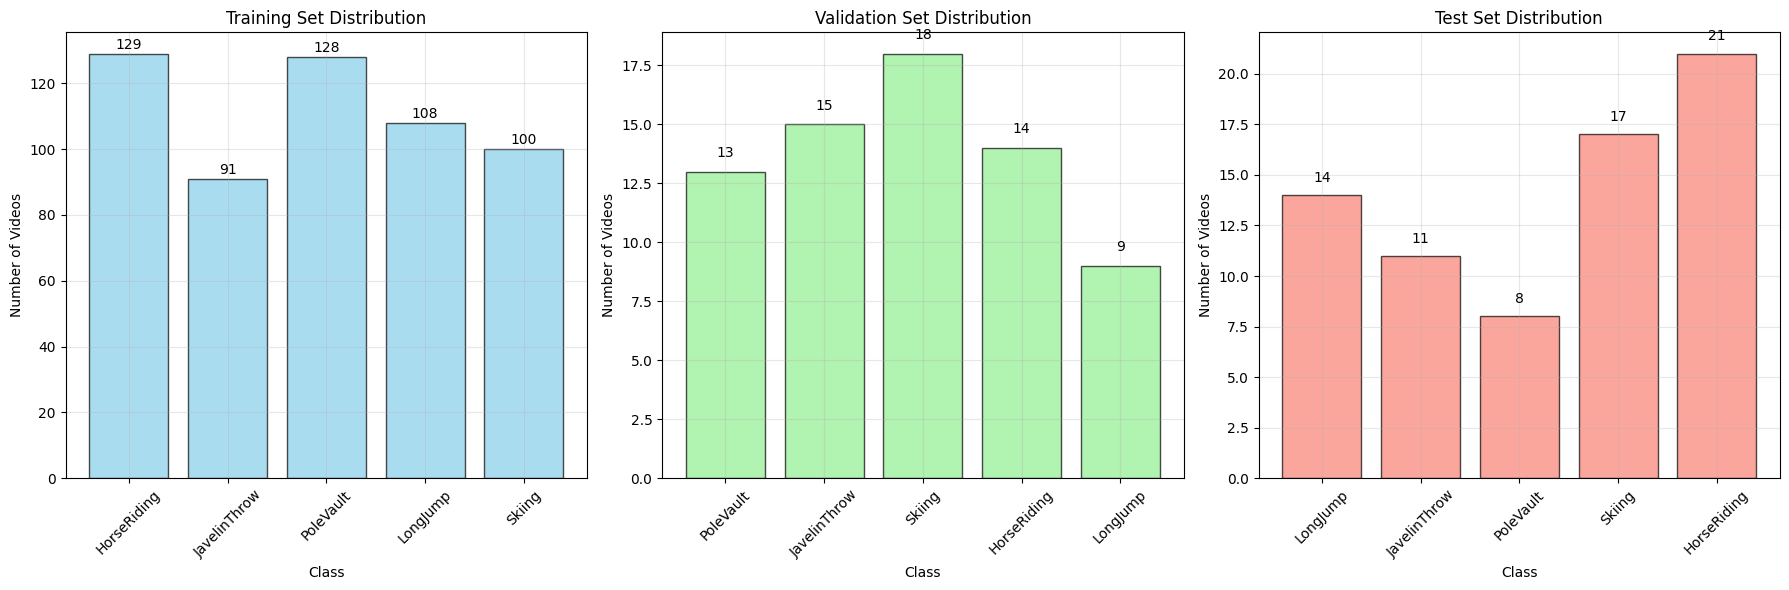

In [ ]:
# Load data loaders once
train_loader, val_loader, test_loader, split_info = get_data_loaders_with_analysis(
    root_folder, batch_size=CONFIG['custom_batch_size'], num_frames=CONFIG['num_frames']
)

# Training & evaluating the custom model (Scroll till the end of the output to see plots & test results)


LOADING SIMPLE VIDEO TRANSFORMER MODEL
Model type: Simple Frame-based Video Transformer
Total parameters: 2,604,293
Trainable parameters: 2,604,293
Model size: ~9.9 MB

MODEL ARCHITECTURE DETAILS:
- CNN backbone: 4 conv blocks + global pooling
- Frame feature dim: 256
- Transformer dim: 256
- Attention heads: 8
- Encoder layers: 4
- Uses class token for classification
- Input shape: [batch_size, 8, 3, 224, 224]
- Output shape: [batch_size, 5]


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


TRAINING CUSTOM VIDEO TRANSFORMER

Starting training for 80 epochs...
Learning rate: 0.001
Loss function: Focal Loss
Model type: Custom Video Transformer
Epoch 1/80, Batch 10, Loss: 0.3812
Epoch 1/80, Batch 20, Loss: 0.3216
Epoch 1/80, Batch 30, Loss: 0.2812
Epoch 1/80, Batch 40, Loss: 0.2745
Epoch 1/80, Batch 50, Loss: 0.2847
Epoch 1/80, Batch 60, Loss: 0.3068
Epoch 1/80, Batch 70, Loss: 0.2532
Epoch 1/80, Batch 80, Loss: 0.2708
Epoch 1/80, Batch 90, Loss: 0.2601
Epoch 1/80, Batch 100, Loss: 0.2858
Epoch 1/80, Batch 110, Loss: 0.2552
Epoch 1/80, Batch 120, Loss: 0.2904
Epoch 1/80, Batch 130, Loss: 0.2587
Epoch 1/80 - Val Loss: 0.2485, Val Acc: 0.2319, Val F1: 0.1745


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/80, Batch 10, Loss: 0.2587
Epoch 2/80, Batch 20, Loss: 0.2754
Epoch 2/80, Batch 30, Loss: 0.2376
Epoch 2/80, Batch 40, Loss: 0.2863
Epoch 2/80, Batch 50, Loss: 0.2697
Epoch 2/80, Batch 60, Loss: 0.2598
Epoch 2/80, Batch 70, Loss: 0.2245
Epoch 2/80, Batch 80, Loss: 0.2319
Epoch 2/80, Batch 90, Loss: 0.2921
Epoch 2/80, Batch 100, Loss: 0.2634
Epoch 2/80, Batch 110, Loss: 0.2727
Epoch 2/80, Batch 120, Loss: 0.2554
Epoch 2/80, Batch 130, Loss: 0.2549
Epoch 2/80 - Val Loss: 0.2663, Val Acc: 0.1884, Val F1: 0.0597


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/80, Batch 10, Loss: 0.2894
Epoch 3/80, Batch 20, Loss: 0.2812
Epoch 3/80, Batch 30, Loss: 0.2561
Epoch 3/80, Batch 40, Loss: 0.2570
Epoch 3/80, Batch 50, Loss: 0.2494
Epoch 3/80, Batch 60, Loss: 0.2804
Epoch 3/80, Batch 70, Loss: 0.2907
Epoch 3/80, Batch 80, Loss: 0.2763
Epoch 3/80, Batch 90, Loss: 0.2696
Epoch 3/80, Batch 100, Loss: 0.2649
Epoch 3/80, Batch 110, Loss: 0.2573
Epoch 3/80, Batch 120, Loss: 0.2748
Epoch 3/80, Batch 130, Loss: 0.2845
Epoch 3/80 - Val Loss: 0.2606, Val Acc: 0.2319, Val F1: 0.1326


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/80, Batch 10, Loss: 0.2743
Epoch 4/80, Batch 20, Loss: 0.2646
Epoch 4/80, Batch 30, Loss: 0.2551
Epoch 4/80, Batch 40, Loss: 0.2591
Epoch 4/80, Batch 50, Loss: 0.2594
Epoch 4/80, Batch 60, Loss: 0.2605
Epoch 4/80, Batch 70, Loss: 0.2836
Epoch 4/80, Batch 80, Loss: 0.2647
Epoch 4/80, Batch 90, Loss: 0.2712
Epoch 4/80, Batch 100, Loss: 0.2602
Epoch 4/80, Batch 110, Loss: 0.2699
Epoch 4/80, Batch 120, Loss: 0.2718
Epoch 4/80, Batch 130, Loss: 0.2589
Epoch 4/80 - Val Loss: 0.2704, Val Acc: 0.1884, Val F1: 0.0597


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/80, Batch 10, Loss: 0.2663
Epoch 5/80, Batch 20, Loss: 0.2524
Epoch 5/80, Batch 30, Loss: 0.2572
Epoch 5/80, Batch 40, Loss: 0.2743
Epoch 5/80, Batch 50, Loss: 0.2496
Epoch 5/80, Batch 60, Loss: 0.2570
Epoch 5/80, Batch 70, Loss: 0.2586
Epoch 5/80, Batch 80, Loss: 0.2443
Epoch 5/80, Batch 90, Loss: 0.2276
Epoch 5/80, Batch 100, Loss: 0.2731
Epoch 5/80, Batch 110, Loss: 0.2438
Epoch 5/80, Batch 120, Loss: 0.2797
Epoch 5/80, Batch 130, Loss: 0.2500
Epoch 5/80 - Val Loss: 0.2429, Val Acc: 0.1884, Val F1: 0.0597


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/80, Batch 10, Loss: 0.2294
Epoch 6/80, Batch 20, Loss: 0.2705
Epoch 6/80, Batch 30, Loss: 0.2656
Epoch 6/80, Batch 40, Loss: 0.2503
Epoch 6/80, Batch 50, Loss: 0.2498
Epoch 6/80, Batch 60, Loss: 0.2456
Epoch 6/80, Batch 70, Loss: 0.2718
Epoch 6/80, Batch 80, Loss: 0.2457
Epoch 6/80, Batch 90, Loss: 0.2590
Epoch 6/80, Batch 100, Loss: 0.2394
Epoch 6/80, Batch 110, Loss: 0.2716
Epoch 6/80, Batch 120, Loss: 0.2618
Epoch 6/80, Batch 130, Loss: 0.2571
Epoch 6/80 - Val Loss: 0.2487, Val Acc: 0.2609, Val F1: 0.1278


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/80, Batch 10, Loss: 0.2625
Epoch 7/80, Batch 20, Loss: 0.2548
Epoch 7/80, Batch 30, Loss: 0.2443
Epoch 7/80, Batch 40, Loss: 0.2310
Epoch 7/80, Batch 50, Loss: 0.2555
Epoch 7/80, Batch 60, Loss: 0.2477
Epoch 7/80, Batch 70, Loss: 0.2609
Epoch 7/80, Batch 80, Loss: 0.2706
Epoch 7/80, Batch 90, Loss: 0.2575
Epoch 7/80, Batch 100, Loss: 0.2583
Epoch 7/80, Batch 110, Loss: 0.2396
Epoch 7/80, Batch 120, Loss: 0.2201
Epoch 7/80, Batch 130, Loss: 0.2322
Epoch 7/80 - Val Loss: 0.2176, Val Acc: 0.3043, Val F1: 0.2185


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/80, Batch 10, Loss: 0.2515
Epoch 8/80, Batch 20, Loss: 0.2566
Epoch 8/80, Batch 30, Loss: 0.2955
Epoch 8/80, Batch 40, Loss: 0.2481
Epoch 8/80, Batch 50, Loss: 0.2573
Epoch 8/80, Batch 60, Loss: 0.2519
Epoch 8/80, Batch 70, Loss: 0.2356
Epoch 8/80, Batch 80, Loss: 0.2501
Epoch 8/80, Batch 90, Loss: 0.2309
Epoch 8/80, Batch 100, Loss: 0.2323
Epoch 8/80, Batch 110, Loss: 0.2403
Epoch 8/80, Batch 120, Loss: 0.2206
Epoch 8/80, Batch 130, Loss: 0.2496
Epoch 8/80 - Val Loss: 0.2242, Val Acc: 0.1884, Val F1: 0.0597


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/80, Batch 10, Loss: 0.2277
Epoch 9/80, Batch 20, Loss: 0.2240
Epoch 9/80, Batch 30, Loss: 0.2871
Epoch 9/80, Batch 40, Loss: 0.2766
Epoch 9/80, Batch 50, Loss: 0.2545
Epoch 9/80, Batch 60, Loss: 0.2644
Epoch 9/80, Batch 70, Loss: 0.2567
Epoch 9/80, Batch 80, Loss: 0.2621
Epoch 9/80, Batch 90, Loss: 0.2559
Epoch 9/80, Batch 100, Loss: 0.2607
Epoch 9/80, Batch 110, Loss: 0.2681
Epoch 9/80, Batch 120, Loss: 0.2525
Epoch 9/80, Batch 130, Loss: 0.2500
Epoch 9/80 - Val Loss: 0.2476, Val Acc: 0.2899, Val F1: 0.2108


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10/80, Batch 10, Loss: 0.2350
Epoch 10/80, Batch 20, Loss: 0.2396
Epoch 10/80, Batch 30, Loss: 0.2637
Epoch 10/80, Batch 40, Loss: 0.2317
Epoch 10/80, Batch 50, Loss: 0.2405
Epoch 10/80, Batch 60, Loss: 0.2660
Epoch 10/80, Batch 70, Loss: 0.2649
Epoch 10/80, Batch 80, Loss: 0.2681
Epoch 10/80, Batch 90, Loss: 0.2466
Epoch 10/80, Batch 100, Loss: 0.2894
Epoch 10/80, Batch 110, Loss: 0.2354
Epoch 10/80, Batch 120, Loss: 0.2289
Epoch 10/80, Batch 130, Loss: 0.2383
Epoch 10/80 - Val Loss: 0.1921, Val Acc: 0.4638, Val F1: 0.3363


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11/80, Batch 10, Loss: 0.2442
Epoch 11/80, Batch 20, Loss: 0.2143
Epoch 11/80, Batch 30, Loss: 0.2371
Epoch 11/80, Batch 40, Loss: 0.2419
Epoch 11/80, Batch 50, Loss: 0.2315
Epoch 11/80, Batch 60, Loss: 0.2421
Epoch 11/80, Batch 70, Loss: 0.2326
Epoch 11/80, Batch 80, Loss: 0.2225
Epoch 11/80, Batch 90, Loss: 0.2631
Epoch 11/80, Batch 100, Loss: 0.2395
Epoch 11/80, Batch 110, Loss: 0.2352
Epoch 11/80, Batch 120, Loss: 0.2808
Epoch 11/80, Batch 130, Loss: 0.2583
Epoch 11/80 - Val Loss: 0.2608, Val Acc: 0.3478, Val F1: 0.2527


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12/80, Batch 10, Loss: 0.2592
Epoch 12/80, Batch 20, Loss: 0.2659
Epoch 12/80, Batch 30, Loss: 0.2019
Epoch 12/80, Batch 40, Loss: 0.2279
Epoch 12/80, Batch 50, Loss: 0.2247
Epoch 12/80, Batch 60, Loss: 0.2097
Epoch 12/80, Batch 70, Loss: 0.2257
Epoch 12/80, Batch 80, Loss: 0.2201
Epoch 12/80, Batch 90, Loss: 0.2165
Epoch 12/80, Batch 100, Loss: 0.2533
Epoch 12/80, Batch 110, Loss: 0.2285
Epoch 12/80, Batch 120, Loss: 0.2521
Epoch 12/80, Batch 130, Loss: 0.2323
Epoch 12/80 - Val Loss: 0.1942, Val Acc: 0.4348, Val F1: 0.3243


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13/80, Batch 10, Loss: 0.2648
Epoch 13/80, Batch 20, Loss: 0.2468
Epoch 13/80, Batch 30, Loss: 0.2029
Epoch 13/80, Batch 40, Loss: 0.2342
Epoch 13/80, Batch 50, Loss: 0.2167
Epoch 13/80, Batch 60, Loss: 0.2134
Epoch 13/80, Batch 70, Loss: 0.2321
Epoch 13/80, Batch 80, Loss: 0.2507
Epoch 13/80, Batch 90, Loss: 0.2070
Epoch 13/80, Batch 100, Loss: 0.2250
Epoch 13/80, Batch 110, Loss: 0.2471
Epoch 13/80, Batch 120, Loss: 0.2435
Epoch 13/80, Batch 130, Loss: 0.2239
Epoch 13/80 - Val Loss: 0.2237, Val Acc: 0.3768, Val F1: 0.3480


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14/80, Batch 10, Loss: 0.2491
Epoch 14/80, Batch 20, Loss: 0.2325
Epoch 14/80, Batch 30, Loss: 0.2332
Epoch 14/80, Batch 40, Loss: 0.2446
Epoch 14/80, Batch 50, Loss: 0.2464
Epoch 14/80, Batch 60, Loss: 0.2241
Epoch 14/80, Batch 70, Loss: 0.2445
Epoch 14/80, Batch 80, Loss: 0.1980
Epoch 14/80, Batch 90, Loss: 0.1973
Epoch 14/80, Batch 100, Loss: 0.2143
Epoch 14/80, Batch 110, Loss: 0.2206
Epoch 14/80, Batch 120, Loss: 0.2263
Epoch 14/80, Batch 130, Loss: 0.2382
Epoch 14/80 - Val Loss: 0.2161, Val Acc: 0.3043, Val F1: 0.2527


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15/80, Batch 10, Loss: 0.2323
Epoch 15/80, Batch 20, Loss: 0.2777
Epoch 15/80, Batch 30, Loss: 0.2485
Epoch 15/80, Batch 40, Loss: 0.2911
Epoch 15/80, Batch 50, Loss: 0.2718
Epoch 15/80, Batch 60, Loss: 0.2892
Epoch 15/80, Batch 70, Loss: 0.2845
Epoch 15/80, Batch 80, Loss: 0.2709
Epoch 15/80, Batch 90, Loss: 0.2514
Epoch 15/80, Batch 100, Loss: 0.2600
Epoch 15/80, Batch 110, Loss: 0.2796
Epoch 15/80, Batch 120, Loss: 0.2580
Epoch 15/80, Batch 130, Loss: 0.2495
Epoch 15/80 - Val Loss: 0.2718, Val Acc: 0.1884, Val F1: 0.0597


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16/80, Batch 10, Loss: 0.2574
Epoch 16/80, Batch 20, Loss: 0.2528
Epoch 16/80, Batch 30, Loss: 0.2621
Epoch 16/80, Batch 40, Loss: 0.2624
Epoch 16/80, Batch 50, Loss: 0.2616
Epoch 16/80, Batch 60, Loss: 0.2493
Epoch 16/80, Batch 70, Loss: 0.2426
Epoch 16/80, Batch 80, Loss: 0.2820
Epoch 16/80, Batch 90, Loss: 0.2489
Epoch 16/80, Batch 100, Loss: 0.2599
Epoch 16/80, Batch 110, Loss: 0.2772
Epoch 16/80, Batch 120, Loss: 0.2553
Epoch 16/80, Batch 130, Loss: 0.2636
Epoch 16/80 - Val Loss: 0.2614, Val Acc: 0.2029, Val F1: 0.1011


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 17/80, Batch 10, Loss: 0.2579
Epoch 17/80, Batch 20, Loss: 0.2648
Epoch 17/80, Batch 30, Loss: 0.2563
Epoch 17/80, Batch 40, Loss: 0.2591
Epoch 17/80, Batch 50, Loss: 0.2620
Epoch 17/80, Batch 60, Loss: 0.2564
Epoch 17/80, Batch 70, Loss: 0.2771
Epoch 17/80, Batch 80, Loss: 0.2530
Epoch 17/80, Batch 90, Loss: 0.2581
Epoch 17/80, Batch 100, Loss: 0.2543
Epoch 17/80, Batch 110, Loss: 0.2617
Epoch 17/80, Batch 120, Loss: 0.2494
Epoch 17/80, Batch 130, Loss: 0.2516
Epoch 17/80 - Val Loss: 0.2663, Val Acc: 0.2319, Val F1: 0.1298


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18/80, Batch 10, Loss: 0.2562
Epoch 18/80, Batch 20, Loss: 0.2502
Epoch 18/80, Batch 30, Loss: 0.2555
Epoch 18/80, Batch 40, Loss: 0.2675
Epoch 18/80, Batch 50, Loss: 0.2600
Epoch 18/80, Batch 60, Loss: 0.2590
Epoch 18/80, Batch 70, Loss: 0.2593
Epoch 18/80, Batch 80, Loss: 0.2599
Epoch 18/80, Batch 90, Loss: 0.2591
Epoch 18/80, Batch 100, Loss: 0.2623
Epoch 18/80, Batch 110, Loss: 0.2570
Epoch 18/80, Batch 120, Loss: 0.2551
Epoch 18/80, Batch 130, Loss: 0.2619
Epoch 18/80 - Val Loss: 0.2727, Val Acc: 0.2029, Val F1: 0.1001


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 19/80, Batch 10, Loss: 0.2575
Epoch 19/80, Batch 20, Loss: 0.2757
Epoch 19/80, Batch 30, Loss: 0.2536
Epoch 19/80, Batch 40, Loss: 0.2620
Epoch 19/80, Batch 50, Loss: 0.2582
Epoch 19/80, Batch 60, Loss: 0.2539
Epoch 19/80, Batch 70, Loss: 0.2563
Epoch 19/80, Batch 80, Loss: 0.2551
Epoch 19/80, Batch 90, Loss: 0.2621
Epoch 19/80, Batch 100, Loss: 0.2634
Epoch 19/80, Batch 110, Loss: 0.2574
Epoch 19/80, Batch 120, Loss: 0.2766
Epoch 19/80, Batch 130, Loss: 0.2691
Epoch 19/80 - Val Loss: 0.2643, Val Acc: 0.2029, Val F1: 0.0987


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/80, Batch 10, Loss: 0.2532
Epoch 20/80, Batch 20, Loss: 0.2540
Epoch 20/80, Batch 30, Loss: 0.2618
Epoch 20/80, Batch 40, Loss: 0.2554
Epoch 20/80, Batch 50, Loss: 0.2540
Epoch 20/80, Batch 60, Loss: 0.2577
Epoch 20/80, Batch 70, Loss: 0.2644
Epoch 20/80, Batch 80, Loss: 0.2570
Epoch 20/80, Batch 90, Loss: 0.2581
Epoch 20/80, Batch 100, Loss: 0.2640
Epoch 20/80, Batch 110, Loss: 0.2662
Epoch 20/80, Batch 120, Loss: 0.2392
Epoch 20/80, Batch 130, Loss: 0.2593
Epoch 20/80 - Val Loss: 0.2688, Val Acc: 0.1884, Val F1: 0.0597


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 21/80, Batch 10, Loss: 0.2544
Epoch 21/80, Batch 20, Loss: 0.2409
Epoch 21/80, Batch 30, Loss: 0.2578
Epoch 21/80, Batch 40, Loss: 0.2722
Epoch 21/80, Batch 50, Loss: 0.2551
Epoch 21/80, Batch 60, Loss: 0.2566
Epoch 21/80, Batch 70, Loss: 0.2611
Epoch 21/80, Batch 80, Loss: 0.2555
Epoch 21/80, Batch 90, Loss: 0.2735
Epoch 21/80, Batch 100, Loss: 0.2466
Epoch 21/80, Batch 110, Loss: 0.2541
Epoch 21/80, Batch 120, Loss: 0.2599
Epoch 21/80, Batch 130, Loss: 0.2399
Epoch 21/80 - Val Loss: 0.2672, Val Acc: 0.2029, Val F1: 0.1242


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 22/80, Batch 10, Loss: 0.2501
Epoch 22/80, Batch 20, Loss: 0.2575
Epoch 22/80, Batch 30, Loss: 0.2531
Epoch 22/80, Batch 40, Loss: 0.2653
Epoch 22/80, Batch 50, Loss: 0.2464
Epoch 22/80, Batch 60, Loss: 0.2321
Epoch 22/80, Batch 70, Loss: 0.2921
Epoch 22/80, Batch 80, Loss: 0.2583
Epoch 22/80, Batch 90, Loss: 0.2648
Epoch 22/80, Batch 100, Loss: 0.2481
Epoch 22/80, Batch 110, Loss: 0.2596
Epoch 22/80, Batch 120, Loss: 0.2642
Epoch 22/80, Batch 130, Loss: 0.2578
Epoch 22/80 - Val Loss: 0.2592, Val Acc: 0.2029, Val F1: 0.1020


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23/80, Batch 10, Loss: 0.2306
Epoch 23/80, Batch 20, Loss: 0.2367
Epoch 23/80, Batch 30, Loss: 0.2654
Epoch 23/80, Batch 40, Loss: 0.2676
Epoch 23/80, Batch 50, Loss: 0.2683
Epoch 23/80, Batch 60, Loss: 0.2602
Epoch 23/80, Batch 70, Loss: 0.2644
Epoch 23/80, Batch 80, Loss: 0.2642
Epoch 23/80, Batch 90, Loss: 0.2450
Epoch 23/80, Batch 100, Loss: 0.2794
Epoch 23/80, Batch 110, Loss: 0.2648
Epoch 23/80, Batch 120, Loss: 0.2609
Epoch 23/80, Batch 130, Loss: 0.2516
Epoch 23/80 - Val Loss: 0.2683, Val Acc: 0.1884, Val F1: 0.0597


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 24/80, Batch 10, Loss: 0.2734
Epoch 24/80, Batch 20, Loss: 0.2669
Epoch 24/80, Batch 30, Loss: 0.2678
Epoch 24/80, Batch 40, Loss: 0.2572
Epoch 24/80, Batch 50, Loss: 0.2555
Epoch 24/80, Batch 60, Loss: 0.2482
Epoch 24/80, Batch 70, Loss: 0.2424
Epoch 24/80, Batch 80, Loss: 0.2680
Epoch 24/80, Batch 90, Loss: 0.2402
Epoch 24/80, Batch 100, Loss: 0.2556
Epoch 24/80, Batch 110, Loss: 0.2586
Epoch 24/80, Batch 120, Loss: 0.2127
Epoch 24/80, Batch 130, Loss: 0.2476
Epoch 24/80 - Val Loss: 0.2226, Val Acc: 0.3043, Val F1: 0.2193


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 25/80, Batch 10, Loss: 0.2476
Epoch 25/80, Batch 20, Loss: 0.2497
Epoch 25/80, Batch 30, Loss: 0.2816
Epoch 25/80, Batch 40, Loss: 0.2574
Epoch 25/80, Batch 50, Loss: 0.2362
Epoch 25/80, Batch 60, Loss: 0.2530
Epoch 25/80, Batch 70, Loss: 0.2574
Epoch 25/80, Batch 80, Loss: 0.2335
Epoch 25/80, Batch 90, Loss: 0.2382
Epoch 25/80, Batch 100, Loss: 0.2701
Epoch 25/80, Batch 110, Loss: 0.2487
Epoch 25/80, Batch 120, Loss: 0.2393
Epoch 25/80, Batch 130, Loss: 0.2492
Epoch 25/80 - Val Loss: 0.2150, Val Acc: 0.3188, Val F1: 0.2227


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 26/80, Batch 10, Loss: 0.2579
Epoch 26/80, Batch 20, Loss: 0.2541
Epoch 26/80, Batch 30, Loss: 0.2784
Epoch 26/80, Batch 40, Loss: 0.2773
Epoch 26/80, Batch 50, Loss: 0.2721
Epoch 26/80, Batch 60, Loss: 0.2591
Epoch 26/80, Batch 70, Loss: 0.2709
Epoch 26/80, Batch 80, Loss: 0.2532
Epoch 26/80, Batch 90, Loss: 0.2440
Epoch 26/80, Batch 100, Loss: 0.2686
Epoch 26/80, Batch 110, Loss: 0.2603
Epoch 26/80, Batch 120, Loss: 0.2597
Epoch 26/80, Batch 130, Loss: 0.2630
Epoch 26/80 - Val Loss: 0.2536, Val Acc: 0.2464, Val F1: 0.1506


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 27/80, Batch 10, Loss: 0.2511
Epoch 27/80, Batch 20, Loss: 0.2451
Epoch 27/80, Batch 30, Loss: 0.2679
Epoch 27/80, Batch 40, Loss: 0.2504
Epoch 27/80, Batch 50, Loss: 0.2674
Epoch 27/80, Batch 60, Loss: 0.2434
Epoch 27/80, Batch 70, Loss: 0.2592
Epoch 27/80, Batch 80, Loss: 0.2582
Epoch 27/80, Batch 90, Loss: 0.2658
Epoch 27/80, Batch 100, Loss: 0.2582
Epoch 27/80, Batch 110, Loss: 0.2679
Epoch 27/80, Batch 120, Loss: 0.2540
Epoch 27/80, Batch 130, Loss: 0.2657
Epoch 27/80 - Val Loss: 0.2646, Val Acc: 0.2029, Val F1: 0.0693


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 28/80, Batch 10, Loss: 0.2504
Epoch 28/80, Batch 20, Loss: 0.2468
Epoch 28/80, Batch 30, Loss: 0.2684
Epoch 28/80, Batch 40, Loss: 0.2772
Epoch 28/80, Batch 50, Loss: 0.2573
Epoch 28/80, Batch 60, Loss: 0.2720
Epoch 28/80, Batch 70, Loss: 0.2513
Epoch 28/80, Batch 80, Loss: 0.2556
Epoch 28/80, Batch 90, Loss: 0.2581
Epoch 28/80, Batch 100, Loss: 0.2333
Epoch 28/80, Batch 110, Loss: 0.2709
Epoch 28/80, Batch 120, Loss: 0.2685
Epoch 28/80, Batch 130, Loss: 0.2681
Epoch 28/80 - Val Loss: 0.2583, Val Acc: 0.1884, Val F1: 0.0620


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 29/80, Batch 10, Loss: 0.2502
Epoch 29/80, Batch 20, Loss: 0.2578
Epoch 29/80, Batch 30, Loss: 0.2644
Epoch 29/80, Batch 40, Loss: 0.2630
Epoch 29/80, Batch 50, Loss: 0.2518
Epoch 29/80, Batch 60, Loss: 0.2523
Epoch 29/80, Batch 70, Loss: 0.2567
Epoch 29/80, Batch 80, Loss: 0.2636
Epoch 29/80, Batch 90, Loss: 0.2610
Epoch 29/80, Batch 100, Loss: 0.2548
Epoch 29/80, Batch 110, Loss: 0.2582
Epoch 29/80, Batch 120, Loss: 0.2544
Epoch 29/80, Batch 130, Loss: 0.2586
Epoch 29/80 - Val Loss: 0.2564, Val Acc: 0.1884, Val F1: 0.0659


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 30/80, Batch 10, Loss: 0.2445
Epoch 30/80, Batch 20, Loss: 0.2625
Epoch 30/80, Batch 30, Loss: 0.2487
Epoch 30/80, Batch 40, Loss: 0.2620
Epoch 30/80, Batch 50, Loss: 0.2522
Epoch 30/80, Batch 60, Loss: 0.2636
Epoch 30/80, Batch 70, Loss: 0.2397
Epoch 30/80, Batch 80, Loss: 0.2361
Epoch 30/80, Batch 90, Loss: 0.2678
Epoch 30/80, Batch 100, Loss: 0.2524
Epoch 30/80, Batch 110, Loss: 0.2630
Epoch 30/80, Batch 120, Loss: 0.2538
Epoch 30/80, Batch 130, Loss: 0.2633
Epoch 30/80 - Val Loss: 0.2550, Val Acc: 0.3188, Val F1: 0.2565


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 31/80, Batch 10, Loss: 0.2571
Epoch 31/80, Batch 20, Loss: 0.2570
Epoch 31/80, Batch 30, Loss: 0.2530
Epoch 31/80, Batch 40, Loss: 0.2599
Epoch 31/80, Batch 50, Loss: 0.2498
Epoch 31/80, Batch 60, Loss: 0.2490
Epoch 31/80, Batch 70, Loss: 0.2678
Epoch 31/80, Batch 80, Loss: 0.2592
Epoch 31/80, Batch 90, Loss: 0.2582
Epoch 31/80, Batch 100, Loss: 0.2550
Epoch 31/80, Batch 110, Loss: 0.2478
Epoch 31/80, Batch 120, Loss: 0.2479
Epoch 31/80, Batch 130, Loss: 0.2783
Epoch 31/80 - Val Loss: 0.2517, Val Acc: 0.2754, Val F1: 0.1801


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 32/80, Batch 10, Loss: 0.2469
Epoch 32/80, Batch 20, Loss: 0.2521
Epoch 32/80, Batch 30, Loss: 0.2520
Epoch 32/80, Batch 40, Loss: 0.2636
Epoch 32/80, Batch 50, Loss: 0.2509
Epoch 32/80, Batch 60, Loss: 0.2520
Epoch 32/80, Batch 70, Loss: 0.2486
Epoch 32/80, Batch 80, Loss: 0.2465
Epoch 32/80, Batch 90, Loss: 0.2493
Epoch 32/80, Batch 100, Loss: 0.2393
Epoch 32/80, Batch 110, Loss: 0.2690
Epoch 32/80, Batch 120, Loss: 0.2395
Epoch 32/80, Batch 130, Loss: 0.2472
Epoch 32/80 - Val Loss: 0.2421, Val Acc: 0.3043, Val F1: 0.2652


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 33/80, Batch 10, Loss: 0.2401
Epoch 33/80, Batch 20, Loss: 0.2366
Epoch 33/80, Batch 30, Loss: 0.2474
Epoch 33/80, Batch 40, Loss: 0.2216
Epoch 33/80, Batch 50, Loss: 0.2476
Epoch 33/80, Batch 60, Loss: 0.2469
Epoch 33/80, Batch 70, Loss: 0.2340
Epoch 33/80, Batch 80, Loss: 0.2561
Epoch 33/80, Batch 90, Loss: 0.2687
Epoch 33/80, Batch 100, Loss: 0.2408
Epoch 33/80, Batch 110, Loss: 0.2515
Epoch 33/80, Batch 120, Loss: 0.2364
Epoch 33/80, Batch 130, Loss: 0.2436
Epoch 33/80 - Val Loss: 0.2436, Val Acc: 0.3188, Val F1: 0.2151


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 34/80, Batch 10, Loss: 0.2277
Epoch 34/80, Batch 20, Loss: 0.2498
Epoch 34/80, Batch 30, Loss: 0.2420
Epoch 34/80, Batch 40, Loss: 0.2638
Epoch 34/80, Batch 50, Loss: 0.2453
Epoch 34/80, Batch 60, Loss: 0.2385
Epoch 34/80, Batch 70, Loss: 0.2576
Epoch 34/80, Batch 80, Loss: 0.2604
Epoch 34/80, Batch 90, Loss: 0.2279
Epoch 34/80, Batch 100, Loss: 0.2283
Epoch 34/80, Batch 110, Loss: 0.2525
Epoch 34/80, Batch 120, Loss: 0.2401
Epoch 34/80, Batch 130, Loss: 0.2226
Epoch 34/80 - Val Loss: 0.2409, Val Acc: 0.3043, Val F1: 0.2024


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 35/80, Batch 10, Loss: 0.2336
Epoch 35/80, Batch 20, Loss: 0.2461
Epoch 35/80, Batch 30, Loss: 0.2207
Epoch 35/80, Batch 40, Loss: 0.2340
Epoch 35/80, Batch 50, Loss: 0.2197
Epoch 35/80, Batch 60, Loss: 0.2454
Epoch 35/80, Batch 70, Loss: 0.2133
Epoch 35/80, Batch 80, Loss: 0.2526
Epoch 35/80, Batch 90, Loss: 0.2402
Epoch 35/80, Batch 100, Loss: 0.2536
Epoch 35/80, Batch 110, Loss: 0.2396
Epoch 35/80, Batch 120, Loss: 0.2471
Epoch 35/80, Batch 130, Loss: 0.2486
Epoch 35/80 - Val Loss: 0.2341, Val Acc: 0.3333, Val F1: 0.2252


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 36/80, Batch 10, Loss: 0.2575
Epoch 36/80, Batch 20, Loss: 0.2386
Epoch 36/80, Batch 30, Loss: 0.2376
Epoch 36/80, Batch 40, Loss: 0.2424
Epoch 36/80, Batch 50, Loss: 0.2548
Epoch 36/80, Batch 60, Loss: 0.2296
Epoch 36/80, Batch 70, Loss: 0.2428
Epoch 36/80, Batch 80, Loss: 0.2338
Epoch 36/80, Batch 90, Loss: 0.2438
Epoch 36/80, Batch 100, Loss: 0.2461
Epoch 36/80, Batch 110, Loss: 0.2354
Epoch 36/80, Batch 120, Loss: 0.2410
Epoch 36/80, Batch 130, Loss: 0.2306
Epoch 36/80 - Val Loss: 0.2181, Val Acc: 0.3478, Val F1: 0.2456


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 37/80, Batch 10, Loss: 0.2101
Epoch 37/80, Batch 20, Loss: 0.2162
Epoch 37/80, Batch 30, Loss: 0.2404
Epoch 37/80, Batch 40, Loss: 0.2446
Epoch 37/80, Batch 50, Loss: 0.2364
Epoch 37/80, Batch 60, Loss: 0.2863
Epoch 37/80, Batch 70, Loss: 0.2298
Epoch 37/80, Batch 80, Loss: 0.2451
Epoch 37/80, Batch 90, Loss: 0.2289
Epoch 37/80, Batch 100, Loss: 0.2234
Epoch 37/80, Batch 110, Loss: 0.2300
Epoch 37/80, Batch 120, Loss: 0.2245
Epoch 37/80, Batch 130, Loss: 0.2361
Epoch 37/80 - Val Loss: 0.2259, Val Acc: 0.4058, Val F1: 0.3456


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 38/80, Batch 10, Loss: 0.2532
Epoch 38/80, Batch 20, Loss: 0.2225
Epoch 38/80, Batch 30, Loss: 0.2314
Epoch 38/80, Batch 40, Loss: 0.2458
Epoch 38/80, Batch 50, Loss: 0.2231
Epoch 38/80, Batch 60, Loss: 0.2461
Epoch 38/80, Batch 70, Loss: 0.2554
Epoch 38/80, Batch 80, Loss: 0.2108
Epoch 38/80, Batch 90, Loss: 0.2301
Epoch 38/80, Batch 100, Loss: 0.2611
Epoch 38/80, Batch 110, Loss: 0.2219
Epoch 38/80, Batch 120, Loss: 0.2468
Epoch 38/80, Batch 130, Loss: 0.2667
Epoch 38/80 - Val Loss: 0.2228, Val Acc: 0.3333, Val F1: 0.2292


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 39/80, Batch 10, Loss: 0.2173
Epoch 39/80, Batch 20, Loss: 0.2246
Epoch 39/80, Batch 30, Loss: 0.2205
Epoch 39/80, Batch 40, Loss: 0.2473
Epoch 39/80, Batch 50, Loss: 0.2496
Epoch 39/80, Batch 60, Loss: 0.2321
Epoch 39/80, Batch 70, Loss: 0.1996
Epoch 39/80, Batch 80, Loss: 0.2448
Epoch 39/80, Batch 90, Loss: 0.2444
Epoch 39/80, Batch 100, Loss: 0.2311
Epoch 39/80, Batch 110, Loss: 0.2531
Epoch 39/80, Batch 120, Loss: 0.2233
Epoch 39/80, Batch 130, Loss: 0.2436
Epoch 39/80 - Val Loss: 0.1899, Val Acc: 0.3913, Val F1: 0.3565


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 40/80, Batch 10, Loss: 0.2244
Epoch 40/80, Batch 20, Loss: 0.2347
Epoch 40/80, Batch 30, Loss: 0.2397
Epoch 40/80, Batch 40, Loss: 0.2223
Epoch 40/80, Batch 50, Loss: 0.2530
Epoch 40/80, Batch 60, Loss: 0.2169
Epoch 40/80, Batch 70, Loss: 0.2258
Epoch 40/80, Batch 80, Loss: 0.2323
Epoch 40/80, Batch 90, Loss: 0.2424
Epoch 40/80, Batch 100, Loss: 0.2164
Epoch 40/80, Batch 110, Loss: 0.2269
Epoch 40/80, Batch 120, Loss: 0.2332
Epoch 40/80, Batch 130, Loss: 0.2061
Epoch 40/80 - Val Loss: 0.1739, Val Acc: 0.4783, Val F1: 0.4118


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 41/80, Batch 10, Loss: 0.1995
Epoch 41/80, Batch 20, Loss: 0.2227
Epoch 41/80, Batch 30, Loss: 0.2264
Epoch 41/80, Batch 40, Loss: 0.1893
Epoch 41/80, Batch 50, Loss: 0.2129
Epoch 41/80, Batch 60, Loss: 0.2396
Epoch 41/80, Batch 70, Loss: 0.2566
Epoch 41/80, Batch 80, Loss: 0.2232
Epoch 41/80, Batch 90, Loss: 0.2452
Epoch 41/80, Batch 100, Loss: 0.2242
Epoch 41/80, Batch 110, Loss: 0.2284
Epoch 41/80, Batch 120, Loss: 0.2154
Epoch 41/80, Batch 130, Loss: 0.1965
Epoch 41/80 - Val Loss: 0.1929, Val Acc: 0.4493, Val F1: 0.3830


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 42/80, Batch 10, Loss: 0.2415
Epoch 42/80, Batch 20, Loss: 0.2012
Epoch 42/80, Batch 30, Loss: 0.2380
Epoch 42/80, Batch 40, Loss: 0.2236
Epoch 42/80, Batch 50, Loss: 0.2029
Epoch 42/80, Batch 60, Loss: 0.2208
Epoch 42/80, Batch 70, Loss: 0.2101
Epoch 42/80, Batch 80, Loss: 0.2071
Epoch 42/80, Batch 90, Loss: 0.1929
Epoch 42/80, Batch 100, Loss: 0.1992
Epoch 42/80, Batch 110, Loss: 0.1906
Epoch 42/80, Batch 120, Loss: 0.2079
Epoch 42/80, Batch 130, Loss: 0.2319
Epoch 42/80 - Val Loss: 0.1713, Val Acc: 0.5217, Val F1: 0.4330


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 43/80, Batch 10, Loss: 0.2197
Epoch 43/80, Batch 20, Loss: 0.2416
Epoch 43/80, Batch 30, Loss: 0.2324
Epoch 43/80, Batch 40, Loss: 0.2196
Epoch 43/80, Batch 50, Loss: 0.2086
Epoch 43/80, Batch 60, Loss: 0.2022
Epoch 43/80, Batch 70, Loss: 0.2767
Epoch 43/80, Batch 80, Loss: 0.2192
Epoch 43/80, Batch 90, Loss: 0.2336
Epoch 43/80, Batch 100, Loss: 0.2329
Epoch 43/80, Batch 110, Loss: 0.2189
Epoch 43/80, Batch 120, Loss: 0.1905
Epoch 43/80, Batch 130, Loss: 0.2366
Epoch 43/80 - Val Loss: 0.1918, Val Acc: 0.3478, Val F1: 0.2759


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 44/80, Batch 10, Loss: 0.2246
Epoch 44/80, Batch 20, Loss: 0.2453
Epoch 44/80, Batch 30, Loss: 0.2090
Epoch 44/80, Batch 40, Loss: 0.2084
Epoch 44/80, Batch 50, Loss: 0.1973
Epoch 44/80, Batch 60, Loss: 0.2105
Epoch 44/80, Batch 70, Loss: 0.1997
Epoch 44/80, Batch 80, Loss: 0.2082
Epoch 44/80, Batch 90, Loss: 0.2328
Epoch 44/80, Batch 100, Loss: 0.2192
Epoch 44/80, Batch 110, Loss: 0.2353
Epoch 44/80, Batch 120, Loss: 0.2123
Epoch 44/80, Batch 130, Loss: 0.2326
Epoch 44/80 - Val Loss: 0.1868, Val Acc: 0.4058, Val F1: 0.3320


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 45/80, Batch 10, Loss: 0.2298
Epoch 45/80, Batch 20, Loss: 0.2357
Epoch 45/80, Batch 30, Loss: 0.2347
Epoch 45/80, Batch 40, Loss: 0.2084
Epoch 45/80, Batch 50, Loss: 0.2239
Epoch 45/80, Batch 60, Loss: 0.2169
Epoch 45/80, Batch 70, Loss: 0.2234
Epoch 45/80, Batch 80, Loss: 0.2003
Epoch 45/80, Batch 90, Loss: 0.2414
Epoch 45/80, Batch 100, Loss: 0.2428
Epoch 45/80, Batch 110, Loss: 0.2102
Epoch 45/80, Batch 120, Loss: 0.1952
Epoch 45/80, Batch 130, Loss: 0.2210
Epoch 45/80 - Val Loss: 0.1945, Val Acc: 0.4348, Val F1: 0.3670


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 46/80, Batch 10, Loss: 0.2263
Epoch 46/80, Batch 20, Loss: 0.1878
Epoch 46/80, Batch 30, Loss: 0.2348
Epoch 46/80, Batch 40, Loss: 0.2226
Epoch 46/80, Batch 50, Loss: 0.2265
Epoch 46/80, Batch 60, Loss: 0.2720
Epoch 46/80, Batch 70, Loss: 0.2044
Epoch 46/80, Batch 80, Loss: 0.2001
Epoch 46/80, Batch 90, Loss: 0.2251
Epoch 46/80, Batch 100, Loss: 0.2049
Epoch 46/80, Batch 110, Loss: 0.2406
Epoch 46/80, Batch 120, Loss: 0.2049
Epoch 46/80, Batch 130, Loss: 0.1949
Epoch 46/80 - Val Loss: 0.1792, Val Acc: 0.3623, Val F1: 0.3455
Epoch 47/80, Batch 10, Loss: 0.2320
Epoch 47/80, Batch 20, Loss: 0.2288
Epoch 47/80, Batch 30, Loss: 0.2325
Epoch 47/80, Batch 40, Loss: 0.2157
Epoch 47/80, Batch 50, Loss: 0.2352
Epoch 47/80, Batch 60, Loss: 0.2033
Epoch 47/80, Batch 70, Loss: 0.1961
Epoch 47/80, Batch 80, Loss: 0.2424
Epoch 47/80, Batch 90, Loss: 0.2302
Epoch 47/80, Batch 100, Loss: 0.1978
Epoch 47/80, Batch 110, Loss: 0.2389
Epoch 47/80, Batch 120, Loss: 0.1775
Epoch 47/80, Batch 130, Loss:

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 48/80, Batch 10, Loss: 0.2339
Epoch 48/80, Batch 20, Loss: 0.2612
Epoch 48/80, Batch 30, Loss: 0.2289
Epoch 48/80, Batch 40, Loss: 0.2256
Epoch 48/80, Batch 50, Loss: 0.2186
Epoch 48/80, Batch 60, Loss: 0.2326
Epoch 48/80, Batch 70, Loss: 0.2090
Epoch 48/80, Batch 80, Loss: 0.1976
Epoch 48/80, Batch 90, Loss: 0.2183
Epoch 48/80, Batch 100, Loss: 0.2168
Epoch 48/80, Batch 110, Loss: 0.2649
Epoch 48/80, Batch 120, Loss: 0.2251
Epoch 48/80, Batch 130, Loss: 0.2015
Epoch 48/80 - Val Loss: 0.1848, Val Acc: 0.4348, Val F1: 0.3679


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 49/80, Batch 10, Loss: 0.1972
Epoch 49/80, Batch 20, Loss: 0.2230
Epoch 49/80, Batch 30, Loss: 0.2627
Epoch 49/80, Batch 40, Loss: 0.2633
Epoch 49/80, Batch 50, Loss: 0.2513
Epoch 49/80, Batch 60, Loss: 0.2507
Epoch 49/80, Batch 70, Loss: 0.2372
Epoch 49/80, Batch 80, Loss: 0.2259
Epoch 49/80, Batch 90, Loss: 0.2733
Epoch 49/80, Batch 100, Loss: 0.2515
Epoch 49/80, Batch 110, Loss: 0.2527
Epoch 49/80, Batch 120, Loss: 0.2465
Epoch 49/80, Batch 130, Loss: 0.2501
Epoch 49/80 - Val Loss: 0.2355, Val Acc: 0.3333, Val F1: 0.2361


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 50/80, Batch 10, Loss: 0.2335
Epoch 50/80, Batch 20, Loss: 0.2446
Epoch 50/80, Batch 30, Loss: 0.2313
Epoch 50/80, Batch 40, Loss: 0.2301
Epoch 50/80, Batch 50, Loss: 0.2233
Epoch 50/80, Batch 60, Loss: 0.2515
Epoch 50/80, Batch 70, Loss: 0.2448
Epoch 50/80, Batch 80, Loss: 0.2146
Epoch 50/80, Batch 90, Loss: 0.2295
Epoch 50/80, Batch 100, Loss: 0.2341
Epoch 50/80, Batch 110, Loss: 0.2219
Epoch 50/80, Batch 120, Loss: 0.2206
Epoch 50/80, Batch 130, Loss: 0.2454
Epoch 50/80 - Val Loss: 0.2031, Val Acc: 0.4203, Val F1: 0.3403


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 51/80, Batch 10, Loss: 0.2430
Epoch 51/80, Batch 20, Loss: 0.2627
Epoch 51/80, Batch 30, Loss: 0.2338
Epoch 51/80, Batch 40, Loss: 0.2388
Epoch 51/80, Batch 50, Loss: 0.2462
Epoch 51/80, Batch 60, Loss: 0.2296
Epoch 51/80, Batch 70, Loss: 0.2152
Epoch 51/80, Batch 80, Loss: 0.2338
Epoch 51/80, Batch 90, Loss: 0.2314
Epoch 51/80, Batch 100, Loss: 0.2602
Epoch 51/80, Batch 110, Loss: 0.1984
Epoch 51/80, Batch 120, Loss: 0.2390
Epoch 51/80, Batch 130, Loss: 0.2111
Epoch 51/80 - Val Loss: 0.2008, Val Acc: 0.4348, Val F1: 0.3584


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 52/80, Batch 10, Loss: 0.2308
Epoch 52/80, Batch 20, Loss: 0.2262
Epoch 52/80, Batch 30, Loss: 0.2284
Epoch 52/80, Batch 40, Loss: 0.2163
Epoch 52/80, Batch 50, Loss: 0.2021
Epoch 52/80, Batch 60, Loss: 0.2323
Epoch 52/80, Batch 70, Loss: 0.2124
Epoch 52/80, Batch 80, Loss: 0.2643
Epoch 52/80, Batch 90, Loss: 0.2080
Epoch 52/80, Batch 100, Loss: 0.2352
Epoch 52/80, Batch 110, Loss: 0.2484
Epoch 52/80, Batch 120, Loss: 0.2444
Epoch 52/80, Batch 130, Loss: 0.2345
Epoch 52/80 - Val Loss: 0.2157, Val Acc: 0.2464, Val F1: 0.1896


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 53/80, Batch 10, Loss: 0.2387
Epoch 53/80, Batch 20, Loss: 0.2148
Epoch 53/80, Batch 30, Loss: 0.2492
Epoch 53/80, Batch 40, Loss: 0.2295
Epoch 53/80, Batch 50, Loss: 0.2438
Epoch 53/80, Batch 60, Loss: 0.2188
Epoch 53/80, Batch 70, Loss: 0.2314
Epoch 53/80, Batch 80, Loss: 0.2556
Epoch 53/80, Batch 90, Loss: 0.2136
Epoch 53/80, Batch 100, Loss: 0.2285
Epoch 53/80, Batch 110, Loss: 0.2531
Epoch 53/80, Batch 120, Loss: 0.2291
Epoch 53/80, Batch 130, Loss: 0.2285
Epoch 53/80 - Val Loss: 0.1952, Val Acc: 0.4348, Val F1: 0.3615


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 54/80, Batch 10, Loss: 0.2320
Epoch 54/80, Batch 20, Loss: 0.2662
Epoch 54/80, Batch 30, Loss: 0.2206
Epoch 54/80, Batch 40, Loss: 0.2157
Epoch 54/80, Batch 50, Loss: 0.2290
Epoch 54/80, Batch 60, Loss: 0.2236
Epoch 54/80, Batch 70, Loss: 0.2290
Epoch 54/80, Batch 80, Loss: 0.2139
Epoch 54/80, Batch 90, Loss: 0.2341
Epoch 54/80, Batch 100, Loss: 0.2028
Epoch 54/80, Batch 110, Loss: 0.2188
Epoch 54/80, Batch 120, Loss: 0.2129
Epoch 54/80, Batch 130, Loss: 0.2389
Epoch 54/80 - Val Loss: 0.1849, Val Acc: 0.4348, Val F1: 0.3367


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 55/80, Batch 10, Loss: 0.2458
Epoch 55/80, Batch 20, Loss: 0.2156
Epoch 55/80, Batch 30, Loss: 0.2218
Epoch 55/80, Batch 40, Loss: 0.2413
Epoch 55/80, Batch 50, Loss: 0.2409
Epoch 55/80, Batch 60, Loss: 0.2328
Epoch 55/80, Batch 70, Loss: 0.2128
Epoch 55/80, Batch 80, Loss: 0.2290
Epoch 55/80, Batch 90, Loss: 0.2402
Epoch 55/80, Batch 100, Loss: 0.2299
Epoch 55/80, Batch 110, Loss: 0.2232
Epoch 55/80, Batch 120, Loss: 0.2357
Epoch 55/80, Batch 130, Loss: 0.2399
Epoch 55/80 - Val Loss: 0.2011, Val Acc: 0.4348, Val F1: 0.4088


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 56/80, Batch 10, Loss: 0.2332
Epoch 56/80, Batch 20, Loss: 0.2472
Epoch 56/80, Batch 30, Loss: 0.2104
Epoch 56/80, Batch 40, Loss: 0.2136
Epoch 56/80, Batch 50, Loss: 0.1972
Epoch 56/80, Batch 60, Loss: 0.1895
Epoch 56/80, Batch 70, Loss: 0.2188
Epoch 56/80, Batch 80, Loss: 0.2099
Epoch 56/80, Batch 90, Loss: 0.2299
Epoch 56/80, Batch 100, Loss: 0.2385
Epoch 56/80, Batch 110, Loss: 0.2312
Epoch 56/80, Batch 120, Loss: 0.2193
Epoch 56/80, Batch 130, Loss: 0.2346
Epoch 56/80 - Val Loss: 0.2016, Val Acc: 0.4493, Val F1: 0.4197


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 57/80, Batch 10, Loss: 0.2577
Epoch 57/80, Batch 20, Loss: 0.2218
Epoch 57/80, Batch 30, Loss: 0.2228
Epoch 57/80, Batch 40, Loss: 0.2242
Epoch 57/80, Batch 50, Loss: 0.2171
Epoch 57/80, Batch 60, Loss: 0.2120
Epoch 57/80, Batch 70, Loss: 0.2139
Epoch 57/80, Batch 80, Loss: 0.2282
Epoch 57/80, Batch 90, Loss: 0.2122
Epoch 57/80, Batch 100, Loss: 0.2522
Epoch 57/80, Batch 110, Loss: 0.2319
Epoch 57/80, Batch 120, Loss: 0.2353
Epoch 57/80, Batch 130, Loss: 0.2511
Epoch 57/80 - Val Loss: 0.1996, Val Acc: 0.4203, Val F1: 0.3734


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 58/80, Batch 10, Loss: 0.2051
Epoch 58/80, Batch 20, Loss: 0.2735
Epoch 58/80, Batch 30, Loss: 0.2114
Epoch 58/80, Batch 40, Loss: 0.2064
Epoch 58/80, Batch 50, Loss: 0.2131
Epoch 58/80, Batch 60, Loss: 0.2403
Epoch 58/80, Batch 70, Loss: 0.2244
Epoch 58/80, Batch 80, Loss: 0.2248
Epoch 58/80, Batch 90, Loss: 0.2404
Epoch 58/80, Batch 100, Loss: 0.2245
Epoch 58/80, Batch 110, Loss: 0.2026
Epoch 58/80, Batch 120, Loss: 0.2006
Epoch 58/80, Batch 130, Loss: 0.2449
Epoch 58/80 - Val Loss: 0.1793, Val Acc: 0.3913, Val F1: 0.2844


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 59/80, Batch 10, Loss: 0.2380
Epoch 59/80, Batch 20, Loss: 0.2329
Epoch 59/80, Batch 30, Loss: 0.1990
Epoch 59/80, Batch 40, Loss: 0.2442
Epoch 59/80, Batch 50, Loss: 0.2010
Epoch 59/80, Batch 60, Loss: 0.2316
Epoch 59/80, Batch 70, Loss: 0.2207
Epoch 59/80, Batch 80, Loss: 0.2138
Epoch 59/80, Batch 90, Loss: 0.1766
Epoch 59/80, Batch 100, Loss: 0.2157
Epoch 59/80, Batch 110, Loss: 0.2275
Epoch 59/80, Batch 120, Loss: 0.2596
Epoch 59/80, Batch 130, Loss: 0.2446
Epoch 59/80 - Val Loss: 0.1993, Val Acc: 0.4203, Val F1: 0.3847


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 60/80, Batch 10, Loss: 0.2350
Epoch 60/80, Batch 20, Loss: 0.2294
Epoch 60/80, Batch 30, Loss: 0.2158
Epoch 60/80, Batch 40, Loss: 0.2228
Epoch 60/80, Batch 50, Loss: 0.2276
Epoch 60/80, Batch 60, Loss: 0.2401
Epoch 60/80, Batch 70, Loss: 0.2119
Epoch 60/80, Batch 80, Loss: 0.1821
Epoch 60/80, Batch 90, Loss: 0.2686
Epoch 60/80, Batch 100, Loss: 0.2516
Epoch 60/80, Batch 110, Loss: 0.2446
Epoch 60/80, Batch 120, Loss: 0.2309
Epoch 60/80, Batch 130, Loss: 0.2238
Epoch 60/80 - Val Loss: 0.1865, Val Acc: 0.4783, Val F1: 0.4434


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 61/80, Batch 10, Loss: 0.2632
Epoch 61/80, Batch 20, Loss: 0.1957
Epoch 61/80, Batch 30, Loss: 0.2234
Epoch 61/80, Batch 40, Loss: 0.2030
Epoch 61/80, Batch 50, Loss: 0.2340
Epoch 61/80, Batch 60, Loss: 0.2506
Epoch 61/80, Batch 70, Loss: 0.2395
Epoch 61/80, Batch 80, Loss: 0.2155
Epoch 61/80, Batch 90, Loss: 0.2509
Epoch 61/80, Batch 100, Loss: 0.2184
Epoch 61/80, Batch 110, Loss: 0.2487
Epoch 61/80, Batch 120, Loss: 0.2110
Epoch 61/80, Batch 130, Loss: 0.2137
Epoch 61/80 - Val Loss: 0.1878, Val Acc: 0.4493, Val F1: 0.3458
Epoch 62/80, Batch 10, Loss: 0.2196
Epoch 62/80, Batch 20, Loss: 0.2046
Epoch 62/80, Batch 30, Loss: 0.2083
Epoch 62/80, Batch 40, Loss: 0.1963
Epoch 62/80, Batch 50, Loss: 0.2249
Epoch 62/80, Batch 60, Loss: 0.2307
Epoch 62/80, Batch 70, Loss: 0.2012
Epoch 62/80, Batch 80, Loss: 0.2272
Epoch 62/80, Batch 90, Loss: 0.2475
Epoch 62/80, Batch 100, Loss: 0.2210
Epoch 62/80, Batch 110, Loss: 0.2225
Epoch 62/80, Batch 120, Loss: 0.2259
Epoch 62/80, Batch 130, Loss:

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 64/80, Batch 10, Loss: 0.2691
Epoch 64/80, Batch 20, Loss: 0.2778
Epoch 64/80, Batch 30, Loss: 0.2618
Epoch 64/80, Batch 40, Loss: 0.2733
Epoch 64/80, Batch 50, Loss: 0.2757
Epoch 64/80, Batch 60, Loss: 0.2501
Epoch 64/80, Batch 70, Loss: 0.2498
Epoch 64/80, Batch 80, Loss: 0.2395
Epoch 64/80, Batch 90, Loss: 0.2513
Epoch 64/80, Batch 100, Loss: 0.2738
Epoch 64/80, Batch 110, Loss: 0.2540
Epoch 64/80, Batch 120, Loss: 0.2614
Epoch 64/80, Batch 130, Loss: 0.2518
Epoch 64/80 - Val Loss: 0.2687, Val Acc: 0.2754, Val F1: 0.1576


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 65/80, Batch 10, Loss: 0.2659
Epoch 65/80, Batch 20, Loss: 0.2552
Epoch 65/80, Batch 30, Loss: 0.2584
Epoch 65/80, Batch 40, Loss: 0.2484
Epoch 65/80, Batch 50, Loss: 0.2493
Epoch 65/80, Batch 60, Loss: 0.2611
Epoch 65/80, Batch 70, Loss: 0.2536
Epoch 65/80, Batch 80, Loss: 0.2616
Epoch 65/80, Batch 90, Loss: 0.2501
Epoch 65/80, Batch 100, Loss: 0.2598
Epoch 65/80, Batch 110, Loss: 0.2457
Epoch 65/80, Batch 120, Loss: 0.2480
Epoch 65/80, Batch 130, Loss: 0.2427
Epoch 65/80 - Val Loss: 0.2641, Val Acc: 0.2754, Val F1: 0.1550


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 66/80, Batch 10, Loss: 0.2463
Epoch 66/80, Batch 20, Loss: 0.2456
Epoch 66/80, Batch 30, Loss: 0.2469
Epoch 66/80, Batch 40, Loss: 0.2205
Epoch 66/80, Batch 50, Loss: 0.2344
Epoch 66/80, Batch 60, Loss: 0.2368
Epoch 66/80, Batch 70, Loss: 0.2250
Epoch 66/80, Batch 80, Loss: 0.2620
Epoch 66/80, Batch 90, Loss: 0.2487
Epoch 66/80, Batch 100, Loss: 0.2472
Epoch 66/80, Batch 110, Loss: 0.2379
Epoch 66/80, Batch 120, Loss: 0.2511
Epoch 66/80, Batch 130, Loss: 0.2257
Epoch 66/80 - Val Loss: 0.2425, Val Acc: 0.2754, Val F1: 0.1936


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 67/80, Batch 10, Loss: 0.2254
Epoch 67/80, Batch 20, Loss: 0.2271
Epoch 67/80, Batch 30, Loss: 0.2321
Epoch 67/80, Batch 40, Loss: 0.2530
Epoch 67/80, Batch 50, Loss: 0.2263
Epoch 67/80, Batch 60, Loss: 0.2364
Epoch 67/80, Batch 70, Loss: 0.2534
Epoch 67/80, Batch 80, Loss: 0.2594
Epoch 67/80, Batch 90, Loss: 0.2310
Epoch 67/80, Batch 100, Loss: 0.2382
Epoch 67/80, Batch 110, Loss: 0.2517
Epoch 67/80, Batch 120, Loss: 0.2220
Epoch 67/80, Batch 130, Loss: 0.2462
Epoch 67/80 - Val Loss: 0.2213, Val Acc: 0.2899, Val F1: 0.1910


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 68/80, Batch 10, Loss: 0.2304
Epoch 68/80, Batch 20, Loss: 0.2314
Epoch 68/80, Batch 30, Loss: 0.2402
Epoch 68/80, Batch 40, Loss: 0.2379
Epoch 68/80, Batch 50, Loss: 0.2464
Epoch 68/80, Batch 60, Loss: 0.2550
Epoch 68/80, Batch 70, Loss: 0.2305
Epoch 68/80, Batch 80, Loss: 0.2349
Epoch 68/80, Batch 90, Loss: 0.2514
Epoch 68/80, Batch 100, Loss: 0.2532
Epoch 68/80, Batch 110, Loss: 0.2093
Epoch 68/80, Batch 120, Loss: 0.2414
Epoch 68/80, Batch 130, Loss: 0.2217
Epoch 68/80 - Val Loss: 0.2309, Val Acc: 0.2899, Val F1: 0.2384


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 69/80, Batch 10, Loss: 0.2802
Epoch 69/80, Batch 20, Loss: 0.2116
Epoch 69/80, Batch 30, Loss: 0.2409
Epoch 69/80, Batch 40, Loss: 0.2042
Epoch 69/80, Batch 50, Loss: 0.2047
Epoch 69/80, Batch 60, Loss: 0.2270
Epoch 69/80, Batch 70, Loss: 0.1857
Epoch 69/80, Batch 80, Loss: 0.2313
Epoch 69/80, Batch 90, Loss: 0.2234
Epoch 69/80, Batch 100, Loss: 0.2352
Epoch 69/80, Batch 110, Loss: 0.2648
Epoch 69/80, Batch 120, Loss: 0.2307
Epoch 69/80, Batch 130, Loss: 0.2449
Epoch 69/80 - Val Loss: 0.2252, Val Acc: 0.2464, Val F1: 0.2391


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 70/80, Batch 10, Loss: 0.2472
Epoch 70/80, Batch 20, Loss: 0.2432
Epoch 70/80, Batch 30, Loss: 0.2320
Epoch 70/80, Batch 40, Loss: 0.2329
Epoch 70/80, Batch 50, Loss: 0.2404
Epoch 70/80, Batch 60, Loss: 0.2444
Epoch 70/80, Batch 70, Loss: 0.2408
Epoch 70/80, Batch 80, Loss: 0.2448
Epoch 70/80, Batch 90, Loss: 0.2407
Epoch 70/80, Batch 100, Loss: 0.2477
Epoch 70/80, Batch 110, Loss: 0.2005
Epoch 70/80, Batch 120, Loss: 0.2432
Epoch 70/80, Batch 130, Loss: 0.2524
Epoch 70/80 - Val Loss: 0.2303, Val Acc: 0.4348, Val F1: 0.4164


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 71/80, Batch 10, Loss: 0.2299
Epoch 71/80, Batch 20, Loss: 0.2365
Epoch 71/80, Batch 30, Loss: 0.2242
Epoch 71/80, Batch 40, Loss: 0.2080
Epoch 71/80, Batch 50, Loss: 0.2294
Epoch 71/80, Batch 60, Loss: 0.2417
Epoch 71/80, Batch 70, Loss: 0.2348
Epoch 71/80, Batch 80, Loss: 0.2052
Epoch 71/80, Batch 90, Loss: 0.2158
Epoch 71/80, Batch 100, Loss: 0.2464
Epoch 71/80, Batch 110, Loss: 0.2432
Epoch 71/80, Batch 120, Loss: 0.2476
Epoch 71/80, Batch 130, Loss: 0.2449
Epoch 71/80 - Val Loss: 0.2473, Val Acc: 0.3478, Val F1: 0.2364


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 72/80, Batch 10, Loss: 0.2167
Epoch 72/80, Batch 20, Loss: 0.2480
Epoch 72/80, Batch 30, Loss: 0.2448
Epoch 72/80, Batch 40, Loss: 0.2237
Epoch 72/80, Batch 50, Loss: 0.2278
Epoch 72/80, Batch 60, Loss: 0.2349
Epoch 72/80, Batch 70, Loss: 0.2124
Epoch 72/80, Batch 80, Loss: 0.2051
Epoch 72/80, Batch 90, Loss: 0.1939
Epoch 72/80, Batch 100, Loss: 0.2188
Epoch 72/80, Batch 110, Loss: 0.2176
Epoch 72/80, Batch 120, Loss: 0.2687
Epoch 72/80, Batch 130, Loss: 0.2281
Epoch 72/80 - Val Loss: 0.2210, Val Acc: 0.3043, Val F1: 0.2887


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 73/80, Batch 10, Loss: 0.2485
Epoch 73/80, Batch 20, Loss: 0.2229
Epoch 73/80, Batch 30, Loss: 0.2279
Epoch 73/80, Batch 40, Loss: 0.2391
Epoch 73/80, Batch 50, Loss: 0.2408
Epoch 73/80, Batch 60, Loss: 0.2649
Epoch 73/80, Batch 70, Loss: 0.2062
Epoch 73/80, Batch 80, Loss: 0.2370
Epoch 73/80, Batch 90, Loss: 0.2489
Epoch 73/80, Batch 100, Loss: 0.2278
Epoch 73/80, Batch 110, Loss: 0.2217
Epoch 73/80, Batch 120, Loss: 0.2503
Epoch 73/80, Batch 130, Loss: 0.2304
Epoch 73/80 - Val Loss: 0.2398, Val Acc: 0.3043, Val F1: 0.2620
Epoch 74/80, Batch 10, Loss: 0.2325
Epoch 74/80, Batch 20, Loss: 0.1981
Epoch 74/80, Batch 30, Loss: 0.2369
Epoch 74/80, Batch 40, Loss: 0.2262
Epoch 74/80, Batch 50, Loss: 0.2532
Epoch 74/80, Batch 60, Loss: 0.2627
Epoch 74/80, Batch 70, Loss: 0.2346
Epoch 74/80, Batch 80, Loss: 0.2522
Epoch 74/80, Batch 90, Loss: 0.2458
Epoch 74/80, Batch 100, Loss: 0.2411
Epoch 74/80, Batch 110, Loss: 0.2359
Epoch 74/80, Batch 120, Loss: 0.2161
Epoch 74/80, Batch 130, Loss:

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 75/80, Batch 10, Loss: 0.2462
Epoch 75/80, Batch 20, Loss: 0.2148
Epoch 75/80, Batch 30, Loss: 0.2265
Epoch 75/80, Batch 40, Loss: 0.2689
Epoch 75/80, Batch 50, Loss: 0.2328
Epoch 75/80, Batch 60, Loss: 0.2386
Epoch 75/80, Batch 70, Loss: 0.2426
Epoch 75/80, Batch 80, Loss: 0.2234
Epoch 75/80, Batch 90, Loss: 0.2197
Epoch 75/80, Batch 100, Loss: 0.2225
Epoch 75/80, Batch 110, Loss: 0.2354
Epoch 75/80, Batch 120, Loss: 0.2326
Epoch 75/80, Batch 130, Loss: 0.2322
Epoch 75/80 - Val Loss: 0.1991, Val Acc: 0.3333, Val F1: 0.2873


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 76/80, Batch 10, Loss: 0.2113
Epoch 76/80, Batch 20, Loss: 0.2326
Epoch 76/80, Batch 30, Loss: 0.2328
Epoch 76/80, Batch 40, Loss: 0.2349
Epoch 76/80, Batch 50, Loss: 0.2012
Epoch 76/80, Batch 60, Loss: 0.2043
Epoch 76/80, Batch 70, Loss: 0.2146
Epoch 76/80, Batch 80, Loss: 0.2397
Epoch 76/80, Batch 90, Loss: 0.2442
Epoch 76/80, Batch 100, Loss: 0.2437
Epoch 76/80, Batch 110, Loss: 0.2242
Epoch 76/80, Batch 120, Loss: 0.2132
Epoch 76/80, Batch 130, Loss: 0.1949
Epoch 76/80 - Val Loss: 0.2086, Val Acc: 0.4203, Val F1: 0.3624


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 77/80, Batch 10, Loss: 0.2084
Epoch 77/80, Batch 20, Loss: 0.1825
Epoch 77/80, Batch 30, Loss: 0.1891
Epoch 77/80, Batch 40, Loss: 0.2452
Epoch 77/80, Batch 50, Loss: 0.2180
Epoch 77/80, Batch 60, Loss: 0.2594
Epoch 77/80, Batch 70, Loss: 0.1920
Epoch 77/80, Batch 80, Loss: 0.2173
Epoch 77/80, Batch 90, Loss: 0.2284
Epoch 77/80, Batch 100, Loss: 0.2288
Epoch 77/80, Batch 110, Loss: 0.2077
Epoch 77/80, Batch 120, Loss: 0.1774
Epoch 77/80, Batch 130, Loss: 0.2338
Epoch 77/80 - Val Loss: 0.2083, Val Acc: 0.3623, Val F1: 0.2802


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 78/80, Batch 10, Loss: 0.2611
Epoch 78/80, Batch 20, Loss: 0.2188
Epoch 78/80, Batch 30, Loss: 0.2102
Epoch 78/80, Batch 40, Loss: 0.1925
Epoch 78/80, Batch 50, Loss: 0.2233
Epoch 78/80, Batch 60, Loss: 0.2251
Epoch 78/80, Batch 70, Loss: 0.2327
Epoch 78/80, Batch 80, Loss: 0.2284
Epoch 78/80, Batch 90, Loss: 0.2136
Epoch 78/80, Batch 100, Loss: 0.1947
Epoch 78/80, Batch 110, Loss: 0.1833
Epoch 78/80, Batch 120, Loss: 0.1993
Epoch 78/80, Batch 130, Loss: 0.3057
Epoch 78/80 - Val Loss: 0.1993, Val Acc: 0.4493, Val F1: 0.3420


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 79/80, Batch 10, Loss: 0.2094
Epoch 79/80, Batch 20, Loss: 0.2525
Epoch 79/80, Batch 30, Loss: 0.2133
Epoch 79/80, Batch 40, Loss: 0.1891
Epoch 79/80, Batch 50, Loss: 0.2137
Epoch 79/80, Batch 60, Loss: 0.2131
Epoch 79/80, Batch 70, Loss: 0.2392
Epoch 79/80, Batch 80, Loss: 0.1999
Epoch 79/80, Batch 90, Loss: 0.2137
Epoch 79/80, Batch 100, Loss: 0.2181
Epoch 79/80, Batch 110, Loss: 0.2023
Epoch 79/80, Batch 120, Loss: 0.2001
Epoch 79/80, Batch 130, Loss: 0.2247
Epoch 79/80 - Val Loss: 0.1802, Val Acc: 0.4783, Val F1: 0.4227


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 80/80, Batch 10, Loss: 0.1869
Epoch 80/80, Batch 20, Loss: 0.2142
Epoch 80/80, Batch 30, Loss: 0.2176
Epoch 80/80, Batch 40, Loss: 0.2229
Epoch 80/80, Batch 50, Loss: 0.1945
Epoch 80/80, Batch 60, Loss: 0.1686
Epoch 80/80, Batch 70, Loss: 0.2323
Epoch 80/80, Batch 80, Loss: 0.2137
Epoch 80/80, Batch 90, Loss: 0.2161
Epoch 80/80, Batch 100, Loss: 0.2296
Epoch 80/80, Batch 110, Loss: 0.2463
Epoch 80/80, Batch 120, Loss: 0.2260
Epoch 80/80, Batch 130, Loss: 0.2220


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 80/80 - Val Loss: 0.1810, Val Acc: 0.3913, Val F1: 0.2862


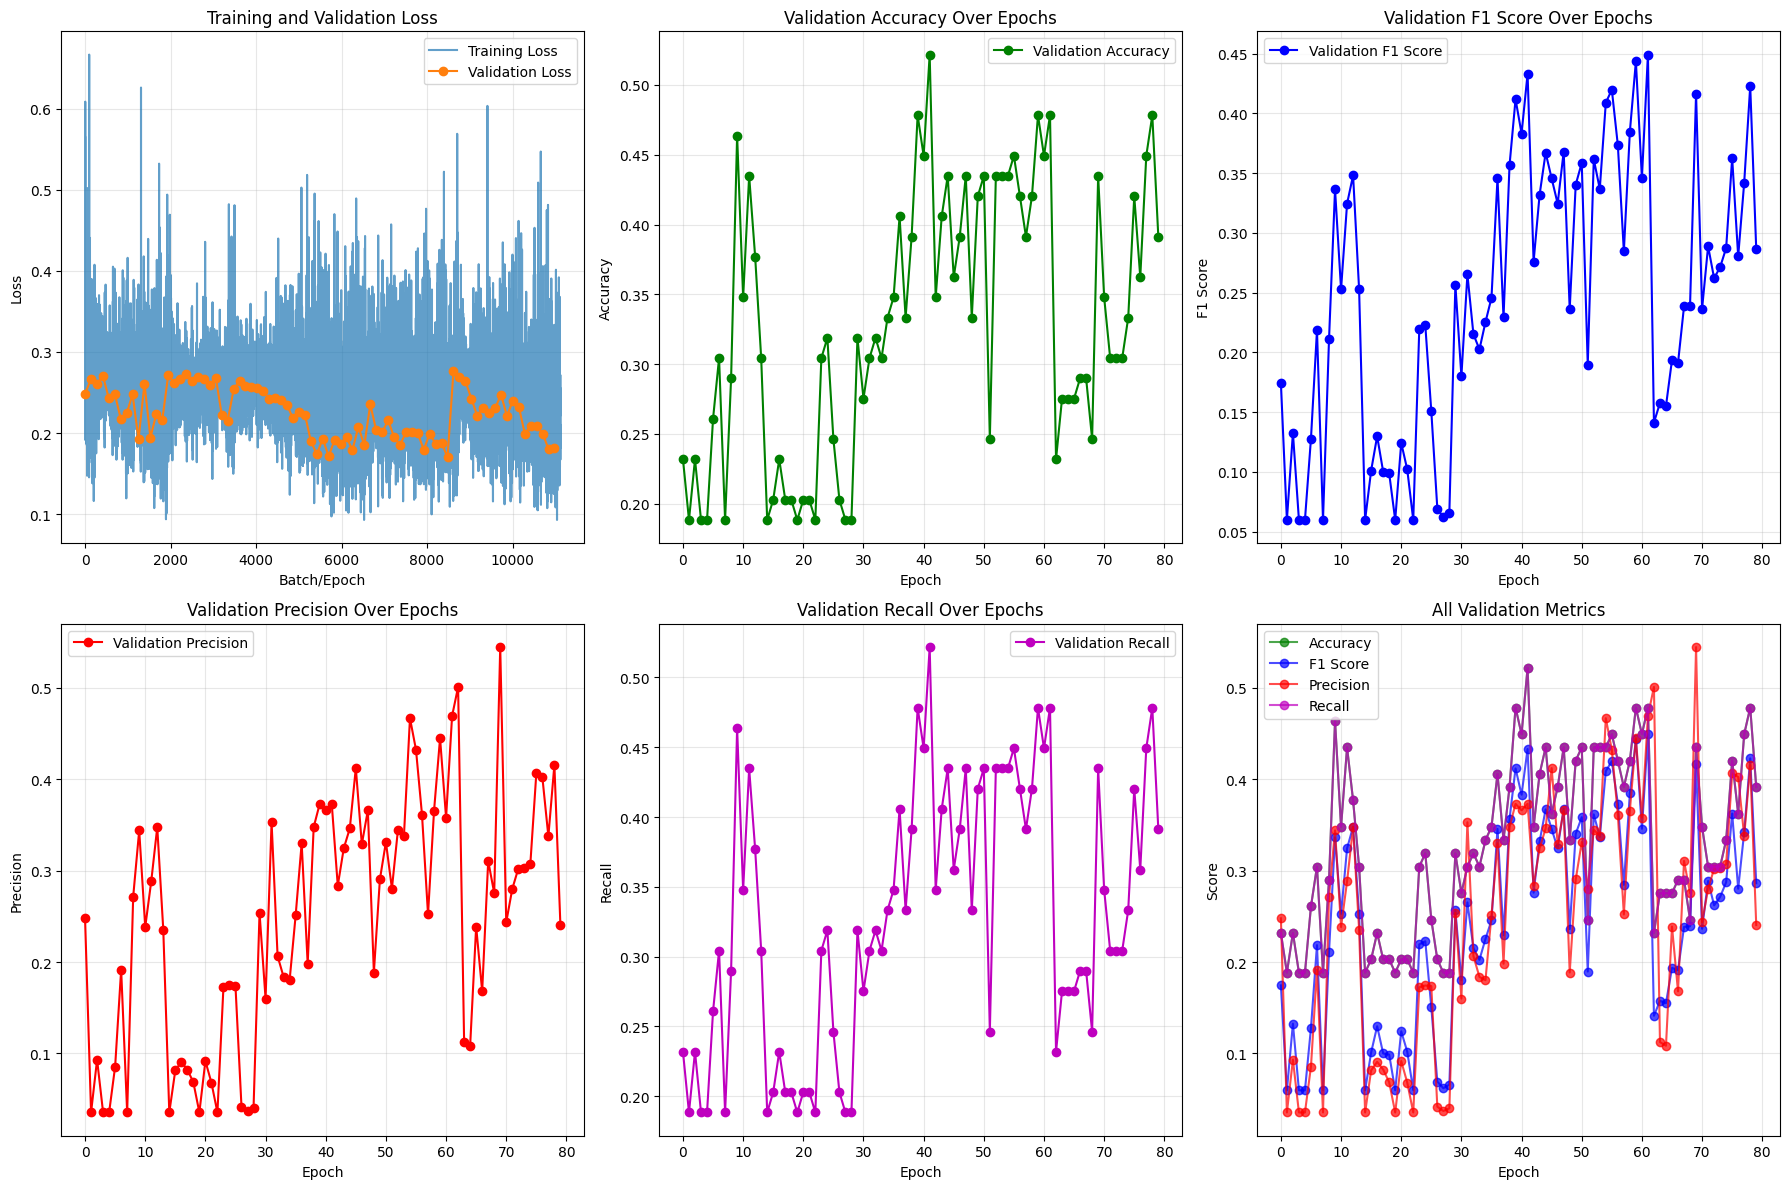

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


DETAILED TESTING RESULTS
              precision    recall  f1-score   support

 HorseRiding     0.3871    0.5714    0.4615        21
JavelinThrow     0.3636    0.7273    0.4848        11
    LongJump     0.0000    0.0000    0.0000        14
   PoleVault     0.0556    0.1250    0.0769         8
      Skiing     0.0000    0.0000    0.0000        17

    accuracy                         0.2958        71
   macro avg     0.1613    0.2847    0.2047        71
weighted avg     0.1771    0.2958    0.2203        71


OVERALL METRICS:
Accuracy:           0.2958
Precision (weighted): 0.1771
Recall (weighted):    0.2958
F1-Score (weighted):  0.2203

CONFUSION MATRIX:
              HorseRiding  JavelinThrow  LongJump  PoleVault  Skiing
HorseRiding            12             3         0          6       0
JavelinThrow            2             8         0          1       0
LongJump                2             5         0          7       0
PoleVault               2             5         0         

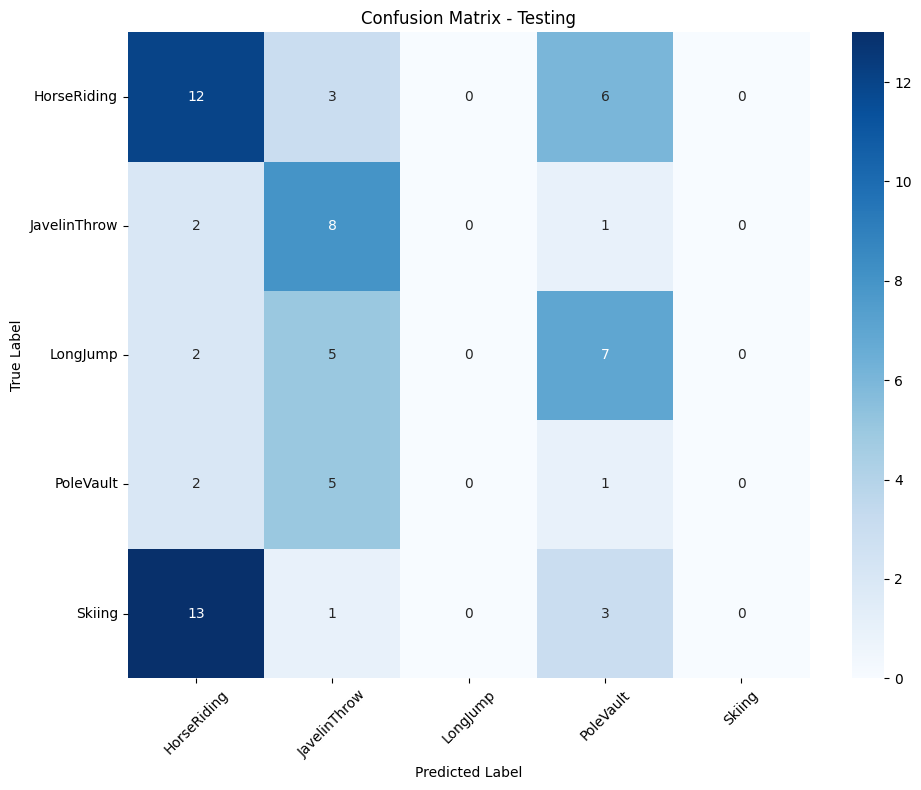


DETAILED PREDICTIONS:
Sample   True         Predicted    Correct 
---------------------------------------------
1        LongJump     JavelinThrow No      
2        LongJump     JavelinThrow No      
3        JavelinThrow JavelinThrow Yes     
4        LongJump     PoleVault    No      
5        PoleVault    JavelinThrow No      
6        Skiing       HorseRiding  No      
7        Skiing       HorseRiding  No      
8        HorseRiding  PoleVault    No      
9        Skiing       HorseRiding  No      
10       HorseRiding  PoleVault    No      
11       LongJump     PoleVault    No      
12       JavelinThrow JavelinThrow Yes     
13       HorseRiding  PoleVault    No      
14       HorseRiding  HorseRiding  Yes     
15       JavelinThrow PoleVault    No      
16       Skiing       PoleVault    No      
17       LongJump     PoleVault    No      
18       Skiing       PoleVault    No      
19       LongJump     HorseRiding  No      
20       Skiing       HorseRiding  No      

CUSTOM

In [ ]:
# Load the simple model instead
custom_model = load_simple_video_transformer(num_classes=len(class_names), num_frames=CONFIG['num_frames'])
custom_model.to(device)

print("TRAINING CUSTOM VIDEO TRANSFORMER")
print("="*60)

# Train with is_timesformer=False
custom_visualizer = train_with_visualization_universal(
    custom_model, train_loader, val_loader, device,
    epochs=CONFIG['custom_epochs'], lr=CONFIG['custom_lr'],
    is_timesformer=False  # KEY: Set this to False for custom model
)

# Evaluate with is_timesformer=False
custom_test_loss, custom_test_acc, custom_test_f1, custom_test_precision, custom_test_recall = evaluate_with_details_universal(
    custom_model, test_loader, device, class_names, phase="Testing",
    is_timesformer=False  # KEY: Set this to False for custom model
)

# Store results
custom_results = {
    'test_accuracy': custom_test_acc,
    'test_f1': custom_test_f1,
    'test_precision': custom_test_precision,
    'test_recall': custom_test_recall
}

# Save model
torch.save(custom_model.state_dict(), os.path.join(CONFIG['model_save_dir'], 'custom_video_transformer.pth'))

print(f"\nCUSTOM MODEL RESULTS:")
print(f"Test Accuracy:  {custom_test_acc:.4f}")
print(f"Test F1:        {custom_test_f1:.4f}")
print(f"Test Precision: {custom_test_precision:.4f}")
print(f"Test Recall:    {custom_test_recall:.4f}")

# Even though this custom model was trained for 80 epochs on just 5 classes, it did not perform very well. There could be many reasons for this:
- Trained from scratch
- Very limited dataset (no variety)
- Could use better loss function
- Can experiment with different hyperparameter values
- Could craft a more sophisticated model architecture

# Loading the TimeSformer model and modifying it for transfer learning
- This cell loads the pretrained TimeSformer model with its weights and also displays the layers in the model.

- The last encoder layer is kept unfrozen so that it could learn from the data, and the classifier is replaced with a 5-class classifier required for our task. We could unfreeze more layers if it feels necessary.

In [ ]:
def load_model_with_detailed_analysis(model_name=CONFIG['model_name'], num_classes=5):
    """Load TimeSformer with detailed architecture analysis"""

    print(f"\n{'='*80}")
    print("DETAILED MODEL ARCHITECTURE ANALYSIS")
    print(f"{'='*80}")

    print(f"Loading TimeSformer model: {model_name}")
    model = AutoModelForVideoClassification.from_pretrained(model_name)

    # Freeze all parameters first
    for p in model.parameters():
        p.requires_grad = False

    # Count encoder layers
    total_encoder_layers = 0
    if hasattr(model, "timesformer") and hasattr(model.timesformer, "encoder"):
        encoder_layers = model.timesformer.encoder.layer
        total_encoder_layers = len(encoder_layers)

        # Unfreeze last encoder layer
        for p in encoder_layers[-1].parameters():
            p.requires_grad = True

        print(f"Total encoder layers: {total_encoder_layers}")
        print(f"Unfrozen encoder layers: 1 (last layer)")

    # Replace and unfreeze classifier
    if hasattr(model, "classifier"):
        in_feats = model.classifier.in_features
        model.classifier = nn.Linear(in_feats, num_classes)
        for p in model.classifier.parameters():
            p.requires_grad = True
        print(f"Classifier replaced: {in_feats} -> {num_classes} classes")

    # Calculate parameter statistics
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())

    print(f"Model configured for 3 input channels (RGB)")
    print(f"Parameter efficiency: {trainable_params:,} / {total_params:,} ({trainable_params/total_params*100:.2f}%)")

    # DETAILED LAYER BREAKDOWN
    print(f"\nDETAILED LAYER BREAKDOWN:")
    print("-" * 80)

    layer_info = []
    for name, module in model.named_modules():
        if hasattr(module, 'weight'):
            total_layer_params = sum(p.numel() for p in module.parameters())
            trainable_layer_params = sum(p.numel() for p in module.parameters() if p.requires_grad)
            layer_info.append({
                'layer_name': name,
                'total_params': total_layer_params,
                'trainable_params': trainable_layer_params,
                'frozen': trainable_layer_params == 0
            })

    # Show important layers
    important_layers = [info for info in layer_info if info['total_params'] > 1000]
    important_layers.sort(key=lambda x: x['total_params'], reverse=True)

    print(f"{'Layer Name':<50} {'Total Params':<15} {'Trainable':<15} {'Status':<12}")
    print("-" * 92)
    for layer in important_layers[:15]:  # Show top 15 layers
        status = "TRAINABLE" if not layer['frozen'] else "FROZEN"
        layer_name_truncated = layer['layer_name'][:49]
        print(f"{layer_name_truncated:<50} {layer['total_params']:,<15} {layer['trainable_params']:,<15} {status:<12}")

    # Additional detailed analysis
    print(f"\nTRAINING STRATEGY ANALYSIS:")
    print("-" * 40)

    # Count layers by type
    embedding_params = sum(info['total_params'] for info in layer_info if 'embedding' in info['layer_name'])
    encoder_params = sum(info['total_params'] for info in layer_info if 'encoder.layer' in info['layer_name'])
    classifier_params = sum(info['total_params'] for info in layer_info if 'classifier' in info['layer_name'])
    other_params = sum(info['total_params'] for info in layer_info) - (embedding_params + encoder_params + classifier_params)

    # Count trainable layers by type
    trainable_embedding = sum(info['trainable_params'] for info in layer_info if 'embedding' in info['layer_name'])
    trainable_encoder = sum(info['trainable_params'] for info in layer_info if 'encoder.layer' in info['layer_name'])
    trainable_classifier = sum(info['trainable_params'] for info in layer_info if 'classifier' in info['layer_name'])
    trainable_other = sum(info['trainable_params'] for info in layer_info) - (trainable_embedding + trainable_encoder + trainable_classifier)

    print(f"Embedding layers: {embedding_params:,} total params ({trainable_embedding:,} trainable)")
    print(f"Encoder layers: {encoder_params:,} total params ({trainable_encoder:,} trainable)")
    print(f"Classifier layer: {classifier_params:,} total params ({trainable_classifier:,} trainable)")
    print(f"Other layers: {other_params:,} total params ({trainable_other:,} trainable)")

    # Enhanced model summary
    print(f"\nMODEL CONFIGURATION SUMMARY:")
    print("-" * 40)
    print(f"Input shape: [batch_size, {CONFIG['num_frames']}, 3, 224, 224]")
    print(f"Output shape: [batch_size, {num_classes}]")
    print(f"Training strategy: Fine-tune last encoder layer + classifier only")
    print(f"Optimization: Transfer learning with selective layer unfreezing")

    return model

## Analyzing the changed TimeSformer model

In [ ]:
# Load models
print("\nLOADING MODEL")
model = load_model_with_detailed_analysis(num_classes=len(class_names))

model.to(device)
print(f"\nMODEL LOADING COMPLETE")
print(f"{'='*80}")


LOADING MODEL

DETAILED MODEL ARCHITECTURE ANALYSIS
Loading TimeSformer model: facebook/timesformer-base-finetuned-k400


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/486M [00:00<?, ?B/s]

Total encoder layers: 12
Unfrozen encoder layers: 1 (last layer)
Classifier replaced: 768 -> 5 classes
Model configured for 3 input channels (RGB)
Parameter efficiency: 10,046,213 / 121,262,597 (8.28%)

DETAILED LAYER BREAKDOWN:
--------------------------------------------------------------------------------
Layer Name                                         Total Params    Trainable       Status      
--------------------------------------------------------------------------------------------
timesformer.encoder.layer.0.intermediate.dense     2362368,,,,,,,, 0,,,,,,,,,,,,,, FROZEN      
timesformer.encoder.layer.1.intermediate.dense     2362368,,,,,,,, 0,,,,,,,,,,,,,, FROZEN      
timesformer.encoder.layer.2.intermediate.dense     2362368,,,,,,,, 0,,,,,,,,,,,,,, FROZEN      
timesformer.encoder.layer.3.intermediate.dense     2362368,,,,,,,, 0,,,,,,,,,,,,,, FROZEN      
timesformer.encoder.layer.4.intermediate.dense     2362368,,,,,,,, 0,,,,,,,,,,,,,, FROZEN      
timesformer.encoder.l

# Training and evaluating the TimeSformer model performing transfer learning (Scroll till the end of the output to see plots & test results)

TRAINING TIMESFORMER MODEL

Starting training for 5 epochs...
Learning rate: 0.0001
Loss function: Focal Loss
Model type: TimeSformer


model.safetensors:   0%|          | 0.00/486M [00:00<?, ?B/s]

Epoch 1/5, Batch 10, Loss: 0.1175
Epoch 1/5, Batch 20, Loss: 0.0467
Epoch 1/5, Batch 30, Loss: 0.0348
Epoch 1/5, Batch 40, Loss: 0.0073
Epoch 1/5, Batch 50, Loss: 0.0220
Epoch 1/5, Batch 60, Loss: 0.0149
Epoch 1/5, Batch 70, Loss: 0.0193
Epoch 1/5, Batch 80, Loss: 0.0026
Epoch 1/5, Batch 90, Loss: 0.0144
Epoch 1/5, Batch 100, Loss: 0.0081
Epoch 1/5, Batch 110, Loss: 0.0165
Epoch 1/5, Batch 120, Loss: 0.0119
Epoch 1/5, Batch 130, Loss: 0.0115
Epoch 1/5 - Val Loss: 0.0034, Val Acc: 0.9855, Val F1: 0.9855
Epoch 2/5, Batch 10, Loss: 0.0008
Epoch 2/5, Batch 20, Loss: 0.0114
Epoch 2/5, Batch 30, Loss: 0.0002
Epoch 2/5, Batch 40, Loss: 0.0190
Epoch 2/5, Batch 50, Loss: 0.0155
Epoch 2/5, Batch 60, Loss: 0.0103
Epoch 2/5, Batch 70, Loss: 0.0056
Epoch 2/5, Batch 80, Loss: 0.0050
Epoch 2/5, Batch 90, Loss: 0.0076
Epoch 2/5, Batch 100, Loss: 0.0176
Epoch 2/5, Batch 110, Loss: 0.0035
Epoch 2/5, Batch 120, Loss: 0.0116
Epoch 2/5, Batch 130, Loss: 0.0022
Epoch 2/5 - Val Loss: 0.0018, Val Acc: 1.0000,

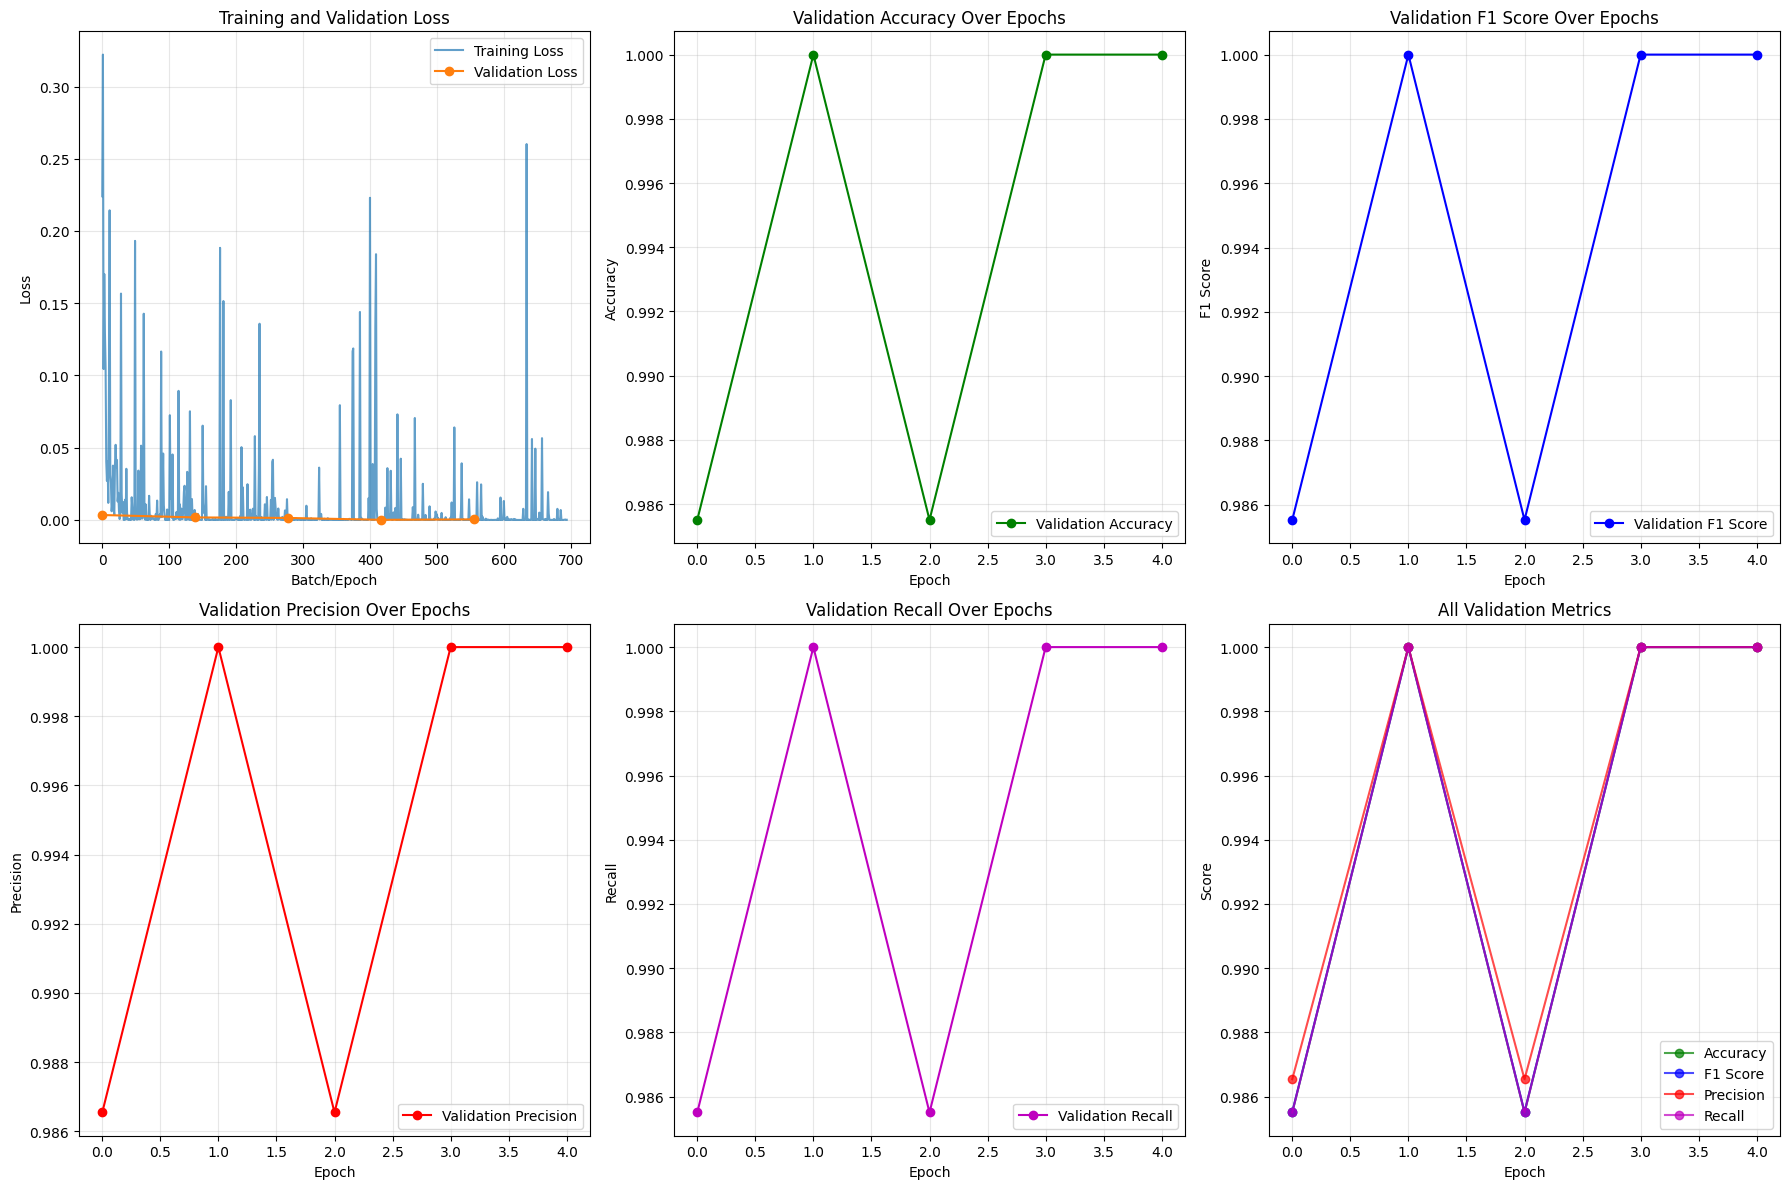


DETAILED TESTING RESULTS
              precision    recall  f1-score   support

 HorseRiding     1.0000    1.0000    1.0000        21
JavelinThrow     1.0000    1.0000    1.0000        11
    LongJump     1.0000    1.0000    1.0000        14
   PoleVault     1.0000    1.0000    1.0000         8
      Skiing     1.0000    1.0000    1.0000        17

    accuracy                         1.0000        71
   macro avg     1.0000    1.0000    1.0000        71
weighted avg     1.0000    1.0000    1.0000        71


OVERALL METRICS:
Accuracy:           1.0000
Precision (weighted): 1.0000
Recall (weighted):    1.0000
F1-Score (weighted):  1.0000

CONFUSION MATRIX:
              HorseRiding  JavelinThrow  LongJump  PoleVault  Skiing
HorseRiding            21             0         0          0       0
JavelinThrow            0            11         0          0       0
LongJump                0             0        14          0       0
PoleVault               0             0         0         

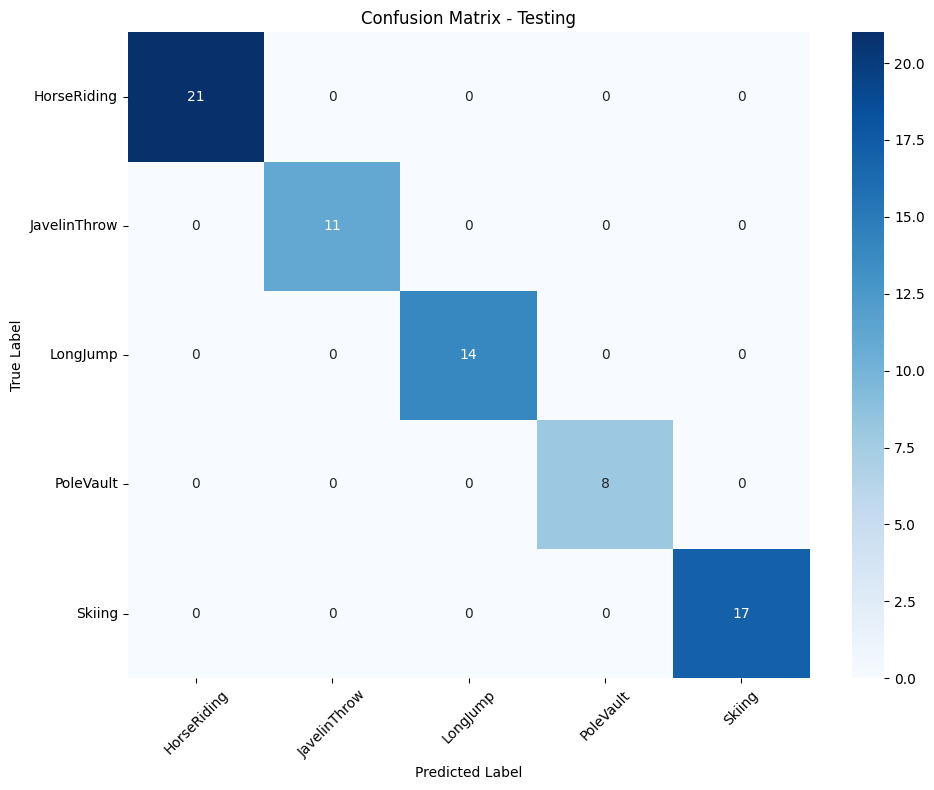


DETAILED PREDICTIONS:
Sample   True         Predicted    Correct 
---------------------------------------------
1        LongJump     LongJump     Yes     
2        LongJump     LongJump     Yes     
3        JavelinThrow JavelinThrow Yes     
4        LongJump     LongJump     Yes     
5        PoleVault    PoleVault    Yes     
6        Skiing       Skiing       Yes     
7        Skiing       Skiing       Yes     
8        HorseRiding  HorseRiding  Yes     
9        Skiing       Skiing       Yes     
10       HorseRiding  HorseRiding  Yes     
11       LongJump     LongJump     Yes     
12       JavelinThrow JavelinThrow Yes     
13       HorseRiding  HorseRiding  Yes     
14       HorseRiding  HorseRiding  Yes     
15       JavelinThrow JavelinThrow Yes     
16       Skiing       Skiing       Yes     
17       LongJump     LongJump     Yes     
18       Skiing       Skiing       Yes     
19       LongJump     LongJump     Yes     
20       Skiing       Skiing       Yes     

TIMESF

In [ ]:
print("TRAINING TIMESFORMER MODEL")
print("="*60)

# Train the model
visualizer = train_with_visualization_universal(
    model, train_loader, val_loader, device, epochs=CONFIG['epochs'], lr=CONFIG['learning_rate'], is_timesformer=True
)

# Test evaluation
test_loss, test_acc, test_f1, test_precision, test_recall = evaluate_with_details_universal(
    model, test_loader, device, class_names, phase="Testing", is_timesformer=True
)

# Store results
timesformer_results = {
    'test_accuracy': test_acc,
    'test_f1': test_f1,
    'test_precision': test_precision,
    'test_recall': test_recall
}

# Save model
torch.save(model.state_dict(), os.path.join(CONFIG['model_save_dir'], 'timesformer_model.pth'))

print(f"\nTIMESFORMER MODEL RESULTS:")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test F1:        {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")

# Defines the class and the functions required to compare the trained models on the videos downloaded from Youtube.

In [ ]:
class YouTubeVideoProcessor:
    def __init__(self, model, device, class_names, num_frames=CONFIG['num_frames'], model_name="Unknown", is_timesformer=True):
        self.model = model
        self.device = device
        self.class_names = class_names
        self.num_frames = num_frames
        self.model_name = model_name
        self.is_timesformer = is_timesformer  # NEW: Model type detection

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def extract_frames_from_whole_video(self, video_path):
        """Extract frames from entire YouTube video"""
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            return []

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)

        if total_frames > 0:
            frame_indices = np.linspace(0, total_frames - 1, self.num_frames).astype(int)
        else:
            frame_indices = []

        frames = []
        current_frame = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if current_frame in frame_indices:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)

            current_frame += 1

        cap.release()

        # Ensure we have exactly num_frames
        while len(frames) < self.num_frames:
            if frames:
                frames.append(frames[-1])
            else:
                frames.append(np.zeros((224, 224, 3), dtype=np.uint8))

        return frames

    def predict_video(self, video_path, actual_class=None, verbose=False):
        """Predict class for YouTube video with optional ground truth - WORKS FOR BOTH MODELS"""
        try:
            frames = self.extract_frames_from_whole_video(video_path)

            if not frames:
                return None

            tensor_frames = []
            for frame in frames:
                pil_frame = Image.fromarray(frame)
                tensor_frame = self.transform(pil_frame)
                tensor_frames.append(tensor_frame)

            video_tensor = torch.stack(tensor_frames, dim=0).unsqueeze(0)
            video_tensor = video_tensor.to(self.device, non_blocking=True)

            self.model.eval()
            with torch.no_grad():
                if self.is_timesformer:
                    # TimeSformer format
                    outputs = self.model(pixel_values=video_tensor)
                    logits = outputs.logits
                else:
                    # Custom transformer format
                    logits = self.model(video_tensor)

                probabilities = F.softmax(logits, dim=1)
                confidence, predicted_idx = torch.max(probabilities, 1)

                predicted_class = self.class_names[predicted_idx.item()]
                confidence_score = confidence.item()

            is_correct = predicted_class == actual_class if actual_class else None

            return {
                'predicted_class': predicted_class,
                'confidence': confidence_score,
                'actual_class': actual_class,
                'is_correct': is_correct,
                'all_probabilities': {self.class_names[i]: prob.item()
                                    for i, prob in enumerate(probabilities[0])},
                'model_name': self.model_name
            }

        except Exception as e:
            if verbose:
                print(f"Error processing {video_path}: {e}")
            return None


def test_multiple_models_on_youtube(models_dict, device, class_names, youtube_folder_path):
    """
    Test multiple models on YouTube videos and compare results - MODIFIED FOR BOTH MODEL TYPES

    Args:
        models_dict: Dictionary with model_name -> (model, is_timesformer) pairs
        device: torch device
        class_names: list of class names
        youtube_folder_path: path to YouTube videos folder

    Returns:
        Dictionary with results for each model
    """
    if not os.path.exists(youtube_folder_path):
        print(f"Folder not found: {youtube_folder_path}")
        return {}

    print(f"\n{'='*80}")
    print("COMPREHENSIVE YOUTUBE TESTING - ALL MODELS")
    print(f"{'='*80}")
    print(f"Testing {len(models_dict)} models on YouTube videos")
    print(f"Models: {list(models_dict.keys())}")

    class_folders = [f for f in os.listdir(youtube_folder_path)
                    if os.path.isdir(os.path.join(youtube_folder_path, f)) and f in class_names]

    if not class_folders:
        print("No valid class folders found!")
        return {}

    print(f"Found class folders: {class_folders}")

    # Get all video files
    all_videos = []
    video_extensions = ('.mp4', '.avi', '.mov', '.mkv', '.flv', '.webm', '.m4v')

    for class_name in class_folders:
        class_path = os.path.join(youtube_folder_path, class_name)
        video_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(video_extensions)]

        for video_file in video_files:
            all_videos.append({
                'path': os.path.join(class_path, video_file),
                'filename': video_file,
                'actual_class': class_name
            })

    print(f"Total videos to test: {len(all_videos)}")

    # Test each model on all videos
    all_results = {}

    for model_name, (model, is_timesformer) in models_dict.items():
        print(f"\nTesting {model_name} ({'TimeSformer' if is_timesformer else 'Custom Transformer'})...")
        print("-" * 60)

        processor = YouTubeVideoProcessor(
            model, device, class_names,
            model_name=model_name,
            is_timesformer=is_timesformer  # Pass model type
        )
        model_results = []

        for i, video_info in enumerate(all_videos):
            if (i + 1) % 5 == 0:  # Progress indicator
                print(f"  Progress: {i+1}/{len(all_videos)} videos")

            result = processor.predict_video(
                video_info['path'],
                actual_class=video_info['actual_class'],
                verbose=False
            )

            if result:
                result['video'] = video_info['filename']
                model_results.append(result)

        all_results[model_name] = model_results

        # Quick summary for this model
        if model_results:
            correct = sum(1 for r in model_results if r['is_correct'])
            total = len(model_results)
            accuracy = correct / total
            print(f"  {model_name} accuracy: {accuracy:.3f} ({correct}/{total})")

    return all_results

def analyze_multi_model_youtube_results(all_results, class_names):
    """Analyze and visualize results from multiple models with F1 computation per model."""
    if not all_results:
        print("No results to analyze.")
        return {}

    print(f"\n{'='*80}")
    print("MULTI-MODEL YOUTUBE GENERALIZATION ANALYSIS")
    print(f"{'='*80}")

    # Calculate overall statistics for each model
    model_stats = {}

    for model_name, results in all_results.items():
        if not results:
            continue

        correct_predictions = sum(1 for r in results if r['is_correct'])
        total_predictions = len(results)
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0

        # Confidence statistics
        confidences = [r['confidence'] for r in results]
        avg_confidence = float(np.mean(confidences)) if confidences else 0.0

        # Build label arrays for F1 calculation
        y_true = []
        y_pred = []
        class_to_idx = {c: i for i, c in enumerate(class_names)}
        for r in results:
            if r['actual_class'] in class_to_idx and r['predicted_class'] in class_to_idx:
                y_true.append(class_to_idx[r['actual_class']])
                y_pred.append(class_to_idx[r['predicted_class']])

        if len(y_true) > 0:
            # Weighted F1 to account for support imbalance in YouTube folders
            f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
            precision_w = precision_score(y_true, y_pred, average='weighted', zero_division=0)
            recall_w = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        else:
            f1_weighted = 0.0
            precision_w = 0.0
            recall_w = 0.0

        # Per-class accuracy
        class_stats = {}
        for class_name in class_names:
            class_results = [r for r in results if r['actual_class'] == class_name]
            if class_results:
                class_correct = sum(1 for r in class_results if r['is_correct'])
                class_accuracy = class_correct / len(class_results)
                class_stats[class_name] = {
                    'accuracy': class_accuracy,
                    'total': len(class_results),
                    'correct': class_correct
                }

        model_stats[model_name] = {
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'precision_weighted': precision_w,
            'recall_weighted': recall_w,
            'total_videos': total_predictions,
            'correct_predictions': correct_predictions,
            'avg_confidence': avg_confidence,
            'class_stats': class_stats
        }

    # Print overall comparison
    print("OVERALL MODEL COMPARISON (YouTube):")
    print("-" * 90)
    print(f"{'Model':<25} {'Acc':<8} {'F1(w)':<8} {'Prec(w)':<8} {'Rec(w)':<8} {'Correct':<8} {'Total':<8} {'AvgConf':<8}")
    print("-" * 90)
    for model_name, stats in model_stats.items():
        print(f"{model_name:<25} "
              f"{stats['accuracy']:<8.3f} "
              f"{stats['f1_weighted']:<8.3f} "
              f"{stats['precision_weighted']:<8.3f} "
              f"{stats['recall_weighted']:<8.3f} "
              f"{stats['correct_predictions']:<8} "
              f"{stats['total_videos']:<8} "
              f"{stats['avg_confidence']:<8.3f}")

    # Per-class analysis
    print(f"\nPER-CLASS ANALYSIS:")
    for class_name in class_names:
        print(f"\n{class_name.upper()}:")
        print("-" * 40)
        print(f"{'Model':<25} {'Accuracy':<10} {'Correct/Total':<12}")
        print("-" * 40)
        for model_name, stats in model_stats.items():
            if class_name in stats['class_stats']:
                class_stat = stats['class_stats'][class_name]
                print(f"{model_name:<25} {class_stat['accuracy']:<10.3f} "
                      f"{class_stat['correct']}/{class_stat['total']:<12}")

    # Plots and saving via your existing helpers
    create_youtube_comparison_plots(model_stats, class_names)

    return model_stats


def create_youtube_comparison_plots(model_stats, class_names):
    """Create comprehensive comparison plots - FIXED VERSION"""

    # Check if we have any model stats to plot
    if not model_stats:
        print("No model statistics available for plotting.")
        return

    # Extract data for plotting - only models that actually have results
    model_names = list(model_stats.keys())

    # Skip plotting if no models have results
    if not model_names:
        print("No models with valid results for plotting.")
        return

    accuracies = [model_stats[name]['accuracy'] for name in model_names]
    confidences = [model_stats[name]['avg_confidence'] for name in model_names]

    # Create comprehensive comparison plot
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # 1. Overall Accuracy Comparison
    colors_for_models = ['lightcoral', 'lightgreen', 'lightskyblue', 'gold', 'plum'][:len(model_names)]
    bars = axes[0, 0].bar(model_names, accuracies, color=colors_for_models)
    axes[0, 0].set_title('YouTube Generalization - Overall Accuracy', fontweight='bold')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Add accuracy labels on bars
    for bar, acc in zip(bars, accuracies):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                       f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    # 2. Average Confidence Comparison
    bars = axes[0, 1].bar(model_names, confidences, color=colors_for_models)
    axes[0, 1].set_title('Average Confidence Scores', fontweight='bold')
    axes[0, 1].set_ylabel('Average Confidence')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)

    for bar, conf in zip(bars, confidences):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                       f'{conf:.3f}', ha='center', va='bottom', fontweight='bold')

    # 3. Per-Class Accuracy Heatmap
    class_accuracy_matrix = []
    for model_name in model_names:
        model_class_accs = []
        for class_name in class_names:
            if class_name in model_stats[model_name]['class_stats']:
                acc = model_stats[model_name]['class_stats'][class_name]['accuracy']
            else:
                acc = 0
            model_class_accs.append(acc)
        class_accuracy_matrix.append(model_class_accs)

    # Convert to numpy array and check if it's not empty
    class_accuracy_matrix = np.array(class_accuracy_matrix)

    if class_accuracy_matrix.size > 0:
        im = axes[0, 2].imshow(class_accuracy_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
        axes[0, 2].set_title('Per-Class Accuracy Heatmap', fontweight='bold')
        axes[0, 2].set_xticks(range(len(class_names)))
        axes[0, 2].set_xticklabels(class_names, rotation=45)
        axes[0, 2].set_yticks(range(len(model_names)))
        axes[0, 2].set_yticklabels(model_names)

        # Add text annotations
        for i in range(len(model_names)):
            for j in range(len(class_names)):
                axes[0, 2].text(j, i, f'{class_accuracy_matrix[i][j]:.2f}',
                               ha='center', va='center', fontweight='bold')

        plt.colorbar(im, ax=axes[0, 2])
    else:
        axes[0, 2].text(0.5, 0.5, 'No data available', ha='center', va='center',
                       transform=axes[0, 2].transAxes, fontsize=14)
        axes[0, 2].set_title('Per-Class Accuracy Heatmap', fontweight='bold')

    # 4. Model Performance Ranking
    model_ranking = sorted(zip(model_names, accuracies), key=lambda x: x[1], reverse=True)
    ranked_names, ranked_accs = zip(*model_ranking)

    # Create color mapping for ranked models
    ranked_colors = []
    for ranked_name in ranked_names:
        idx = model_names.index(ranked_name)
        ranked_colors.append(colors_for_models[idx])

    bars = axes[1, 0].barh(ranked_names, ranked_accs, color=ranked_colors)
    axes[1, 0].set_title('Model Performance Ranking', fontweight='bold')
    axes[1, 0].set_xlabel('Accuracy')
    axes[1, 0].set_xlim(0, 1)
    axes[1, 0].grid(True, alpha=0.3)

    for bar, acc in zip(bars, ranked_accs):
        axes[1, 0].text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                       f'{acc:.3f}', ha='left', va='center', fontweight='bold')

    # 5. Video Count Comparison
    video_counts = [model_stats[name]['total_videos'] for name in model_names]
    bars = axes[1, 1].bar(model_names, video_counts, color=colors_for_models)
    axes[1, 1].set_title('Videos Tested per Model', fontweight='bold')
    axes[1, 1].set_ylabel('Number of Videos')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)

    for bar, count in zip(bars, video_counts):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                       f'{count}', ha='center', va='bottom', fontweight='bold')

    # 6. Accuracy vs Confidence Scatter
    axes[1, 2].scatter(confidences, accuracies, s=100, alpha=0.7, c=colors_for_models)

    for i, model_name in enumerate(model_names):
        axes[1, 2].annotate(model_name, (confidences[i], accuracies[i]),
                           xytext=(5, 5), textcoords='offset points', fontsize=10)

    axes[1, 2].set_title('Accuracy vs Confidence Analysis', fontweight='bold')
    axes[1, 2].set_xlabel('Average Confidence')
    axes[1, 2].set_ylabel('Accuracy')
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].set_xlim(0, 1)
    axes[1, 2].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

    # Create detailed per-class comparison
    create_detailed_class_comparison_plot(model_stats, class_names)

def create_detailed_class_comparison_plot(model_stats, class_names):
    """Create detailed per-class comparison plot - FIXED VERSION"""

    if not model_stats or not class_names:
        print("No data available for detailed class comparison plot.")
        return

    fig, axes = plt.subplots(1, len(class_names), figsize=(4*len(class_names), 6))
    if len(class_names) == 1:
        axes = [axes]

    model_names = list(model_stats.keys())

    # Skip if no models
    if not model_names:
        print("No models available for plotting.")
        return

    # Use colors that match the number of models
    colors = ['lightcoral', 'lightgreen', 'lightskyblue', 'gold', 'plum'][:len(model_names)]

    for i, class_name in enumerate(class_names):
        class_accuracies = []

        for model_name in model_names:
            if class_name in model_stats[model_name]['class_stats']:
                acc = model_stats[model_name]['class_stats'][class_name]['accuracy']
            else:
                acc = 0
            class_accuracies.append(acc)

        bars = axes[i].bar(model_names, class_accuracies, color=colors)
        axes[i].set_title(f'{class_name}', fontweight='bold')
        axes[i].set_ylabel('Accuracy')
        axes[i].set_ylim(0, 1)
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45)

        # Add accuracy labels
        for bar, acc in zip(bars, class_accuracies):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                        f'{acc:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.suptitle('Per-Class YouTube Generalization Performance', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def choose_best_model_from_youtube(youtube_results, class_names, prefer_metric='f1_weighted'):
    """
    Choose the best model based on YouTube results.
    prefer_metric: 'f1_weighted' (default), 'accuracy', or 'confidence'
    Returns: (best_model_name, best_score)
    """
    if not youtube_results:
        print("No YouTube results present to choose best model.")
        return None, None

    # Compute fresh stats to get F1 reliably
    model_stats = analyze_multi_model_youtube_results(youtube_results, class_names)

    metric_key = {
        'f1_weighted': 'f1_weighted',
        'accuracy': 'accuracy',
        'confidence': 'avg_confidence'
    }.get(prefer_metric, 'f1_weighted')

    best_model_name = None
    best_score = -1.0

    for model_name, stats in model_stats.items():
        score = float(stats.get(metric_key, 0.0))
        if score > best_score:
            best_score = score
            best_model_name = model_name

    print(f"\nBest YouTube performer by {prefer_metric}: {best_model_name} (score={best_score:.3f})")
    return best_model_name, best_score


def youtube_select_best_and_set(models_dict, device, class_names, youtube_path, prefer_metric='f1_weighted'):
    """
    Test all provided models on YouTube videos and choose best based on YouTube F1/metric.
    models_dict: { display_name: (torch_model, is_timesformer) } - UPDATED FORMAT
    Returns: (youtube_results, best_model_name)
    """
    if not os.path.exists(youtube_path):
        print(f"YouTube test folder not found: {youtube_path}")
        return {}, None

    print(f"\n{'='*60}")
    print("YOUTUBE EVALUATION FOR MODEL SELECTION")
    print(f"{'='*60}")

    # Evaluate all models
    all_results = test_multiple_models_on_youtube(models_dict, device, class_names, youtube_path)
    if not all_results:
        print("No YouTube results obtained")
        return {}, None

    # Choose best based on F1/metric
    best_model_name, _ = choose_best_model_from_youtube(all_results, class_names, prefer_metric=prefer_metric)
    return all_results, best_model_name


# Tests the custom transformer model on the downloaded youtube videos

TESTING CUSTOM TRANSFORMER MODEL ON YOUTUBE VIDEOS
Testing model: Custom Transformer

COMPREHENSIVE YOUTUBE TESTING - ALL MODELS
Testing 1 models on YouTube videos
Models: ['Custom Transformer']
Found class folders: ['HorseRiding', 'JavelinThrow', 'LongJump', 'Skiing', 'PoleVault']
Total videos to test: 25

Testing Custom Transformer (Custom Transformer)...
------------------------------------------------------------
  Progress: 5/25 videos
  Progress: 10/25 videos
  Progress: 15/25 videos
  Progress: 20/25 videos
  Progress: 25/25 videos
  Custom Transformer accuracy: 0.200 (5/25)
{'Custom Transformer': [{'predicted_class': 'HorseRiding', 'confidence': 0.3020894229412079, 'actual_class': 'HorseRiding', 'is_correct': True, 'all_probabilities': {'HorseRiding': 0.3020894229412079, 'JavelinThrow': 0.08483852446079254, 'LongJump': 0.14231766760349274, 'PoleVault': 0.22990861535072327, 'Skiing': 0.24084578454494476}, 'model_name': 'Custom Transformer', 'video': 'How to gallop on the horse.p

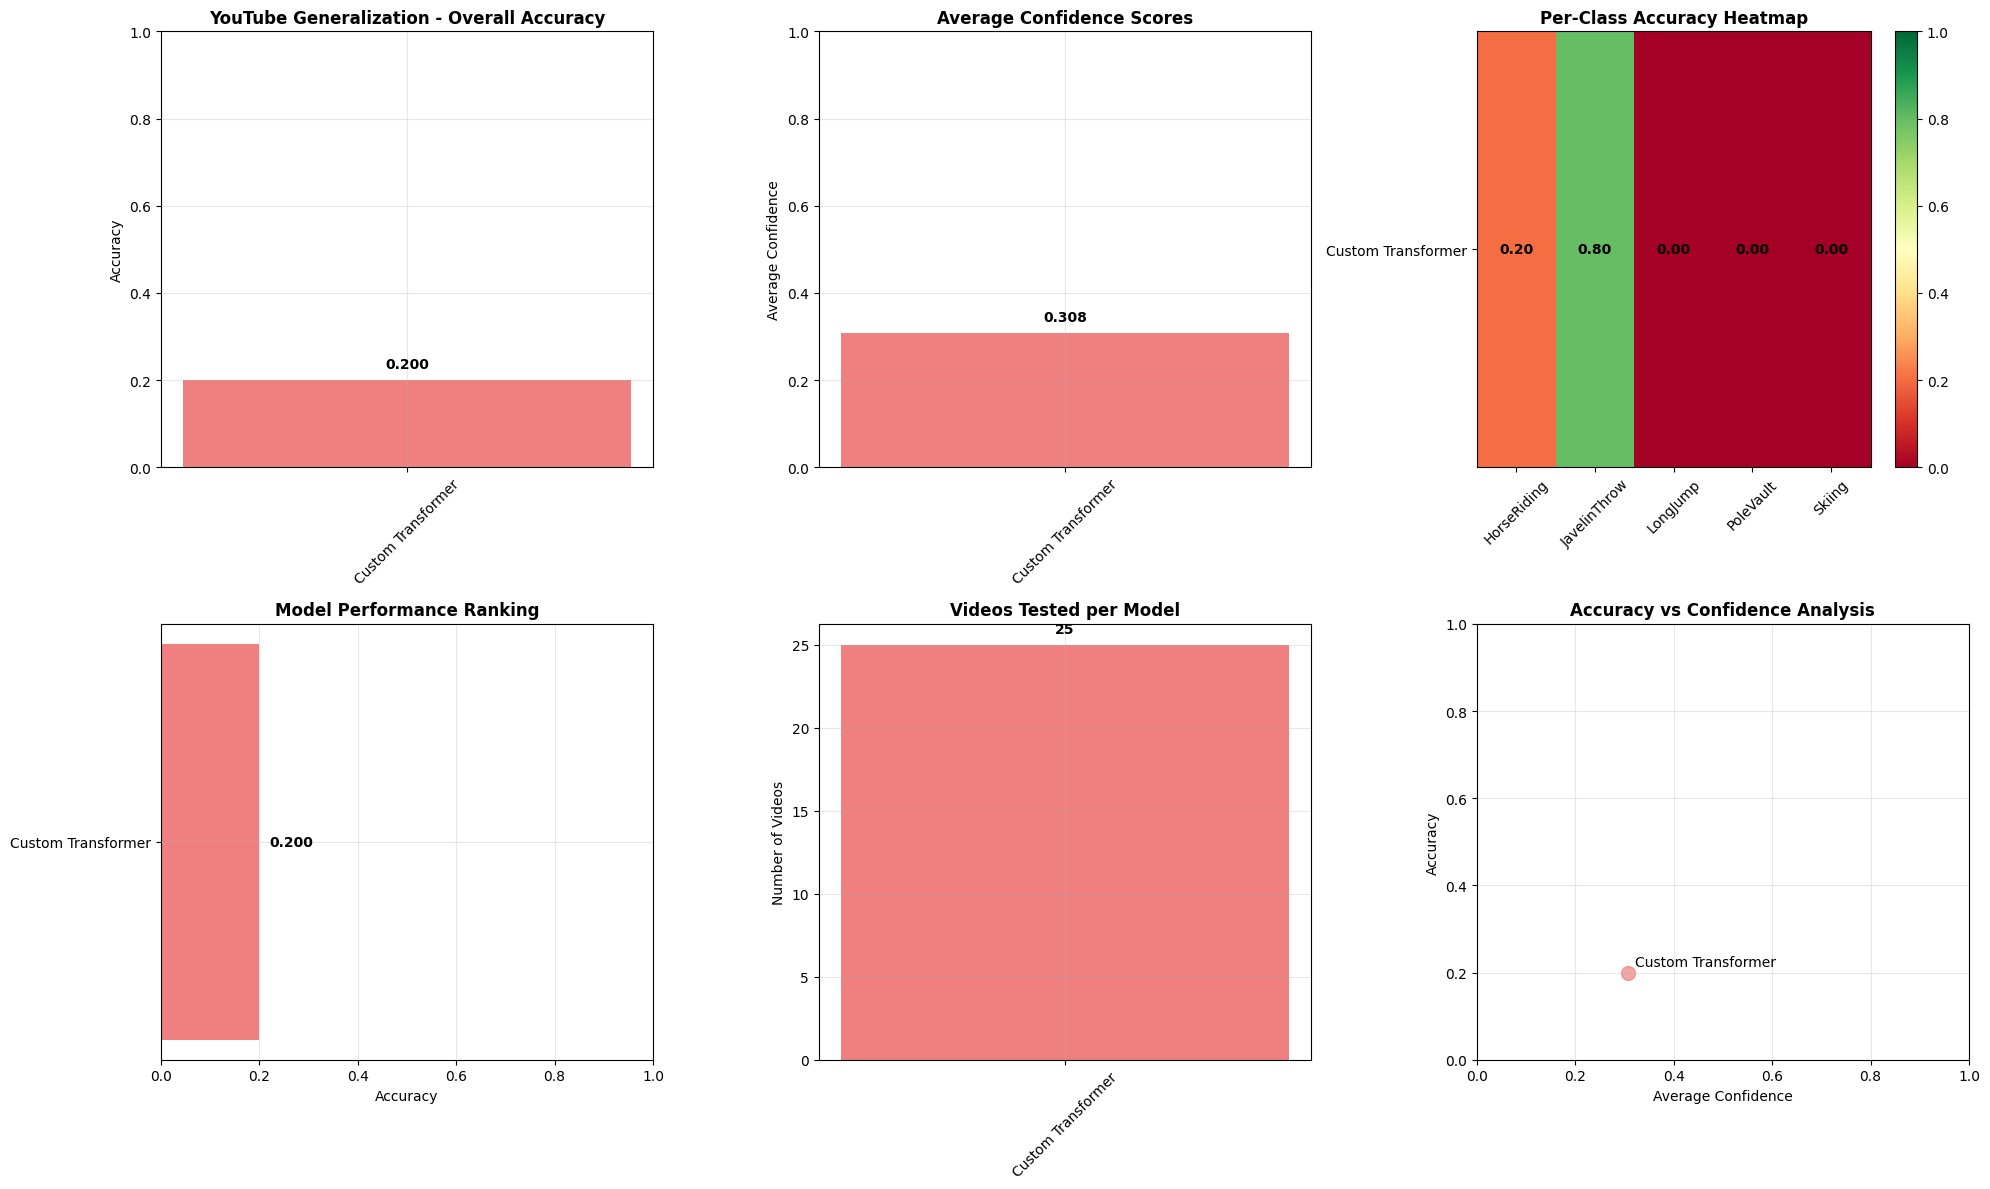

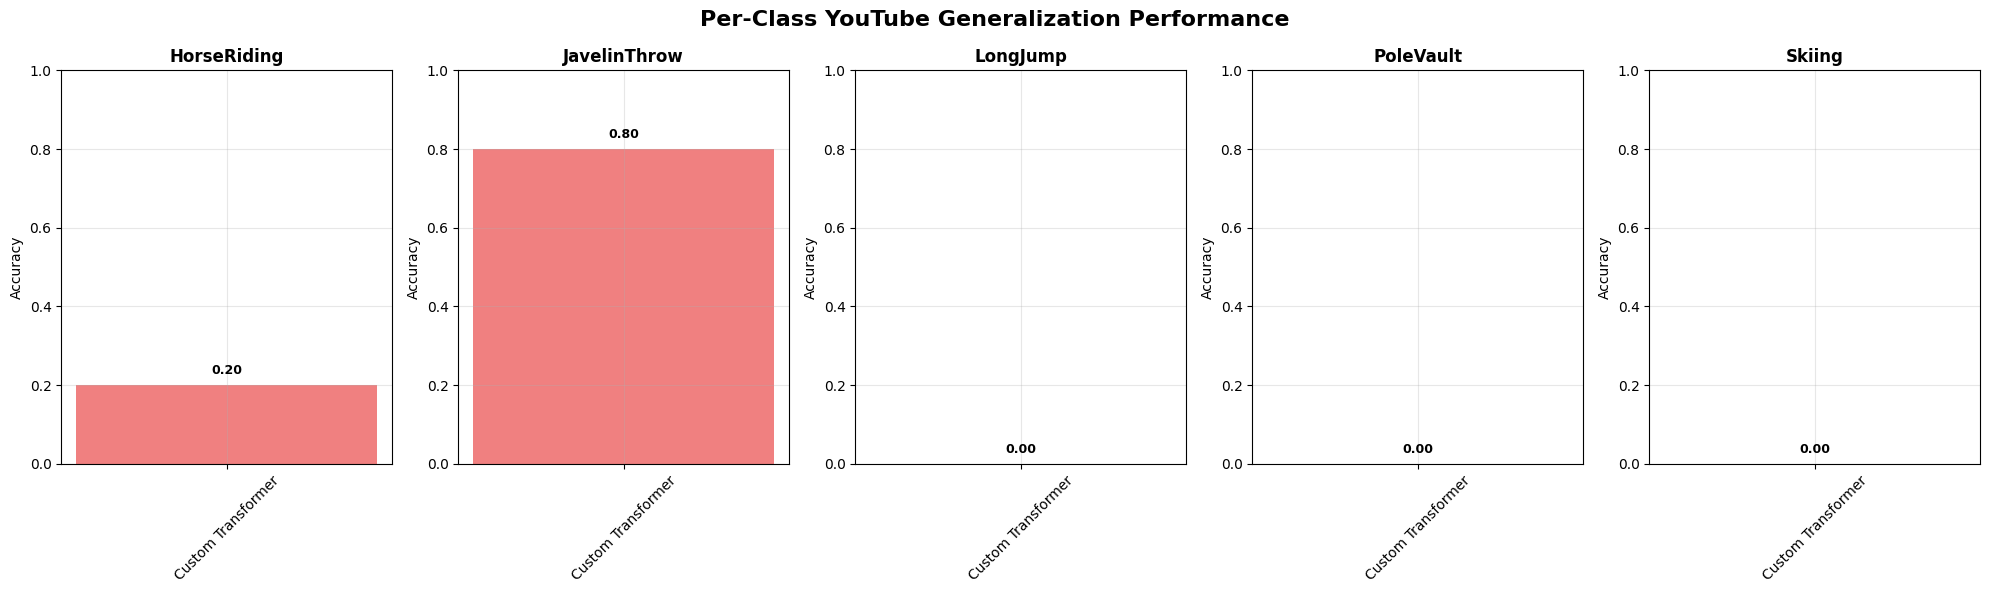


CUSTOM TRANSFORMER MODEL RESULTS:
             Model  Videos Tested  Correct Predictions  YouTube Accuracy  Average Confidence
Custom Transformer             25                    5            0.2000              0.3082

SUMMARY - CUSTOM TRANSFORMER MODEL:
YouTube Accuracy: 0.2000
Average Confidence: 0.3082


In [ ]:
# Test Custom Transformer Model on YouTube videos
print("="*60)
print("TESTING CUSTOM TRANSFORMER MODEL ON YOUTUBE VIDEOS")
print("="*60)

youtube_path = "/content/drive/MyDrive/Big_vision_task_files&folders/Youtube_test_videos"

if os.path.exists(youtube_path):
    # Test Custom Transformer model
    models_to_test_custom = {
        'Custom Transformer': (custom_model, False)  # (model, is_timesformer)
    }

    print(f"Testing model: {list(models_to_test_custom.keys())[0]}")

    # Test this model on YouTube videos
    youtube_results_custom = test_multiple_models_on_youtube(
        models_to_test_custom, device, class_names, youtube_path
    )

    print(youtube_results_custom)

    if youtube_results_custom:
        # Analyze results for Custom model
        youtube_stats_custom = analyze_multi_model_youtube_results(
            youtube_results_custom, class_names
        )

        # Create summary for Custom model
        custom_summary = []
        for model_name, results in youtube_results_custom.items():
            if results:
                correct = sum(1 for r in results if r['is_correct'])
                total = len(results)
                accuracy = correct / total
                avg_confidence = np.mean([r['confidence'] for r in results])

                custom_summary.append({
                    'Model': model_name,
                    'Videos Tested': total,
                    'Correct Predictions': correct,
                    'YouTube Accuracy': accuracy,
                    'Average Confidence': avg_confidence
                })

        custom_df = pd.DataFrame(custom_summary)
        print("\nCUSTOM TRANSFORMER MODEL RESULTS:")
        print("="*50)
        print(custom_df.to_string(index=False, float_format='%.4f'))

        # Store results for comparison
        custom_youtube_accuracy = custom_df['YouTube Accuracy'].iloc[0]
        custom_youtube_confidence = custom_df['Average Confidence'].iloc[0]

        print(f"\nSUMMARY - CUSTOM TRANSFORMER MODEL:")
        print(f"YouTube Accuracy: {custom_youtube_accuracy:.4f}")
        print(f"Average Confidence: {custom_youtube_confidence:.4f}")

else:
    print(f"YouTube test folder not found: {youtube_path}")
    custom_youtube_accuracy = None
    custom_youtube_confidence = None


# Tests the TimeSformer model with the downloaded youtube videos

TESTING TIMESFORMER MODEL ON YOUTUBE VIDEOS
Testing model: TimeSformer Model

COMPREHENSIVE YOUTUBE TESTING - ALL MODELS
Testing 1 models on YouTube videos
Models: ['TimeSformer Model']
Found class folders: ['HorseRiding', 'JavelinThrow', 'LongJump', 'Skiing', 'PoleVault']
Total videos to test: 25

Testing TimeSformer Model (TimeSformer)...
------------------------------------------------------------
  Progress: 5/25 videos
  Progress: 10/25 videos
  Progress: 15/25 videos
  Progress: 20/25 videos
  Progress: 25/25 videos
  TimeSformer Model accuracy: 0.960 (24/25)

MULTI-MODEL YOUTUBE GENERALIZATION ANALYSIS
OVERALL MODEL COMPARISON (YouTube):
------------------------------------------------------------------------------------------
Model                     Acc      F1(w)    Prec(w)  Rec(w)   Correct  Total    AvgConf 
------------------------------------------------------------------------------------------
TimeSformer Model         0.960    0.960    0.967    0.960    24       25   

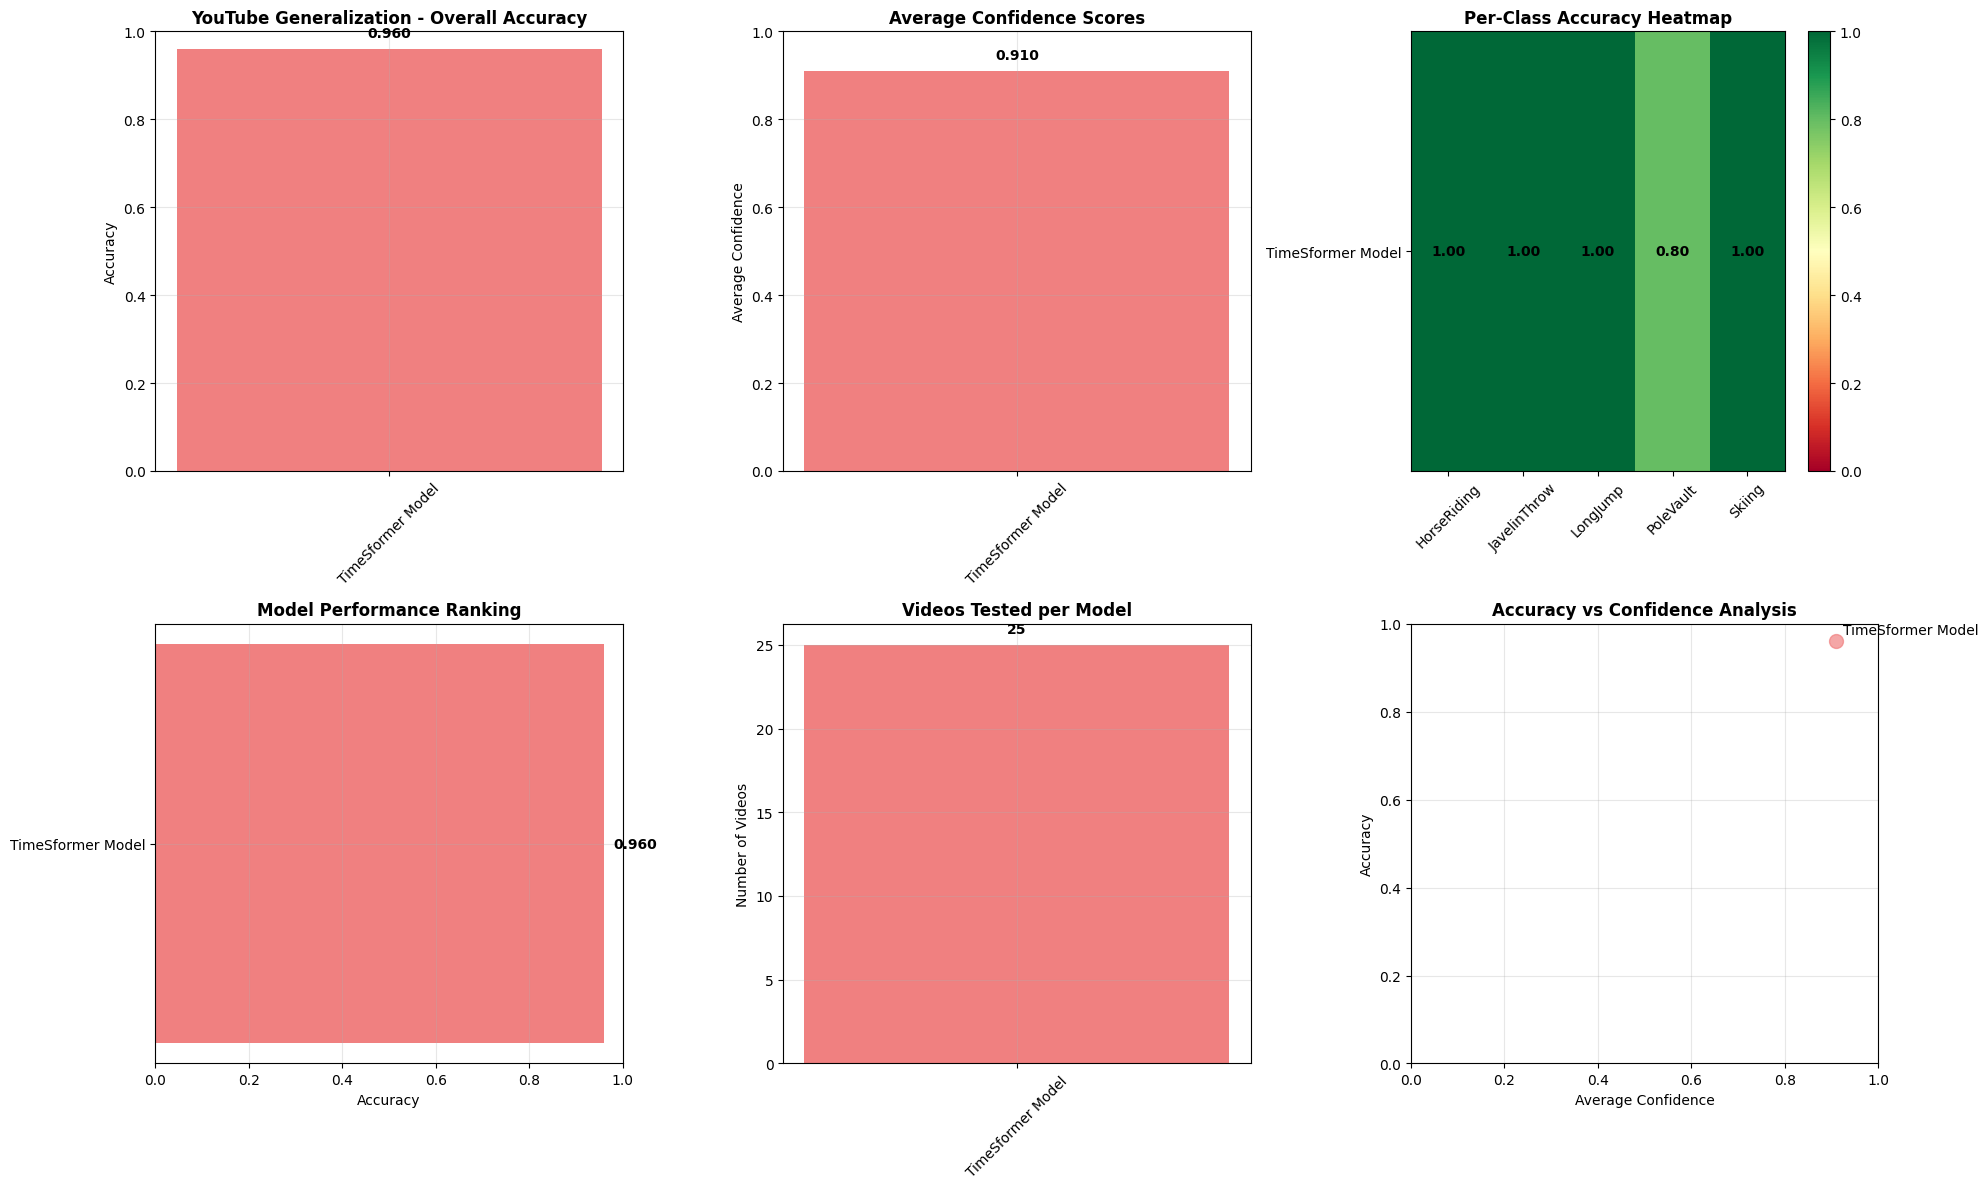

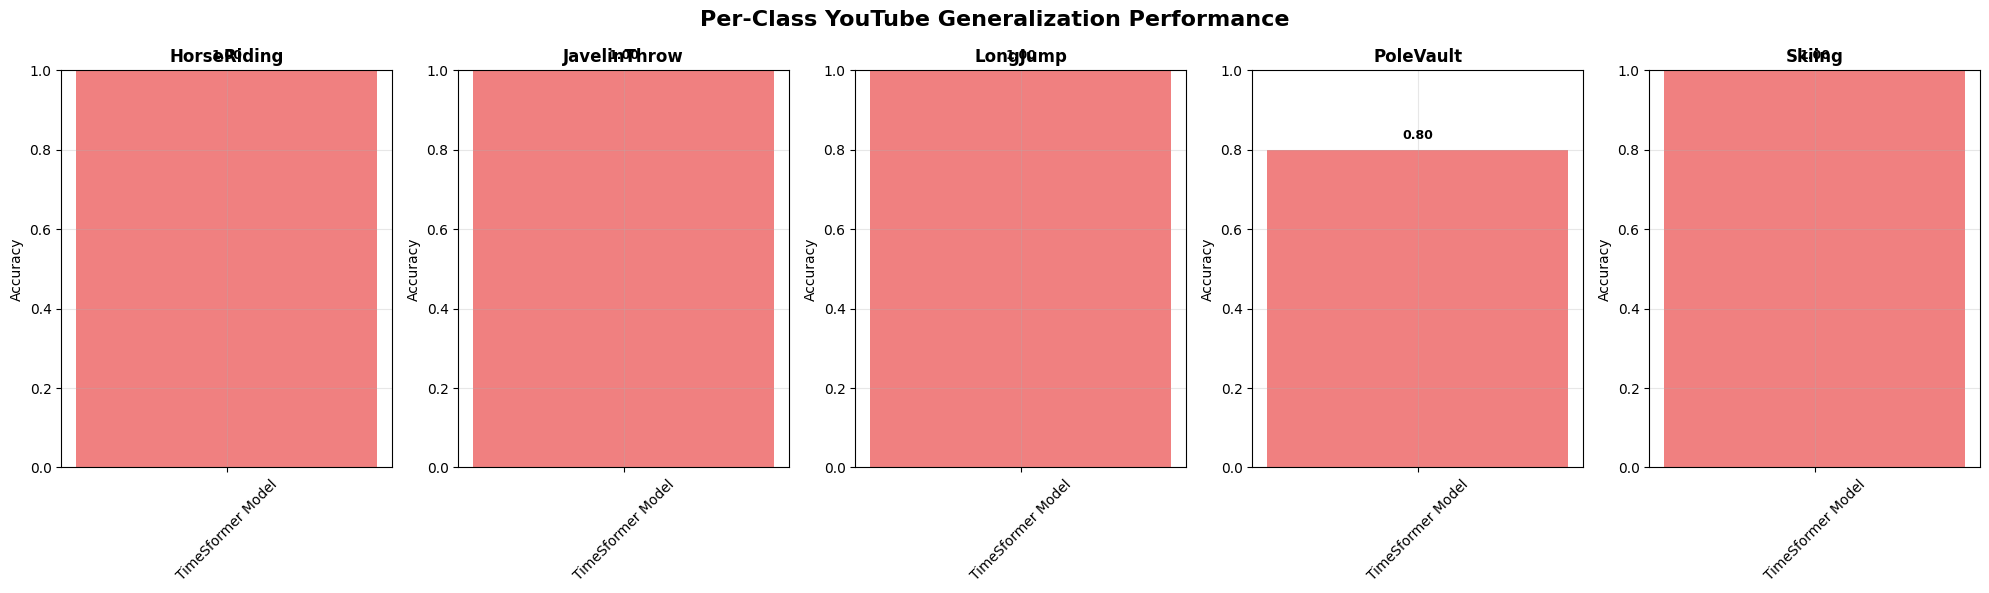


TIMESFORMER MODEL RESULTS:
            Model  Videos Tested  Correct Predictions  YouTube Accuracy  Average Confidence
TimeSformer Model             25                   24            0.9600              0.9103

SUMMARY - TIMESFORMER MODEL:
YouTube Accuracy: 0.9600
Average Confidence: 0.9103


In [ ]:
# Test TimeSformer Model on YouTube videos
print("="*60)
print("TESTING TIMESFORMER MODEL ON YOUTUBE VIDEOS")
print("="*60)

youtube_path = "/content/drive/MyDrive/Big_vision_task_files&folders/Youtube_test_videos"

if os.path.exists(youtube_path):
    # Test TimeSformer model
    models_to_test_timesformer = {
        'TimeSformer Model': (model, True)
    }

    print(f"Testing model: {list(models_to_test_timesformer.keys())[0]}")

    # Test this model on YouTube videos
    youtube_results_timesformer = test_multiple_models_on_youtube(
        models_to_test_timesformer, device, class_names, youtube_path
    )

    if youtube_results_timesformer:
        # Analyze results for TimeSformer model
        youtube_stats_timesformer = analyze_multi_model_youtube_results(
            youtube_results_timesformer, class_names
        )

        # Create summary for TimeSformer model
        timesformer_summary = []
        for model_name, results in youtube_results_timesformer.items():
            if results:
                correct = sum(1 for r in results if r['is_correct'])
                total = len(results)
                accuracy = correct / total
                avg_confidence = np.mean([r['confidence'] for r in results])

                timesformer_summary.append({
                    'Model': model_name,
                    'Videos Tested': total,
                    'Correct Predictions': correct,
                    'YouTube Accuracy': accuracy,
                    'Average Confidence': avg_confidence
                })

        timesformer_df = pd.DataFrame(timesformer_summary)
        print("\nTIMESFORMER MODEL RESULTS:")
        print("="*50)
        print(timesformer_df.to_string(index=False, float_format='%.4f'))

        # Store results for comparison
        timesformer_youtube_accuracy = timesformer_df['YouTube Accuracy'].iloc[0]
        timesformer_youtube_confidence = timesformer_df['Average Confidence'].iloc[0]

        print(f"\nSUMMARY - TIMESFORMER MODEL:")
        print(f"YouTube Accuracy: {timesformer_youtube_accuracy:.4f}")
        print(f"Average Confidence: {timesformer_youtube_confidence:.4f}")

else:
    print(f"YouTube test folder not found: {youtube_path}")
    timesformer_youtube_accuracy = None
    timesformer_youtube_confidence = None


# Compares both the trained models to select the best one

COMPARING BOTH MODELS AND SELECTING BEST
COMPREHENSIVE MODEL COMPARISON:
             Model  YouTube Accuracy  Average Confidence  Test Set F1  Test Set Accuracy
       TimeSformer            0.9600              0.9103       1.0000             1.0000
Custom Transformer            0.2000              0.3082       0.2203             0.2958

COMBINED SCORES (60% YouTube + 40% Test Set):
TimeSformer: 0.9760
Custom Transformer: 0.2383

MODEL SELECTION ANALYSIS:
----------------------------------------
Best by YouTube accuracy: TimeSformer
Best by test set F1: TimeSformer
Best by combined score: TimeSformer

FINAL SELECTION: TimeSformer
Selected model will be used for further analysis


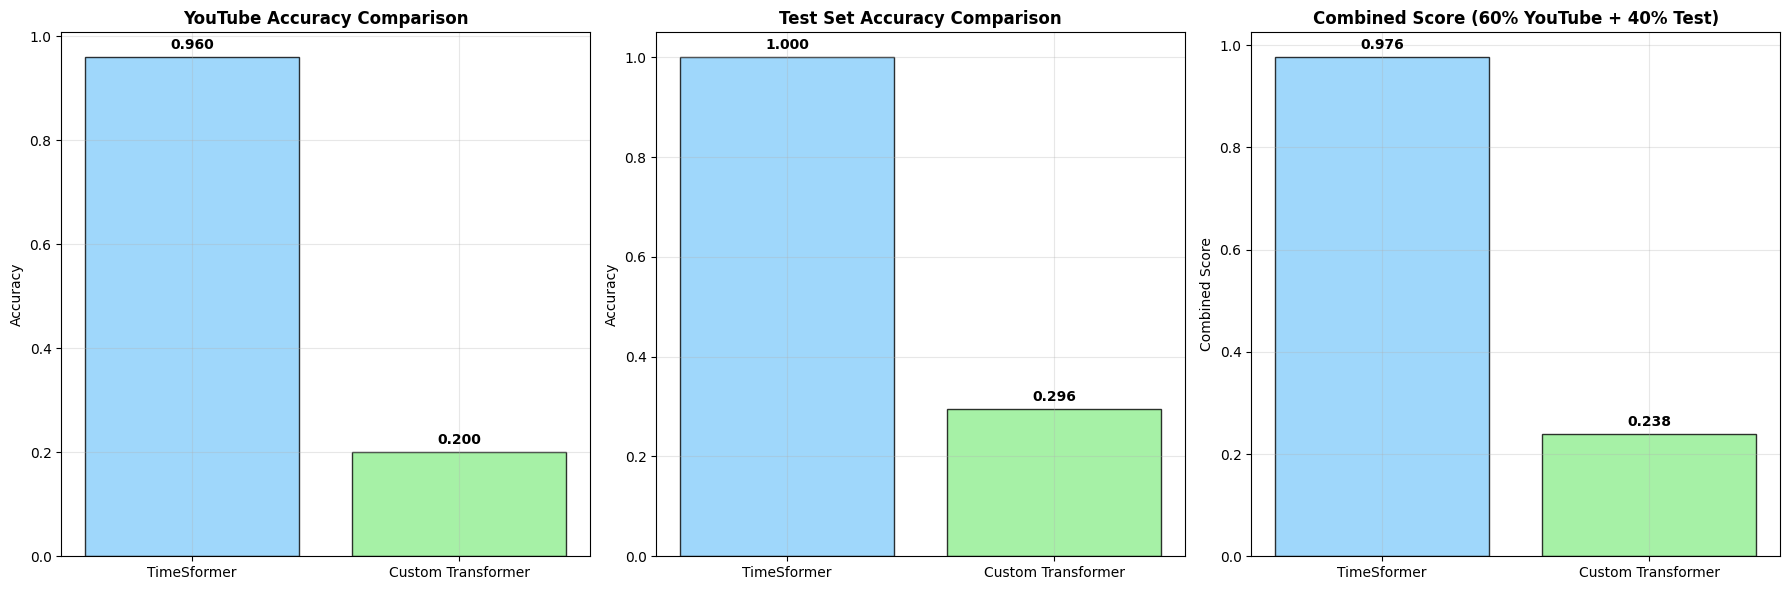


FINAL CONFIGURATION:
Selected model: TimeSformer
Model type: TimeSformer


In [ ]:
# Compare both models and select the best one
print("="*60)
print("COMPARING BOTH MODELS AND SELECTING BEST")
print("="*60)

if 'timesformer_youtube_accuracy' in locals() and 'custom_youtube_accuracy' in locals():
    if timesformer_youtube_accuracy is not None and custom_youtube_accuracy is not None:

        # Create comparison table
        comparison_data = {
            'Model': ['TimeSformer', 'Custom Transformer'],
            'YouTube Accuracy': [timesformer_youtube_accuracy, custom_youtube_accuracy],
            'Average Confidence': [timesformer_youtube_confidence, custom_youtube_confidence],
            'Test Set F1': [timesformer_results['test_f1'], custom_results['test_f1']],
            'Test Set Accuracy': [timesformer_results['test_accuracy'], custom_results['test_accuracy']]
        }

        comparison_df = pd.DataFrame(comparison_data)

        print("COMPREHENSIVE MODEL COMPARISON:")
        print("="*80)
        print(comparison_df.to_string(index=False, float_format='%.4f'))

        # Calculate combined scores
        youtube_weights = 0.6  # Weight for YouTube performance (real-world generalization)
        test_weights = 0.4     # Weight for test set performance

        timesformer_combined = (timesformer_youtube_accuracy * youtube_weights +
                               timesformer_results['test_accuracy'] * test_weights)

        custom_combined = (custom_youtube_accuracy * youtube_weights +
                          custom_results['test_accuracy'] * test_weights)

        print(f"\nCOMBINED SCORES (60% YouTube + 40% Test Set):")
        print(f"TimeSformer: {timesformer_combined:.4f}")
        print(f"Custom Transformer: {custom_combined:.4f}")

        # Select best model based on different criteria
        print(f"\nMODEL SELECTION ANALYSIS:")
        print("-" * 40)

        # Best by YouTube accuracy
        if custom_youtube_accuracy > timesformer_youtube_accuracy:
            best_youtube = "Custom Transformer"
        elif timesformer_youtube_accuracy > custom_youtube_accuracy:
            best_youtube = "TimeSformer"
        else:
            best_youtube = "Tie"

        # Best by test set F1
        if custom_results['test_f1'] > timesformer_results['test_f1']:
            best_test = "Custom Transformer"
        elif timesformer_results['test_f1'] > custom_results['test_f1']:
            best_test = "TimeSformer"
        else:
            best_test = "Tie"

        # Best by combined score
        if custom_combined > timesformer_combined:
            best_combined = "Custom Transformer"
            best_model = custom_model
            best_model_is_timesformer = False
        elif timesformer_combined > custom_combined:
            best_combined = "TimeSformer"
            best_model = model
            best_model_is_timesformer = True
        else:
            best_combined = "Tie"
            best_model = model  # Default to TimeSformer in case of tie
            best_model_is_timesformer = True

        print(f"Best by YouTube accuracy: {best_youtube}")
        print(f"Best by test set F1: {best_test}")
        print(f"Best by combined score: {best_combined}")

        print(f"\nFINAL SELECTION: {best_combined}")
        print(f"Selected model will be used for further analysis")

        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        models = ['TimeSformer', 'Custom Transformer']
        youtube_accs = [timesformer_youtube_accuracy, custom_youtube_accuracy]
        test_accs = [timesformer_results['test_accuracy'], custom_results['test_accuracy']]
        combined_scores = [timesformer_combined, custom_combined]

        colors = ['lightskyblue', 'lightgreen']

        # YouTube accuracy comparison
        bars1 = axes[0].bar(models, youtube_accs, color=colors, alpha=0.8, edgecolor='black')
        axes[0].set_title('YouTube Accuracy Comparison', fontweight='bold')
        axes[0].set_ylabel('Accuracy')
        axes[0].grid(True, alpha=0.3)

        for bar, acc in zip(bars1, youtube_accs):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

        # Test set accuracy comparison
        bars2 = axes[1].bar(models, test_accs, color=colors, alpha=0.8, edgecolor='black')
        axes[1].set_title('Test Set Accuracy Comparison', fontweight='bold')
        axes[1].set_ylabel('Accuracy')
        axes[1].grid(True, alpha=0.3)

        for bar, acc in zip(bars2, test_accs):
            axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

        # Combined score comparison
        bars3 = axes[2].bar(models, combined_scores, color=colors, alpha=0.8, edgecolor='black')
        axes[2].set_title('Combined Score (60% YouTube + 40% Test)', fontweight='bold')
        axes[2].set_ylabel('Combined Score')
        axes[2].grid(True, alpha=0.3)

        for bar, score in zip(bars3, combined_scores):
            axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

        best_model_name = best_combined

    else:
        print("YouTube testing results not available for comparison")
        best_model_name = "TimeSformer"  # Default
        best_model = model
        best_model_is_timesformer = True

else:
    print("Previous model testing results not found")
    best_model_name = "TimeSformer"  # Default
    best_model = model
    best_model_is_timesformer = True

print(f"\nFINAL CONFIGURATION:")
print(f"Selected model: {best_model_name}")
print(f"Model type: {'TimeSformer' if best_model_is_timesformer else 'Custom Transformer'}")

# Store the best model info for later use
selected_model_info = {
    'model': best_model,
    'name': best_model_name,
    'is_timesformer': best_model_is_timesformer
}

# EXTRA WORK (Experimentation)!!!!!!

I had mentioned previously that I decided to not work with VideoMAE model because I felt it is too complicated for the data I have, right? I similarly feel about the TimeSformer model as well. This is definitely a simpler architecture compared to VideoMAE but this might still be complicated for our data, given that the model is performing very well after only 5 epochs and a low learning rate of 1e-4.

I think we could prune a few layers and still attain similar results on our data. So, I thought I could experiment this by pruning/removing 2, 4, 6, 8 layers of the models respectively, and compare their performances against our trained TimeSformer model.

# This cell defines the functions to create the pruned models and the pruning is done from the top.

In [ ]:
def create_pruned_timesformer(num_layers_to_remove=2, num_classes=5):
    """Remove top layers from TimeSformer to make task harder"""
    model = AutoModelForVideoClassification.from_pretrained("facebook/timesformer-base-finetuned-k400")

    original_layers = model.timesformer.encoder.layer
    total_layers = len(original_layers)

    print(f"Original model: {total_layers} layers")
    print(f"Removing top {num_layers_to_remove} layers")
    print(f"New model: {total_layers - num_layers_to_remove} layers")

    # Remove the top layers
    pruned_layers = original_layers[:-num_layers_to_remove]
    model.timesformer.encoder.layer = nn.ModuleList(pruned_layers)

    # Replace classifier
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)

    return model

def load_model_with_layer_removal(layers_to_remove=0, freeze_strategy="last_1", num_classes=5):
    """Load TimeSformer with layers removed and selective unfreezing"""
    if layers_to_remove > 0:
        model = create_pruned_timesformer(layers_to_remove, num_classes)
    else:
        model = AutoModelForVideoClassification.from_pretrained("facebook/timesformer-base-finetuned-k400")
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)

    # Freeze all parameters first
    for param in model.parameters():
        param.requires_grad = False

    encoder_layers = model.timesformer.encoder.layer
    total_remaining = len(encoder_layers)
    unfrozen = []

    # Apply unfreezing strategy
    if freeze_strategy == "last_1":
        if total_remaining >= 1:
            for param in encoder_layers[-1].parameters():
                param.requires_grad = True
            unfrozen.append("last_1_layer")

    # Always unfreeze classifier
    for param in model.classifier.parameters():
        param.requires_grad = True
    unfrozen.append("classifier")

    # Count parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())

    print(f"Layers removed: {layers_to_remove}")
    print(f"Remaining encoder layers: {total_remaining}")
    print(f"Unfrozen components: {', '.join(unfrozen)}")
    print(f"Trainable params: {trainable_params:,} / {total_params:,} ({trainable_params/total_params*100:.1f}%)")

    return model

def create_pruning_comparison_table(results):
    """Create and save pruning comparison table"""
    df = pd.DataFrame(results)

    print(f"\n{'='*80}")
    print("LAYER PRUNING IMPACT ON MODEL PERFORMANCE")
    print(f"{'='*80}")
    print(f"{'Model':<25} {'Removed':<8} {'Accuracy':<10} {'F1 Score':<10} {'Precision':<10} {'Recall':<10}")
    print("-" * 80)

    for _, row in df.iterrows():
        print(f"{row['name']:<25} {row['layers_removed']:<8} {row['test_accuracy']:<10.4f} "
              f"{row['test_f1']:<10.4f} {row['test_precision']:<10.4f} {row['test_recall']:<10.4f}")

def save_model_and_results(model, results, model_name="timesformer_ucf101"):
    """Save trained model and all results"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save model
    model_path = os.path.join(CONFIG['model_save_dir'], f"{model_name}_{timestamp}.pth")
    torch.save(model.state_dict(), model_path)

    # Save configuration and results
    results_data = {
        'timestamp': timestamp,
        'config': CONFIG,
        'results': results,
        'model_path': model_path
    }

    print(f"Model saved to: {model_path}")

# This cell trains the pruned model on the same data that was used to train the previous models

In [ ]:
def experiment_with_layer_removal_selected(train_loader, val_loader, test_loader, experiments, device, class_names, base_model):
    """Run pruning experiments with selected layer removals (2, 4, 6, 8 only)"""
    os.makedirs(CONFIG['model_save_dir'], exist_ok=True)

    results = []
    pruned_models = {}  # Store the actual model objects for YouTube testing

    for exp in experiments:
        print(f"\n{'='*60}")
        print(f"EXPERIMENT: {exp['name']}")
        print(f"{'='*60}")

        model_pruned = load_model_with_layer_removal(
            layers_to_remove=exp["remove"],
            freeze_strategy="last_1",
            num_classes=len(class_names)
        )

        model_pruned.to(device)

        # Check if model already exists to avoid retraining
        save_path = os.path.join(CONFIG['model_save_dir'], f"timesformer_removed{exp['remove']}.pth")
        if os.path.exists(save_path):
            try:
                model_pruned.load_state_dict(torch.load(save_path, map_location=device))
                print(f"Loaded existing model from {save_path}")
            except:
                print("Failed to load existing model, training new one...")
                # Train the model
                visualizer = train_with_visualization_universal(model_pruned, train_loader, val_loader, device,
                                                    epochs=CONFIG['epochs'], lr=CONFIG['learning_rate'], is_timesformer=True)
                # Save model
                torch.save(model_pruned.state_dict(), save_path)
                print(f"Model saved to {save_path}")
        else:
            # Train the model
            visualizer = train_with_visualization_universal(model_pruned, train_loader, val_loader, device,
                                                epochs=CONFIG['epochs'], lr=CONFIG['learning_rate'], is_timesformer=True)
            # Save model
            torch.save(model_pruned.state_dict(), save_path)
            print(f"Model saved to {save_path}")

        # Test evaluation
        test_loss, test_acc, test_f1, test_precision, test_recall = evaluate_with_details_universal(
            model_pruned, test_loader, device, class_names, phase="Testing", is_timesformer=True
        )

        results.append({
            "name": exp["name"],
            "layers_removed": exp["remove"],
            "test_accuracy": test_acc,
            "test_f1": test_f1,
            "test_precision": test_precision,
            "test_recall": test_recall
        })

        # Store the trained model for YouTube testing
        pruned_models[exp["name"]] = model_pruned

        print(f"Result: Acc={test_acc:.4f}, F1={test_f1:.4f}")

    # Create comparison table and save results
    create_pruning_comparison_table(results)

    return results, pruned_models

# Experimentation by removing first 2 layers of the model (Scroll till the end of the output to see plots & test results)


STARTING PRUNING EXPERIMENTS (2 layers removed)

EXPERIMENT: Pruned Model (10 layers)
Original model: 12 layers
Removing top 2 layers
New model: 10 layers
Layers removed: 2
Remaining encoder layers: 10
Unfrozen components: last_1_layer, classifier
Trainable params: 10,046,213 / 101,177,861 (9.9%)

Starting training for 5 epochs...
Learning rate: 0.0001
Loss function: Focal Loss
Model type: TimeSformer
Epoch 1/5, Batch 10, Loss: 0.2475
Epoch 1/5, Batch 20, Loss: 0.1626
Epoch 1/5, Batch 30, Loss: 0.0966
Epoch 1/5, Batch 40, Loss: 0.0596
Epoch 1/5, Batch 50, Loss: 0.0571
Epoch 1/5, Batch 60, Loss: 0.0249
Epoch 1/5, Batch 70, Loss: 0.0220
Epoch 1/5, Batch 80, Loss: 0.0242
Epoch 1/5, Batch 90, Loss: 0.0209
Epoch 1/5, Batch 100, Loss: 0.0079
Epoch 1/5, Batch 110, Loss: 0.0085
Epoch 1/5, Batch 120, Loss: 0.0058
Epoch 1/5, Batch 130, Loss: 0.0152
Epoch 1/5 - Val Loss: 0.0024, Val Acc: 0.9855, Val F1: 0.9853
Epoch 2/5, Batch 10, Loss: 0.0417
Epoch 2/5, Batch 20, Loss: 0.0257
Epoch 2/5, Batch 3

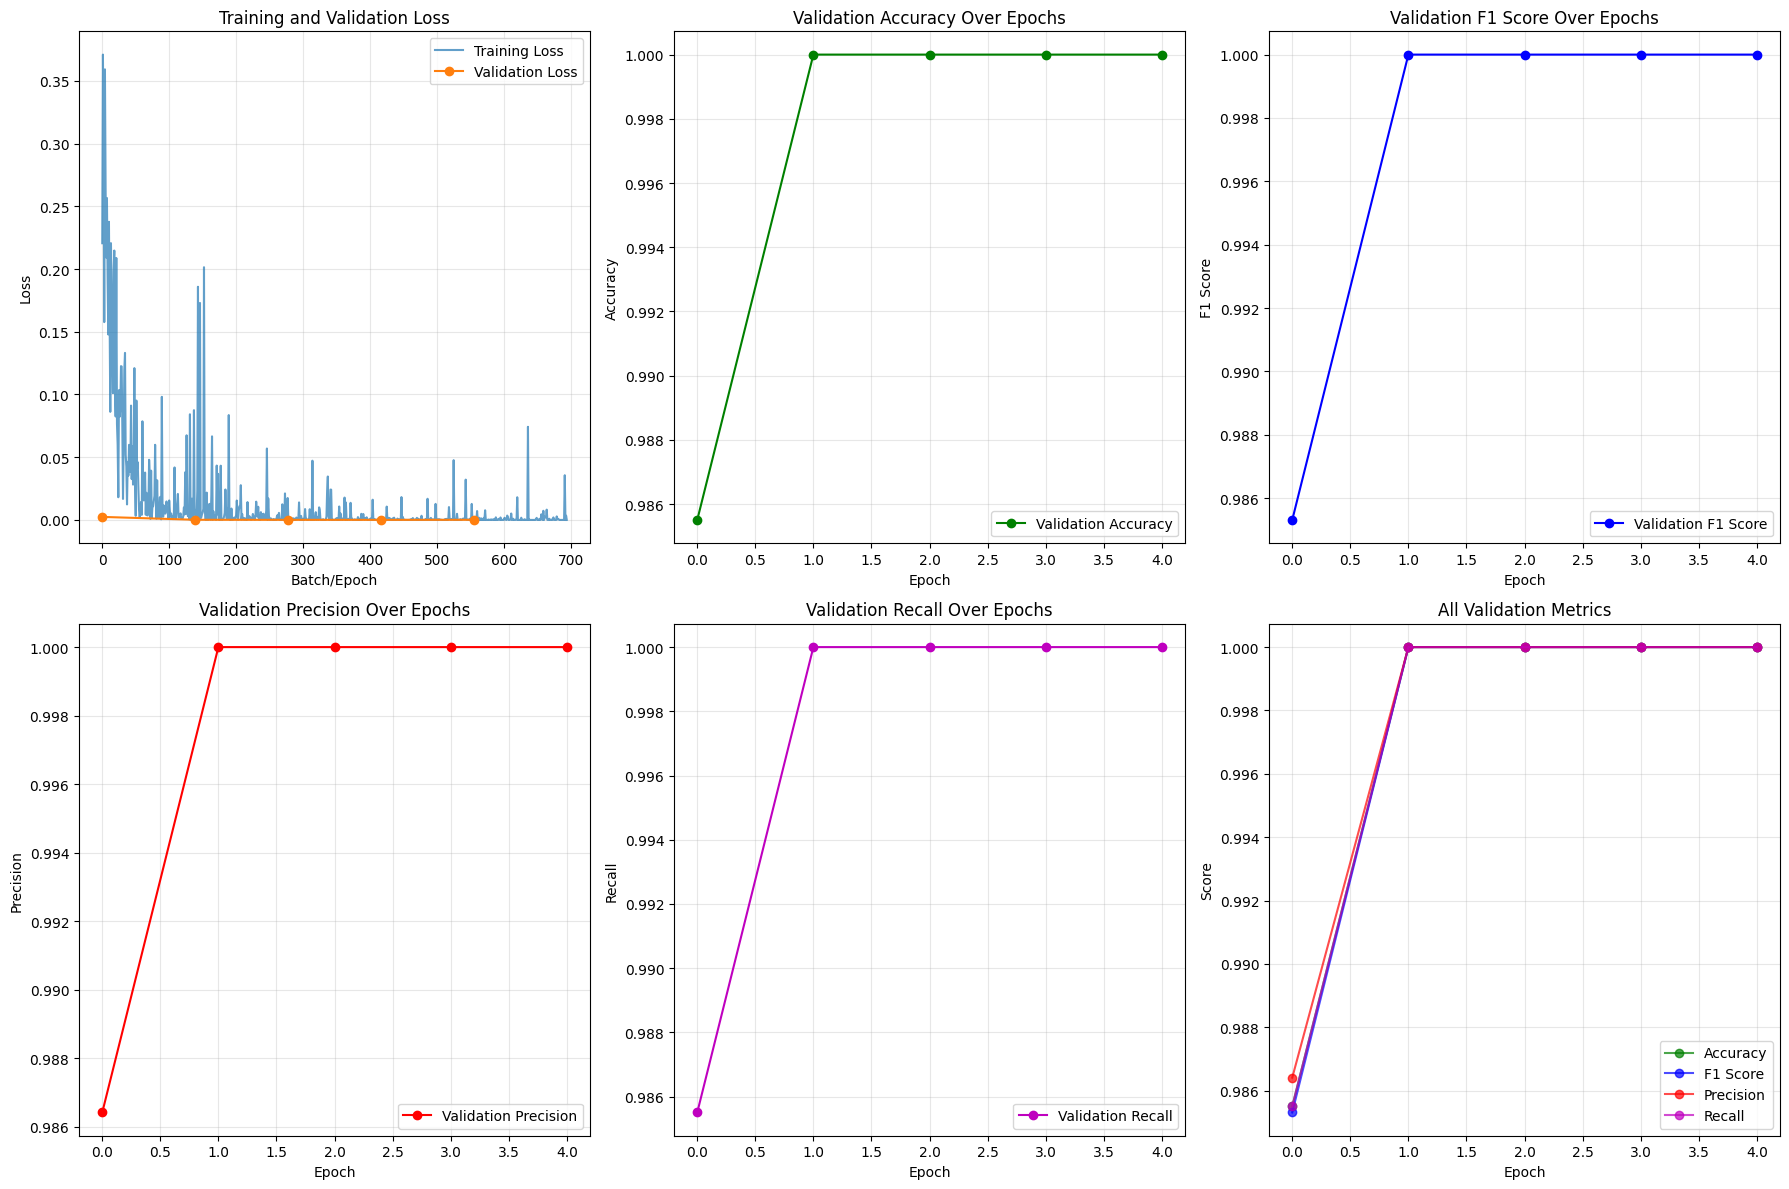

Model saved to /content/drive/MyDrive/Big_vision_task_files&folders/trained_models/timesformer_removed2.pth

DETAILED TESTING RESULTS
              precision    recall  f1-score   support

 HorseRiding     1.0000    1.0000    1.0000        21
JavelinThrow     1.0000    1.0000    1.0000        11
    LongJump     1.0000    1.0000    1.0000        14
   PoleVault     1.0000    1.0000    1.0000         8
      Skiing     1.0000    1.0000    1.0000        17

    accuracy                         1.0000        71
   macro avg     1.0000    1.0000    1.0000        71
weighted avg     1.0000    1.0000    1.0000        71


OVERALL METRICS:
Accuracy:           1.0000
Precision (weighted): 1.0000
Recall (weighted):    1.0000
F1-Score (weighted):  1.0000

CONFUSION MATRIX:
              HorseRiding  JavelinThrow  LongJump  PoleVault  Skiing
HorseRiding            21             0         0          0       0
JavelinThrow            0            11         0          0       0
LongJump           

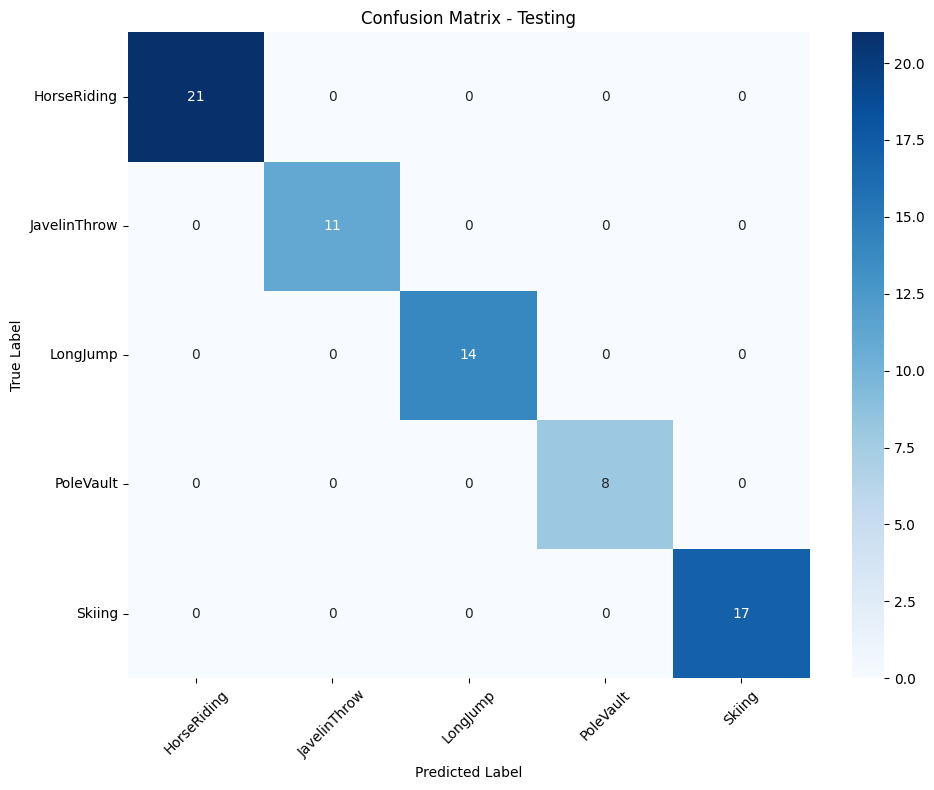


DETAILED PREDICTIONS:
Sample   True         Predicted    Correct 
---------------------------------------------
1        LongJump     LongJump     Yes     
2        LongJump     LongJump     Yes     
3        JavelinThrow JavelinThrow Yes     
4        LongJump     LongJump     Yes     
5        PoleVault    PoleVault    Yes     
6        Skiing       Skiing       Yes     
7        Skiing       Skiing       Yes     
8        HorseRiding  HorseRiding  Yes     
9        Skiing       Skiing       Yes     
10       HorseRiding  HorseRiding  Yes     
11       LongJump     LongJump     Yes     
12       JavelinThrow JavelinThrow Yes     
13       HorseRiding  HorseRiding  Yes     
14       HorseRiding  HorseRiding  Yes     
15       JavelinThrow JavelinThrow Yes     
16       Skiing       Skiing       Yes     
17       LongJump     LongJump     Yes     
18       Skiing       Skiing       Yes     
19       LongJump     LongJump     Yes     
20       Skiing       Skiing       Yes     
Result:

In [ ]:
print(f"\n{'='*60}")
print("STARTING PRUNING EXPERIMENTS (2 layers removed)")
print(f"{'='*60}")

# INITIALIZE the combined variables
all_pruning_results = []
all_pruned_models = {}
experiment = [
    {"remove": 2, "name": "Pruned Model (10 layers)"}
]

# Use the best model's data loaders and get both results and models
pruning_results_1, pruned_models_1 = experiment_with_layer_removal_selected(
    train_loader, val_loader, test_loader, experiment, device, class_names, best_model
)

# Add to combined results
all_pruning_results.extend(pruning_results_1)
all_pruned_models.update(pruned_models_1)


# Experimentation by removing first 4 layers of the model (Scroll till the end of the output to see plots & test results)


STARTING PRUNING EXPERIMENTS (4 layers removed)

EXPERIMENT: Pruned Model (8 layers)
Original model: 12 layers
Removing top 4 layers
New model: 8 layers
Layers removed: 4
Remaining encoder layers: 8
Unfrozen components: last_1_layer, classifier
Trainable params: 10,046,213 / 81,093,125 (12.4%)

Starting training for 5 epochs...
Learning rate: 0.0001
Loss function: Focal Loss
Model type: TimeSformer
Epoch 1/5, Batch 10, Loss: 0.2522
Epoch 1/5, Batch 20, Loss: 0.1549
Epoch 1/5, Batch 30, Loss: 0.1006
Epoch 1/5, Batch 40, Loss: 0.0604
Epoch 1/5, Batch 50, Loss: 0.0263
Epoch 1/5, Batch 60, Loss: 0.0525
Epoch 1/5, Batch 70, Loss: 0.0358
Epoch 1/5, Batch 80, Loss: 0.0286
Epoch 1/5, Batch 90, Loss: 0.0416
Epoch 1/5, Batch 100, Loss: 0.0134
Epoch 1/5, Batch 110, Loss: 0.0075
Epoch 1/5, Batch 120, Loss: 0.0189
Epoch 1/5, Batch 130, Loss: 0.0185
Epoch 1/5 - Val Loss: 0.0034, Val Acc: 0.9855, Val F1: 0.9856
Epoch 2/5, Batch 10, Loss: 0.0070
Epoch 2/5, Batch 20, Loss: 0.0105
Epoch 2/5, Batch 30, 

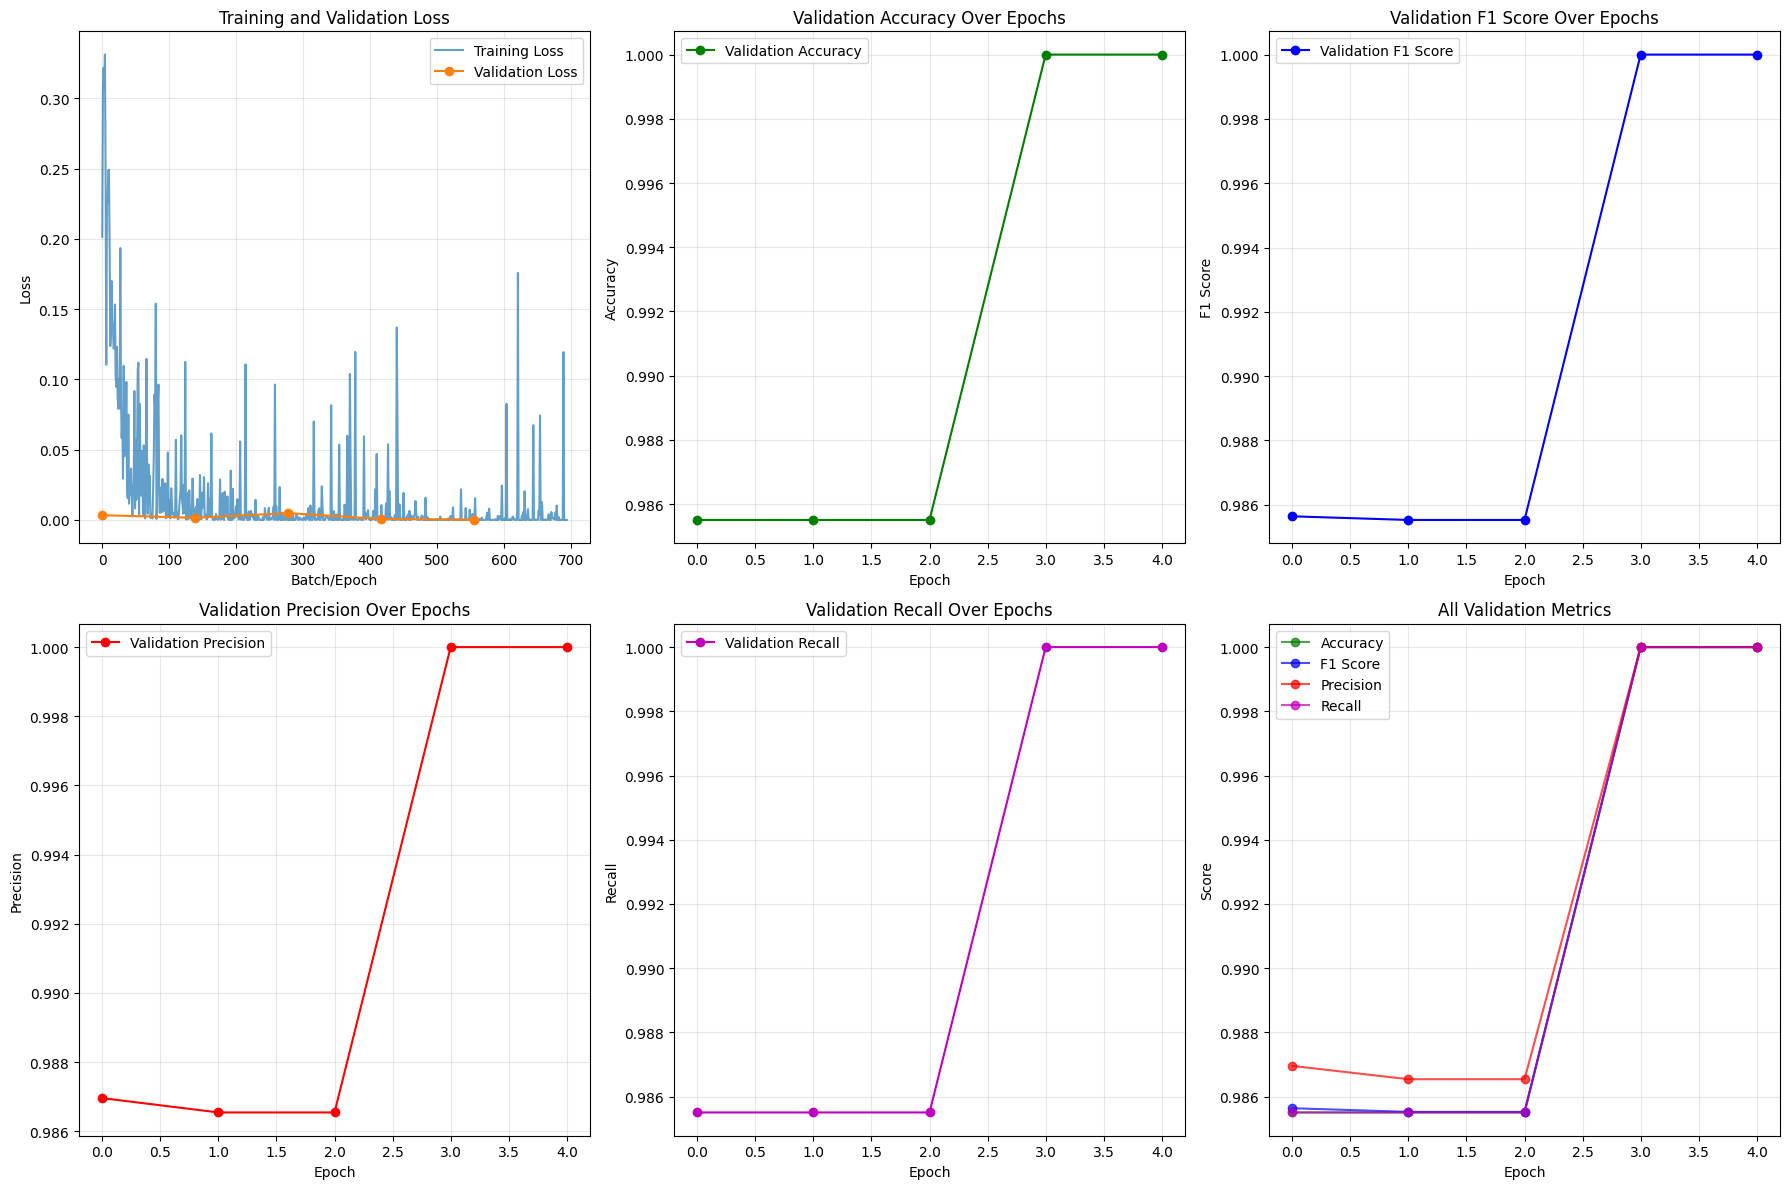

Model saved to /content/drive/MyDrive/Big_vision_task_files&folders/trained_models/timesformer_removed4.pth

DETAILED TESTING RESULTS
              precision    recall  f1-score   support

 HorseRiding     1.0000    1.0000    1.0000        21
JavelinThrow     1.0000    1.0000    1.0000        11
    LongJump     1.0000    1.0000    1.0000        14
   PoleVault     1.0000    1.0000    1.0000         8
      Skiing     1.0000    1.0000    1.0000        17

    accuracy                         1.0000        71
   macro avg     1.0000    1.0000    1.0000        71
weighted avg     1.0000    1.0000    1.0000        71


OVERALL METRICS:
Accuracy:           1.0000
Precision (weighted): 1.0000
Recall (weighted):    1.0000
F1-Score (weighted):  1.0000

CONFUSION MATRIX:
              HorseRiding  JavelinThrow  LongJump  PoleVault  Skiing
HorseRiding            21             0         0          0       0
JavelinThrow            0            11         0          0       0
LongJump           

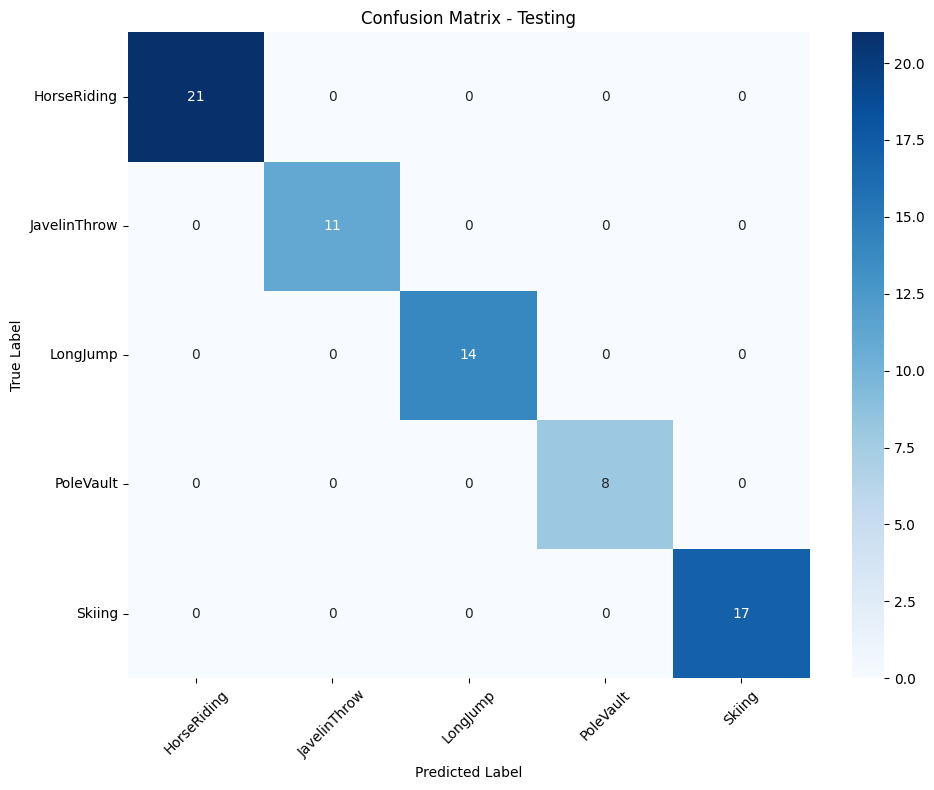


DETAILED PREDICTIONS:
Sample   True         Predicted    Correct 
---------------------------------------------
1        LongJump     LongJump     Yes     
2        LongJump     LongJump     Yes     
3        JavelinThrow JavelinThrow Yes     
4        LongJump     LongJump     Yes     
5        PoleVault    PoleVault    Yes     
6        Skiing       Skiing       Yes     
7        Skiing       Skiing       Yes     
8        HorseRiding  HorseRiding  Yes     
9        Skiing       Skiing       Yes     
10       HorseRiding  HorseRiding  Yes     
11       LongJump     LongJump     Yes     
12       JavelinThrow JavelinThrow Yes     
13       HorseRiding  HorseRiding  Yes     
14       HorseRiding  HorseRiding  Yes     
15       JavelinThrow JavelinThrow Yes     
16       Skiing       Skiing       Yes     
17       LongJump     LongJump     Yes     
18       Skiing       Skiing       Yes     
19       LongJump     LongJump     Yes     
20       Skiing       Skiing       Yes     
Result:

In [ ]:
print(f"\n{'='*60}")
print("STARTING PRUNING EXPERIMENTS (4 layers removed)")
print(f"{'='*60}")

experiment = [
    {"remove": 4, "name": "Pruned Model (8 layers)"}
]

# Use the best model's data loaders and get both results and models
pruning_results_2, pruned_models_2 = experiment_with_layer_removal_selected(
    train_loader, val_loader, test_loader, experiment, device, class_names, best_model
)

# Add to combined results
all_pruning_results.extend(pruning_results_2)
all_pruned_models.update(pruned_models_2)


# Experimentation by removing first 6 layers of the model (Scroll till the end of the output to see plots & test results)


STARTING PRUNING EXPERIMENTS (6 layers removed)

EXPERIMENT: Pruned Model (6 layers)
Original model: 12 layers
Removing top 6 layers
New model: 6 layers
Layers removed: 6
Remaining encoder layers: 6
Unfrozen components: last_1_layer, classifier
Trainable params: 10,046,213 / 61,008,389 (16.5%)

Starting training for 5 epochs...
Learning rate: 0.0001
Loss function: Focal Loss
Model type: TimeSformer
Epoch 1/5, Batch 10, Loss: 0.2661
Epoch 1/5, Batch 20, Loss: 0.1926
Epoch 1/5, Batch 30, Loss: 0.1129
Epoch 1/5, Batch 40, Loss: 0.0875
Epoch 1/5, Batch 50, Loss: 0.0644
Epoch 1/5, Batch 60, Loss: 0.0572
Epoch 1/5, Batch 70, Loss: 0.0411
Epoch 1/5, Batch 80, Loss: 0.0520
Epoch 1/5, Batch 90, Loss: 0.0377
Epoch 1/5, Batch 100, Loss: 0.0217
Epoch 1/5, Batch 110, Loss: 0.0214
Epoch 1/5, Batch 120, Loss: 0.0264
Epoch 1/5, Batch 130, Loss: 0.0172
Epoch 1/5 - Val Loss: 0.0032, Val Acc: 1.0000, Val F1: 1.0000
Epoch 2/5, Batch 10, Loss: 0.0205
Epoch 2/5, Batch 20, Loss: 0.0156
Epoch 2/5, Batch 30, 

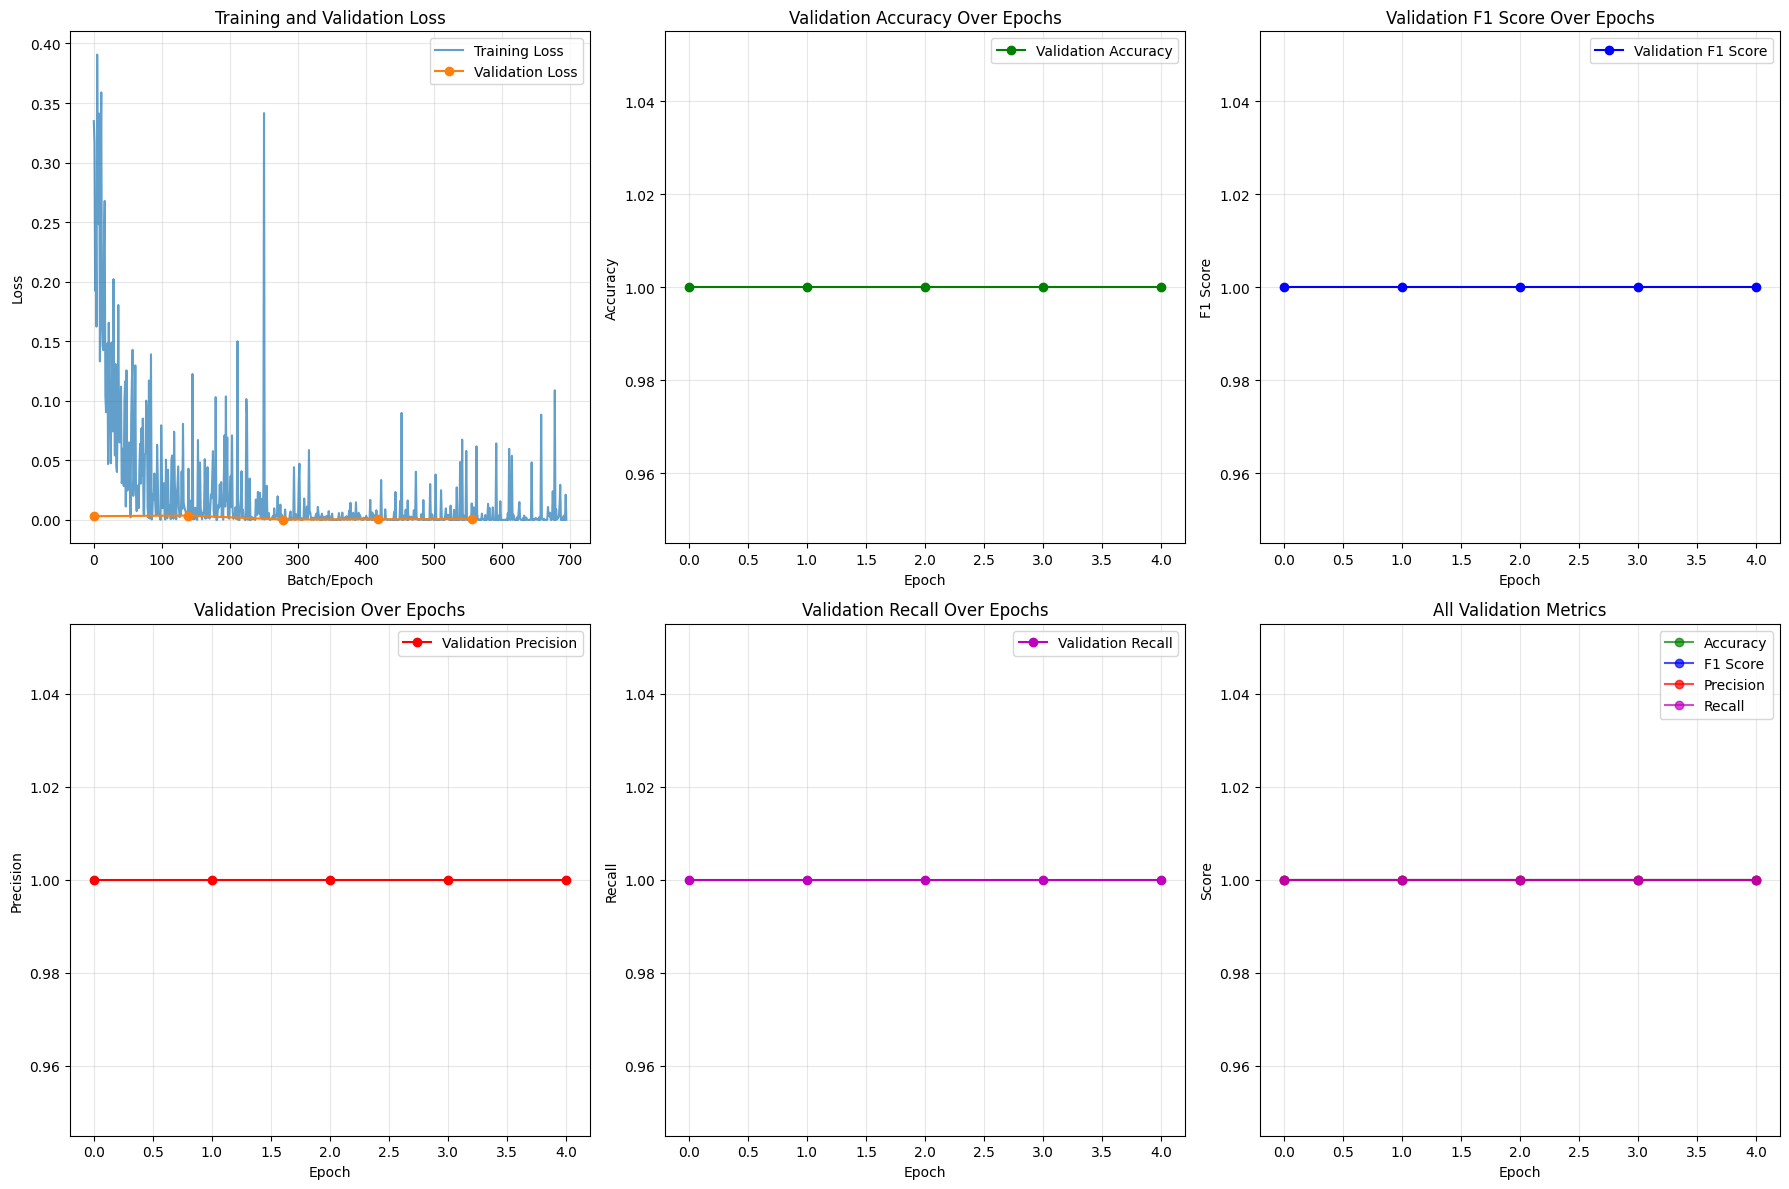

Model saved to /content/drive/MyDrive/Big_vision_task_files&folders/trained_models/timesformer_removed6.pth

DETAILED TESTING RESULTS
              precision    recall  f1-score   support

 HorseRiding     1.0000    1.0000    1.0000        21
JavelinThrow     1.0000    1.0000    1.0000        11
    LongJump     1.0000    1.0000    1.0000        14
   PoleVault     1.0000    1.0000    1.0000         8
      Skiing     1.0000    1.0000    1.0000        17

    accuracy                         1.0000        71
   macro avg     1.0000    1.0000    1.0000        71
weighted avg     1.0000    1.0000    1.0000        71


OVERALL METRICS:
Accuracy:           1.0000
Precision (weighted): 1.0000
Recall (weighted):    1.0000
F1-Score (weighted):  1.0000

CONFUSION MATRIX:
              HorseRiding  JavelinThrow  LongJump  PoleVault  Skiing
HorseRiding            21             0         0          0       0
JavelinThrow            0            11         0          0       0
LongJump           

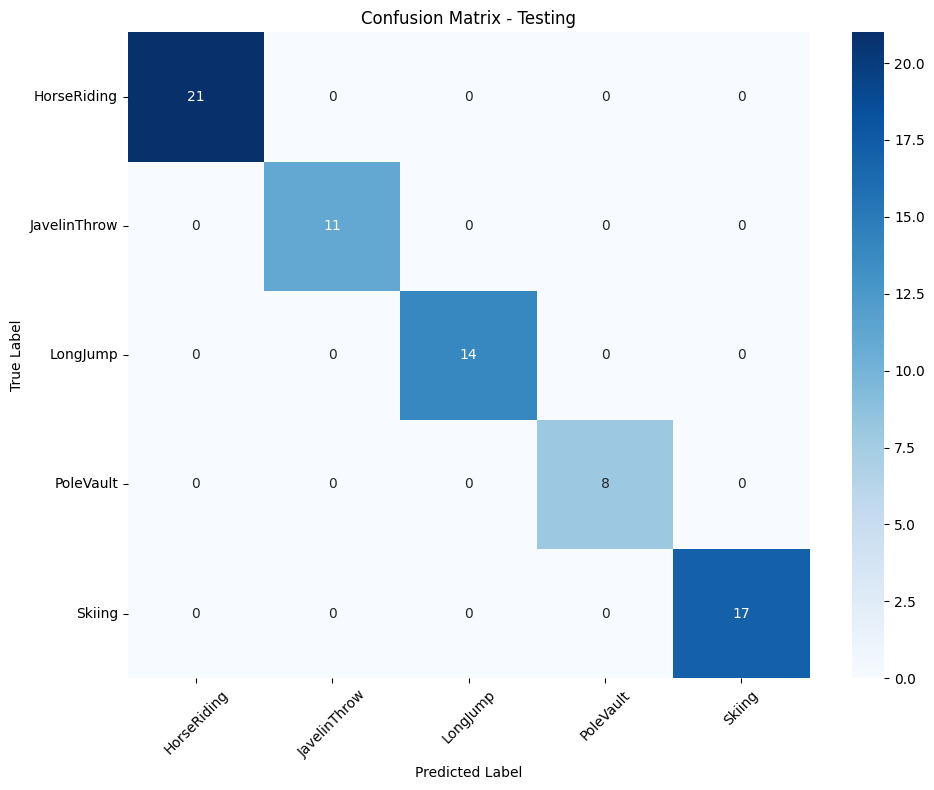


DETAILED PREDICTIONS:
Sample   True         Predicted    Correct 
---------------------------------------------
1        LongJump     LongJump     Yes     
2        LongJump     LongJump     Yes     
3        JavelinThrow JavelinThrow Yes     
4        LongJump     LongJump     Yes     
5        PoleVault    PoleVault    Yes     
6        Skiing       Skiing       Yes     
7        Skiing       Skiing       Yes     
8        HorseRiding  HorseRiding  Yes     
9        Skiing       Skiing       Yes     
10       HorseRiding  HorseRiding  Yes     
11       LongJump     LongJump     Yes     
12       JavelinThrow JavelinThrow Yes     
13       HorseRiding  HorseRiding  Yes     
14       HorseRiding  HorseRiding  Yes     
15       JavelinThrow JavelinThrow Yes     
16       Skiing       Skiing       Yes     
17       LongJump     LongJump     Yes     
18       Skiing       Skiing       Yes     
19       LongJump     LongJump     Yes     
20       Skiing       Skiing       Yes     
Result:

In [ ]:
print(f"\n{'='*60}")
print("STARTING PRUNING EXPERIMENTS (6 layers removed)")
print(f"{'='*60}")

experiment = [
    {"remove": 6, "name": "Pruned Model (6 layers)"}
]

# Use the best model's data loaders and get both results and models
pruning_results_3, pruned_models_3 = experiment_with_layer_removal_selected(
    train_loader, val_loader, test_loader, experiment, device, class_names, best_model
)

# Add to combined results
all_pruning_results.extend(pruning_results_3)
all_pruned_models.update(pruned_models_3)

# Experimentation by removing first 8 layers of the model (Scroll till the end of the output to see plots & test results)


STARTING PRUNING EXPERIMENTS (8 layers removed)

EXPERIMENT: Heavily Pruned (4 layers)
Original model: 12 layers
Removing top 8 layers
New model: 4 layers
Layers removed: 8
Remaining encoder layers: 4
Unfrozen components: last_1_layer, classifier
Trainable params: 10,046,213 / 40,923,653 (24.5%)

Starting training for 5 epochs...
Learning rate: 0.0001
Loss function: Focal Loss
Model type: TimeSformer
Epoch 1/5, Batch 10, Loss: 0.2799
Epoch 1/5, Batch 20, Loss: 0.2092
Epoch 1/5, Batch 30, Loss: 0.1617
Epoch 1/5, Batch 40, Loss: 0.1259
Epoch 1/5, Batch 50, Loss: 0.0943
Epoch 1/5, Batch 60, Loss: 0.0751
Epoch 1/5, Batch 70, Loss: 0.0516
Epoch 1/5, Batch 80, Loss: 0.0446
Epoch 1/5, Batch 90, Loss: 0.0339
Epoch 1/5, Batch 100, Loss: 0.0391
Epoch 1/5, Batch 110, Loss: 0.0382
Epoch 1/5, Batch 120, Loss: 0.0273
Epoch 1/5, Batch 130, Loss: 0.0249
Epoch 1/5 - Val Loss: 0.0382, Val Acc: 0.8841, Val F1: 0.8726
Epoch 2/5, Batch 10, Loss: 0.0115
Epoch 2/5, Batch 20, Loss: 0.0244
Epoch 2/5, Batch 30

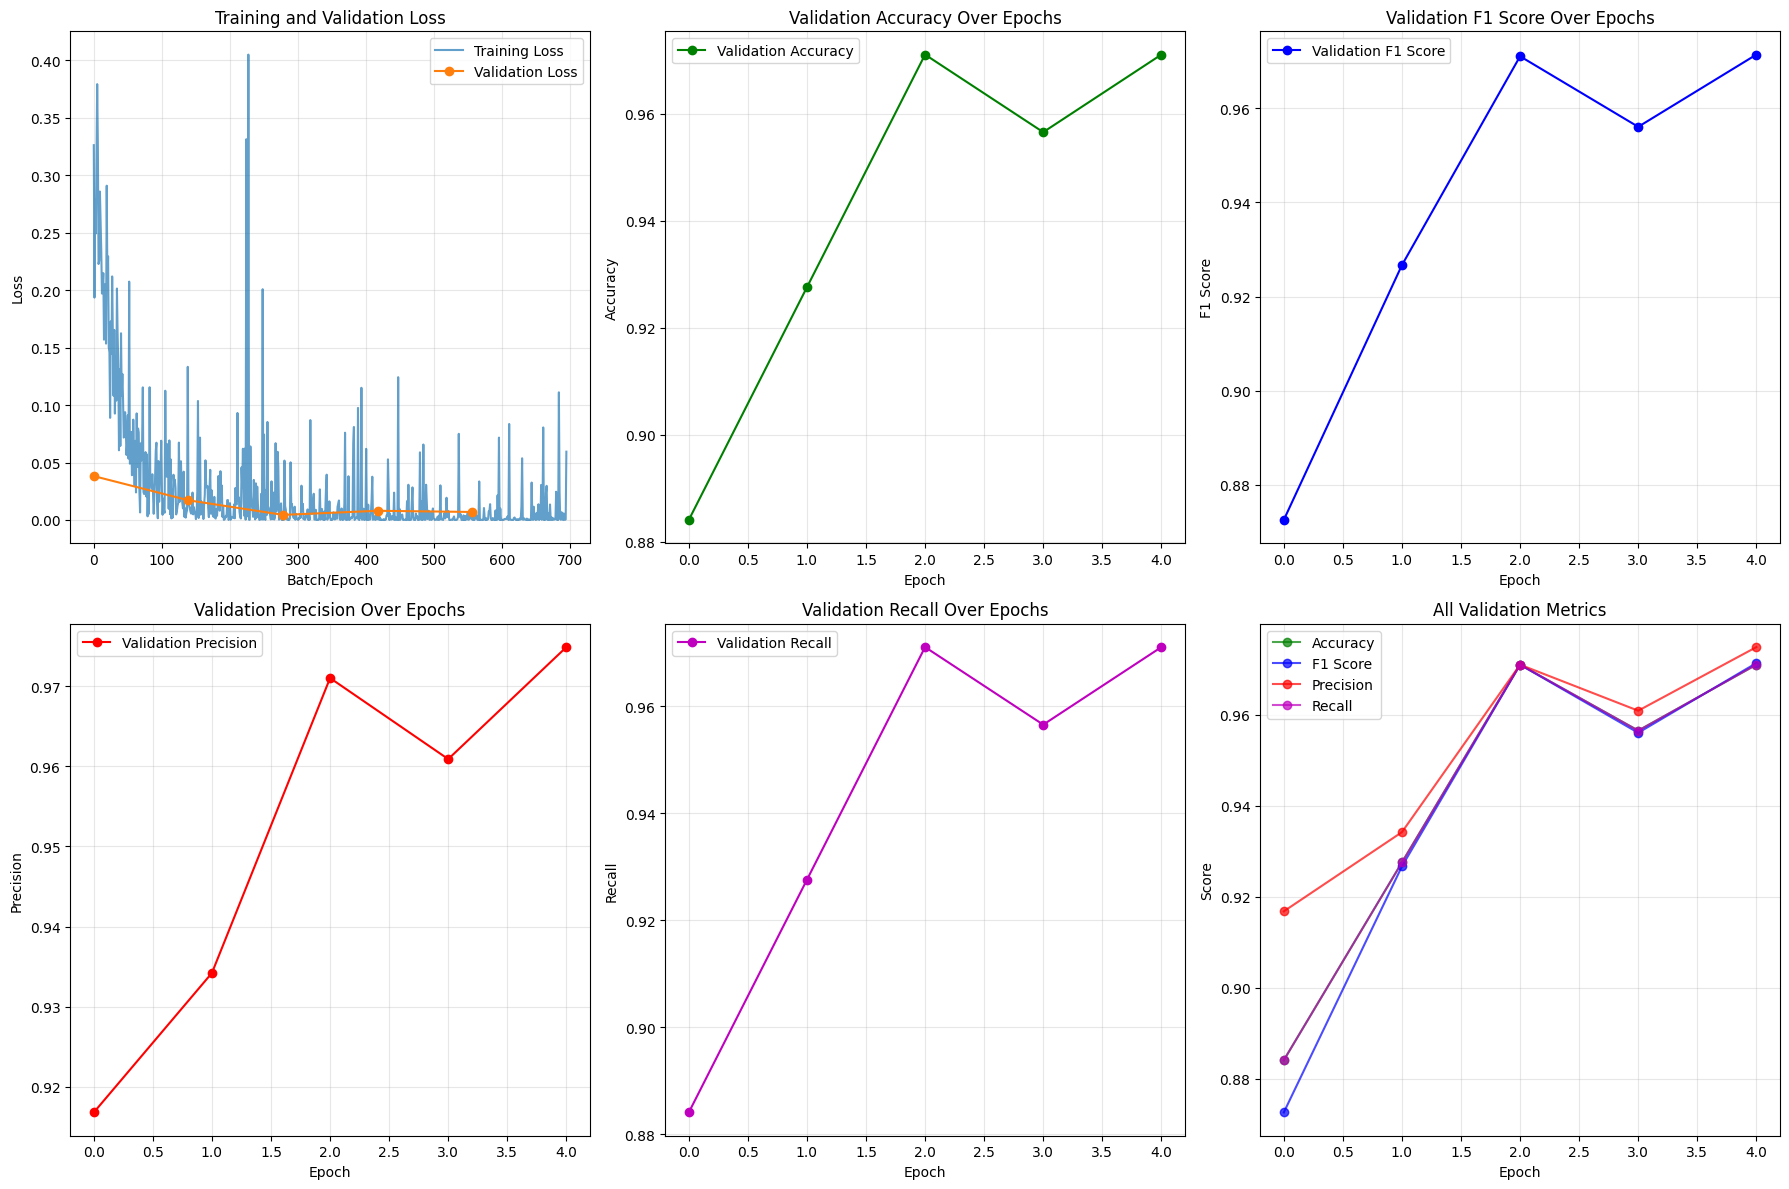

Model saved to /content/drive/MyDrive/Big_vision_task_files&folders/trained_models/timesformer_removed8.pth

DETAILED TESTING RESULTS
              precision    recall  f1-score   support

 HorseRiding     1.0000    1.0000    1.0000        21
JavelinThrow     1.0000    0.9091    0.9524        11
    LongJump     1.0000    0.7857    0.8800        14
   PoleVault     0.6667    1.0000    0.8000         8
      Skiing     1.0000    1.0000    1.0000        17

    accuracy                         0.9437        71
   macro avg     0.9333    0.9390    0.9265        71
weighted avg     0.9624    0.9437    0.9464        71


OVERALL METRICS:
Accuracy:           0.9437
Precision (weighted): 0.9624
Recall (weighted):    0.9437
F1-Score (weighted):  0.9464

CONFUSION MATRIX:
              HorseRiding  JavelinThrow  LongJump  PoleVault  Skiing
HorseRiding            21             0         0          0       0
JavelinThrow            0            10         0          1       0
LongJump           

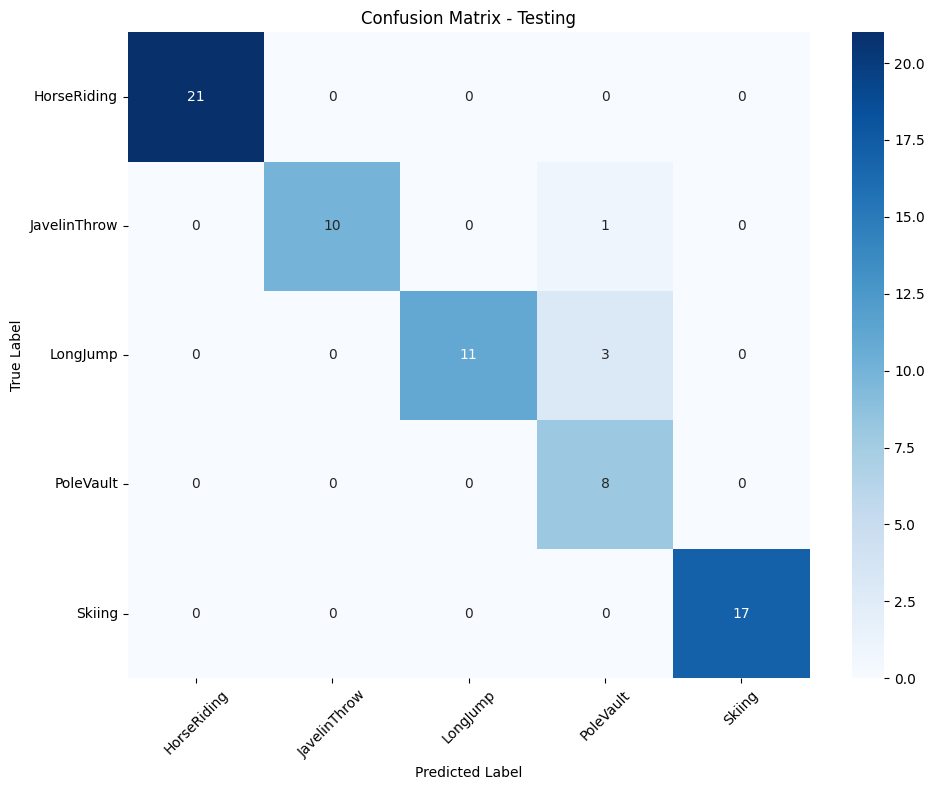


DETAILED PREDICTIONS:
Sample   True         Predicted    Correct 
---------------------------------------------
1        LongJump     LongJump     Yes     
2        LongJump     LongJump     Yes     
3        JavelinThrow JavelinThrow Yes     
4        LongJump     PoleVault    No      
5        PoleVault    PoleVault    Yes     
6        Skiing       Skiing       Yes     
7        Skiing       Skiing       Yes     
8        HorseRiding  HorseRiding  Yes     
9        Skiing       Skiing       Yes     
10       HorseRiding  HorseRiding  Yes     
11       LongJump     LongJump     Yes     
12       JavelinThrow JavelinThrow Yes     
13       HorseRiding  HorseRiding  Yes     
14       HorseRiding  HorseRiding  Yes     
15       JavelinThrow JavelinThrow Yes     
16       Skiing       Skiing       Yes     
17       LongJump     PoleVault    No      
18       Skiing       Skiing       Yes     
19       LongJump     LongJump     Yes     
20       Skiing       Skiing       Yes     
Result:

In [ ]:
print(f"\n{'='*60}")
print("STARTING PRUNING EXPERIMENTS (8 layers removed)")
print(f"{'='*60}")

experiment = [
    {"remove": 8, "name": "Heavily Pruned (4 layers)"}
]

# Use the best model's data loaders and get both results and models
pruning_results_4, pruned_models_4 = experiment_with_layer_removal_selected(
    train_loader, val_loader, test_loader, experiment, device, class_names, best_model
)

# Add to combined results
all_pruning_results.extend(pruning_results_4)
all_pruned_models.update(pruned_models_4)

# FINALIZE the variables for comprehensive analysis
pruning_results = all_pruning_results
pruned_models = all_pruned_models


# Now, finally a comprehensive result is displayed

This cell defines the function which will compare all the models I have worked with till now (including the original 2 model and the 4 pruned models).

Comprehensive plots are also plotted which help us visualize the results and determine which is the better model and which model can generalize better on the unseen data.

In [ ]:
def create_comprehensive_results_analysis(timesformer_results, custom_results, pruning_results,
                                        timesformer_model, custom_model, pruned_models,
                                        youtube_path=None, class_names=None, device=None):
    """Complete comprehensive results analysis with essential visualizations - TimeSformer vs Custom + Pruned"""

    print(f"\n{'='*80}")
    print("COMPREHENSIVE FINAL RESULTS ANALYSIS - ALL MODELS")
    print(f"{'='*80}")

    # Create final summary table
    final_results = []

    # Add TimeSformer and Custom transformer results
    final_results.append({
        'Model': 'TimeSformer',
        'Accuracy': timesformer_results['test_accuracy'],
        'F1 Score': timesformer_results['test_f1'],
        'Precision': timesformer_results['test_precision'],
        'Recall': timesformer_results['test_recall'],
        'Notes': 'Pre-trained TimeSformer model fine-tuned'
    })

    final_results.append({
        'Model': 'Custom Transformer',
        'Accuracy': custom_results['test_accuracy'],
        'F1 Score': custom_results['test_f1'],
        'Precision': custom_results['test_precision'],
        'Recall': custom_results['test_recall'],
        'Notes': 'Custom transformer trained from scratch'
    })

    # Add all pruning results
    for result in pruning_results:
        final_results.append({
            'Model': result['name'],
            'Accuracy': result['test_accuracy'],
            'F1 Score': result['test_f1'],
            'Precision': result['test_precision'],
            'Recall': result['test_recall'],
            'Notes': f'{result["layers_removed"]} layers removed, {result.get("compression_ratio", "N/A")}x compression'
        })

    # Create final summary table
    final_df = pd.DataFrame(final_results)
    total_models = len(final_results)

    print(f"\nFINAL PERFORMANCE SUMMARY (ALL {total_models} MODELS):")
    print("="*120)
    print(final_df.to_string(index=False, float_format='%.4f'))

    # Calculate model comparisons
    timesformer_f1 = timesformer_results['test_f1']
    custom_f1 = custom_results['test_f1']
    model_comparison = custom_f1 - timesformer_f1

    # Find best pruned model
    best_pruned_f1 = max([r['test_f1'] for r in pruning_results]) if pruning_results else 0
    overall_best_f1 = max(f1_scores := final_df['F1 Score'].tolist())

    print(f"\nCOMPREHENSIVE KEY INSIGHTS:")
    print("-" * 60)
    print(f"1. Model comparison: Custom vs TimeSformer = {model_comparison:+.4f} F1 difference")
    print(f"2. TimeSformer performance: {timesformer_f1:.4f} F1 (pre-trained advantage)")
    print(f"3. Custom transformer performance: {custom_f1:.4f} F1 (trained from scratch)")
    print(f"4. Best overall model: {final_df.loc[final_df['F1 Score'].idxmax(), 'Model']}")
    print(f"5. Best pruned model F1: {best_pruned_f1:.4f}")
    print(f"6. Pruning effectiveness: {len([r for r in pruning_results if r['test_f1'] > min(timesformer_f1, custom_f1)])} out of {len(pruning_results)} pruned models beat weaker main model")
    print(f"7. Total models analyzed: {total_models} (2 main + {len(pruning_results)} pruned)")

    # Create ONLY 2 essential visualizations
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    models = final_df['Model'].tolist()
    f1_scores = final_df['F1 Score'].tolist()
    accuracies = final_df['Accuracy'].tolist()

    # Color coding for all models (2 main + pruned)
    colors = []
    for model in models:
        if 'TimeSformer' in model:
            colors.append('lightskyblue')
        elif 'Custom Transformer' in model:
            colors.append('lightgreen')
        elif 'Pruned Model (10' in model:  # 10 layers remaining (2 removed)
            colors.append('mediumpurple')
        elif 'Pruned Model (8' in model:   # 8 layers remaining (4 removed)
            colors.append('plum')
        elif 'Pruned Model (6' in model:   # 6 layers remaining (6 removed)
            colors.append('orchid')
        elif 'Heavily Pruned' in model:    # 4 layers remaining (8 removed)
            colors.append('violet')
        else:
            colors.append('lightgray')

    # 1. F1 Score comparison with model reference lines
    bars1 = axes[0].bar(range(len(models)), f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    axes[0].set_title(f'F1 Score Comparison - All {total_models} Models', fontweight='bold', fontsize=14)
    axes[0].set_ylabel('F1 Score', fontweight='bold')
    axes[0].set_xticks(range(len(models)))
    axes[0].set_xticklabels([m[:15] + "..." if len(m) > 15 else m for m in models],
                           rotation=45, ha='right', fontsize=10)

    # Add reference lines for main models
    axes[0].axhline(y=timesformer_f1, color='blue', linestyle='--', alpha=0.8,
                   linewidth=2, label=f'TimeSformer: {timesformer_f1:.3f}')
    axes[0].axhline(y=custom_f1, color='green', linestyle='--', alpha=0.8,
                   linewidth=2, label=f'Custom: {custom_f1:.3f}')
    axes[0].legend(fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, max(f1_scores) * 1.15)

    # Add F1 score labels on bars
    for bar, f1 in zip(bars1, f1_scores):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{f1:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    # 2. Model comparison vs best main model
    best_main_f1 = max(timesformer_f1, custom_f1)
    improvements = [f1 - best_main_f1 for f1 in f1_scores]
    bar_colors = ['darkred' if i < -0.05 else 'darkgreen' if i > 0.02 else 'orange' for i in improvements]
    bars2 = axes[1].bar(range(len(models)), improvements, color=bar_colors, alpha=0.8, edgecolor='black')
    axes[1].set_title(f'Performance vs Best Main Model (F1: {best_main_f1:.3f})', fontweight='bold', fontsize=14)
    axes[1].set_ylabel('F1 Difference', fontweight='bold')
    axes[1].set_xticks(range(len(models)))
    axes[1].set_xticklabels([m[:15] + "..." if len(m) > 15 else m for m in models],
                           rotation=45, ha='right', fontsize=10)
    axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.6, linewidth=2)
    axes[1].axhline(y=0.02, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Good (+0.02)')
    axes[1].axhline(y=-0.05, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Poor (-0.05)')
    axes[1].legend(fontsize=12)
    axes[1].grid(True, alpha=0.3)

    # Add improvement labels
    for bar, imp in zip(bars2, improvements):
        axes[1].text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + (0.01 if imp >= 0 else -0.02),
                    f'{imp:+.3f}', ha='center',
                    va='bottom' if imp >= 0 else 'top', fontweight='bold', fontsize=10)

    plt.suptitle(f'Model Performance Analysis - Test Set Results ({total_models} Models Total)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # COMPREHENSIVE YOUTUBE TESTING - ALL MODELS
    youtube_results = None
    youtube_df = None

    if youtube_path and class_names and device:
        print(f"\n{'='*80}")
        print(f"YOUTUBE TESTING - ALL {total_models} MODELS (2 MAIN + {len(pruning_results)} PRUNED)")
        print(f"{'='*80}")

        # Build comprehensive models dictionary for YouTube testing
        all_models_for_youtube = {
            'TimeSformer': (timesformer_model, True),      # (model, is_timesformer)
            'Custom Transformer': (custom_model, False)    # (model, is_timesformer)
        }

        # Add all pruned models (assuming they're TimeSformer-based)
        if pruned_models:
            print(f"Adding {len(pruned_models)} pruned models to YouTube testing...")
            for name, model in pruned_models.items():
                all_models_for_youtube[name] = (model, True)  # Pruned models are TimeSformer-based

        print(f"Testing all {len(all_models_for_youtube)} models on YouTube videos:")
        for i, model_name in enumerate(all_models_for_youtube.keys(), 1):
            print(f"  {i}. {model_name}")

        # Test ALL models on YouTube videos
        youtube_results = test_multiple_models_on_youtube(
            all_models_for_youtube, device, class_names, youtube_path
        )

        if youtube_results:
            # Create YouTube summary table
            youtube_summary_data = []
            for model_name, results in youtube_results.items():
                if results:
                    correct = sum(1 for r in results if r['is_correct'])
                    total = len(results)
                    accuracy = correct / total
                    avg_confidence = np.mean([r['confidence'] for r in results])

                    youtube_summary_data.append({
                        'Model': model_name,
                        'Videos Tested': total,
                        'Correct Predictions': correct,
                        'YouTube Accuracy': accuracy,
                        'Average Confidence': avg_confidence
                    })

            youtube_df = pd.DataFrame(youtube_summary_data)
            print("\n" + "="*120)
            print(f"YOUTUBE TESTING SUMMARY (ALL {total_models} MODELS):")
            print("="*120)
            print(youtube_df.to_string(index=False, float_format='%.4f'))

            # Create essential YouTube comparison chart
            create_essential_youtube_comparison_all_models(youtube_results, final_df, youtube_df)

            # YouTube vs Test Set Comparison Table
            print(f"\nYOUTUBE vs TEST SET COMPARISON (ALL {total_models} MODELS):")
            print("-" * 100)
            print(f"{'Model':<30} {'Test Acc':<10} {'YouTube Acc':<13} {'Gap':<10} {'Generalization':<15}")
            print("-" * 100)

            for _, row in youtube_df.iterrows():
                model_name = row['Model']
                youtube_acc = row['YouTube Accuracy']

                # Find corresponding test accuracy
                test_acc = None
                for _, final_row in final_df.iterrows():
                    if final_row['Model'] == model_name:
                        test_acc = final_row['Accuracy']
                        break

                if test_acc is not None:
                    generalization_gap = test_acc - youtube_acc
                    if abs(generalization_gap) < 0.05:
                        status = "Excellent"
                    elif abs(generalization_gap) < 0.10:
                        status = "Good"
                    elif abs(generalization_gap) < 0.20:
                        status = "Fair"
                    else:
                        status = "Poor"

                    print(f"{model_name[:29]:<30} {test_acc:<10.3f} {youtube_acc:<13.3f} {generalization_gap:+<10.3f} {status:<15}")

            # Find best YouTube performer
            best_youtube_model = youtube_df.loc[youtube_df['YouTube Accuracy'].idxmax()]
            print(f"\nBEST YOUTUBE PERFORMER (out of {total_models} models):")
            print(f"Model: {best_youtube_model['Model']}")
            print(f"YouTube Accuracy: {best_youtube_model['YouTube Accuracy']:.4f}")
            print(f"Videos Tested: {best_youtube_model['Videos Tested']}")

        # Create comprehensive summary statistics
        summary_stats = {
            'experiment_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'total_models_tested': total_models,
            'main_models': 2,
            'pruned_models': len(pruning_results),
            'timesformer_f1': timesformer_f1,
            'custom_f1': custom_f1,
            'best_f1': max(f1_scores),
            'best_pruned_f1': best_pruned_f1,
            'overall_best_model': final_df.loc[final_df['F1 Score'].idxmax(), 'Model'],
            'model_comparison_advantage': 'Custom' if custom_f1 > timesformer_f1 else 'TimeSformer',
            'custom_vs_timesformer_diff': model_comparison,
            'pruning_models_beat_weaker': len([r for r in pruning_results if r['test_f1'] > min(timesformer_f1, custom_f1)]),
            'youtube_testing_completed': youtube_results is not None,
            'best_youtube_model': best_youtube_model['Model'] if youtube_results else None,
            'best_youtube_accuracy': float(best_youtube_model['YouTube Accuracy']) if youtube_results else None
        }

    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE ANALYSIS COMPLETE - ALL {total_models} MODELS")
    print(f"{'='*80}")
    print(f"Total models analyzed: {total_models} (2 main + {len(pruning_results)} pruned)")
    if youtube_results:
        print(f"YouTube testing completed on: {len(youtube_results)} models")
        print(f"Best YouTube performer: {best_youtube_model['Model']} ({best_youtube_model['YouTube Accuracy']:.3f})")

    return final_df, youtube_df


def create_essential_youtube_comparison_all_models(youtube_results, final_df, youtube_df):
    """Create ONE essential YouTube comparison visualization for all models"""

    print(f"\nCreating essential YouTube vs Test Set comparison for all models...")

    # Extract data for comparison
    model_names = []
    youtube_accuracies = []
    test_accuracies = []
    model_types = []

    for _, row in youtube_df.iterrows():
        model_name = row['Model']
        youtube_acc = row['YouTube Accuracy']

        # Get corresponding test accuracy
        test_acc = None
        model_type = ""

        for _, final_row in final_df.iterrows():
            if final_row['Model'] == model_name:
                test_acc = final_row['Accuracy']
                if 'TimeSformer' in model_name and 'Custom' not in model_name:
                    model_type = "TimeSformer"
                elif 'Custom' in model_name:
                    model_type = "Custom"
                else:
                    model_type = "Pruned"
                break

        if test_acc is not None:
            model_names.append(model_name[:18] + "..." if len(model_name) > 18 else model_name)
            youtube_accuracies.append(youtube_acc)
            test_accuracies.append(test_acc)
            model_types.append(model_type)

    # Create ONE essential comparison chart for all models
    fig, ax = plt.subplots(1, 1, figsize=(18, 10))

    # Test vs YouTube Accuracy Comparison with generalization gap indicators
    x = np.arange(len(model_names))
    width = 0.35

    bars1 = ax.bar(x - width/2, test_accuracies, width, label='Test Set Accuracy',
                   color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, youtube_accuracies, width, label='YouTube Accuracy',
                   color='indianred', alpha=0.8)

    # Add generalization gap indicators with lines
    for i, (test_acc, youtube_acc) in enumerate(zip(test_accuracies, youtube_accuracies)):
        gap = test_acc - youtube_acc
        gap_color = 'green' if abs(gap) < 0.05 else 'orange' if abs(gap) < 0.10 else 'red'

        # Draw line connecting test and youtube bars
        ax.plot([x[i] - width/2 + width/2, x[i] + width/2 - width/2],
                [test_acc, youtube_acc], color=gap_color, linewidth=2, alpha=0.7)

        # Add gap text above bars
        max_height = max(test_acc, youtube_acc)
        ax.text(x[i], max_height + 0.03, f'{gap:+.3f}', ha='center', va='bottom',
                fontweight='bold', fontsize=9, color=gap_color)

    ax.set_title(f'Test Set vs YouTube Generalization - All Models (2 Main + Pruned)\n(Lines show generalization gap: Green=Excellent, Orange=Good, Red=Poor)',
                 fontweight='bold', fontsize=14)
    ax.set_ylabel('Accuracy', fontweight='bold', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, max(max(test_accuracies), max(youtube_accuracies)) * 1.15)

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()


COMPREHENSIVE FINAL RESULTS ANALYSIS - ALL MODELS

FINAL PERFORMANCE SUMMARY (ALL 6 MODELS):
                    Model  Accuracy  F1 Score  Precision  Recall                                    Notes
              TimeSformer    1.0000    1.0000     1.0000  1.0000 Pre-trained TimeSformer model fine-tuned
       Custom Transformer    0.2958    0.2203     0.1771  0.2958  Custom transformer trained from scratch
 Pruned Model (10 layers)    1.0000    1.0000     1.0000  1.0000       2 layers removed, N/Ax compression
  Pruned Model (8 layers)    1.0000    1.0000     1.0000  1.0000       4 layers removed, N/Ax compression
  Pruned Model (6 layers)    1.0000    1.0000     1.0000  1.0000       6 layers removed, N/Ax compression
Heavily Pruned (4 layers)    0.9437    0.9464     0.9624  0.9437       8 layers removed, N/Ax compression

COMPREHENSIVE KEY INSIGHTS:
------------------------------------------------------------
1. Model comparison: Custom vs TimeSformer = -0.7797 F1 difference
2. Time

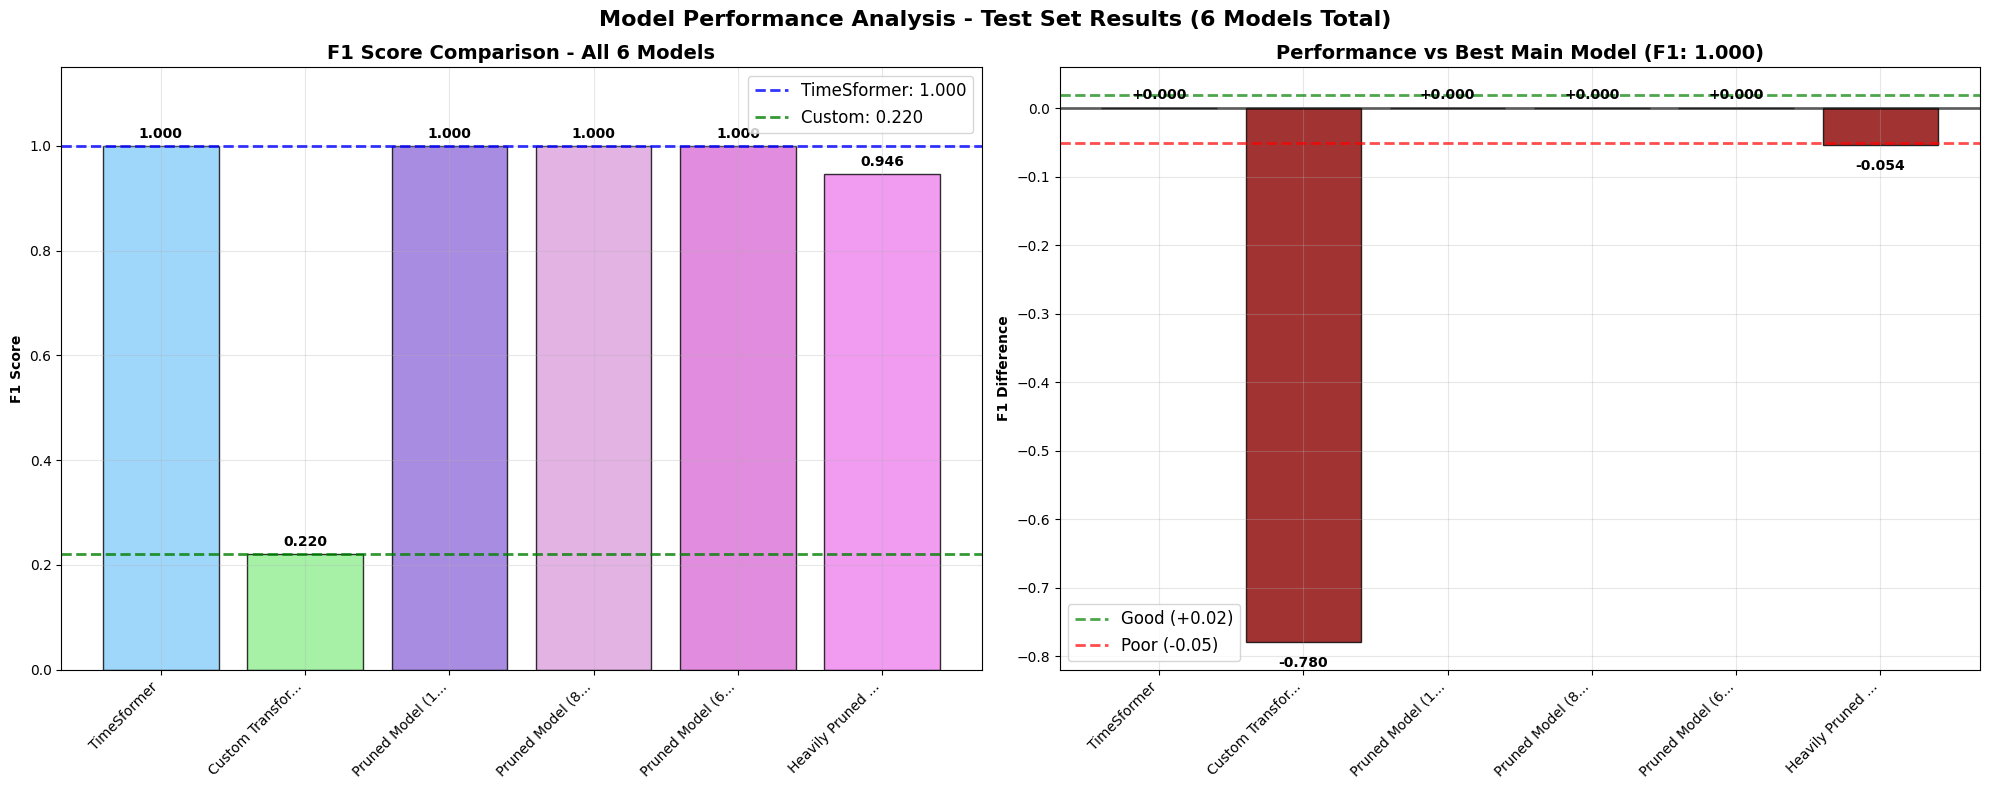


YOUTUBE TESTING - ALL 6 MODELS (2 MAIN + 4 PRUNED)
Adding 4 pruned models to YouTube testing...
Testing all 6 models on YouTube videos:
  1. TimeSformer
  2. Custom Transformer
  3. Pruned Model (10 layers)
  4. Pruned Model (8 layers)
  5. Pruned Model (6 layers)
  6. Heavily Pruned (4 layers)

COMPREHENSIVE YOUTUBE TESTING - ALL MODELS
Testing 6 models on YouTube videos
Models: ['TimeSformer', 'Custom Transformer', 'Pruned Model (10 layers)', 'Pruned Model (8 layers)', 'Pruned Model (6 layers)', 'Heavily Pruned (4 layers)']
Found class folders: ['HorseRiding', 'JavelinThrow', 'LongJump', 'Skiing', 'PoleVault']
Total videos to test: 25

Testing TimeSformer (TimeSformer)...
------------------------------------------------------------
  Progress: 5/25 videos
  Progress: 10/25 videos
  Progress: 15/25 videos
  Progress: 20/25 videos
  Progress: 25/25 videos
  TimeSformer accuracy: 0.960 (24/25)

Testing Custom Transformer (Custom Transformer)...
-----------------------------------------

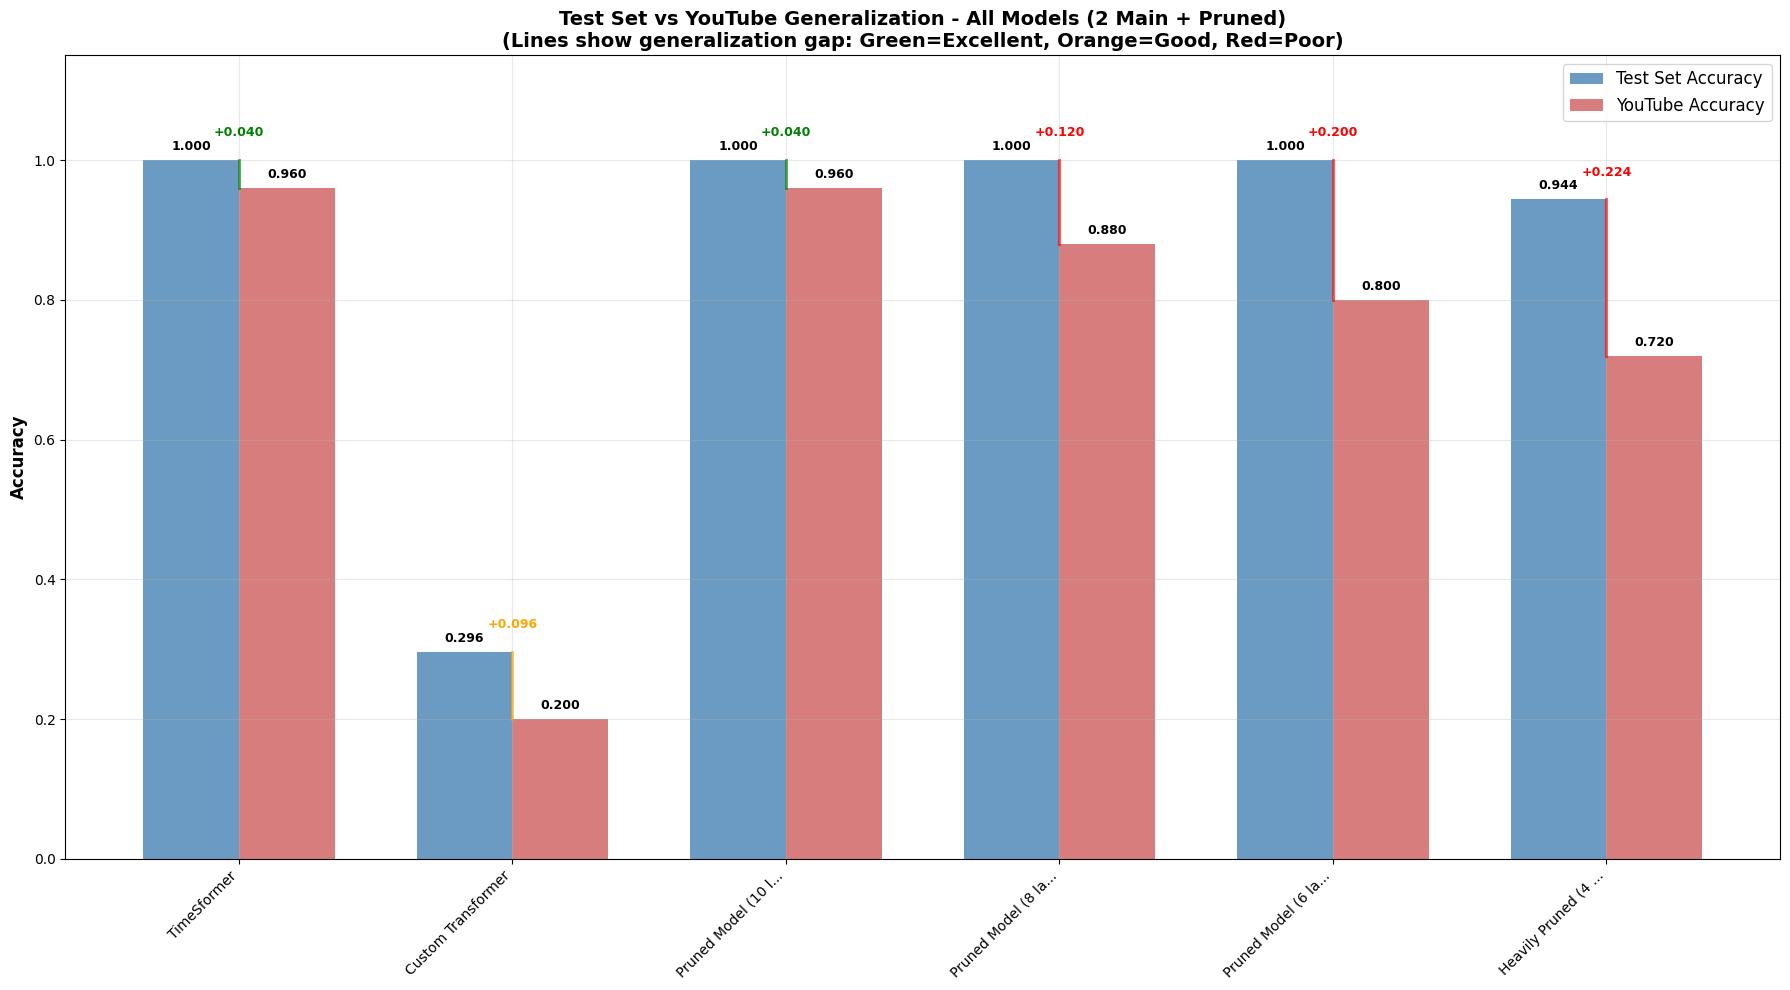


YOUTUBE vs TEST SET COMPARISON (ALL 6 MODELS):
----------------------------------------------------------------------------------------------------
Model                          Test Acc   YouTube Acc   Gap        Generalization 
----------------------------------------------------------------------------------------------------
TimeSformer                    1.000      0.960         0.040+++++ Excellent      
Custom Transformer             0.296      0.200         0.096+++++ Good           
Pruned Model (10 layers)       1.000      0.960         0.040+++++ Excellent      
Pruned Model (8 layers)        1.000      0.880         0.120+++++ Fair           
Pruned Model (6 layers)        1.000      0.800         0.200+++++ Fair           
Heavily Pruned (4 layers)      0.944      0.720         0.224+++++ Poor           

BEST YOUTUBE PERFORMER (out of 6 models):
Model: TimeSformer
YouTube Accuracy: 0.9600
Videos Tested: 25

COMPREHENSIVE ANALYSIS COMPLETE - ALL 6 MODELS
Total models ana

In [ ]:
# Usage - Call this function after you have all the required components
final_results_df, youtube_results_df = create_comprehensive_results_analysis(
    timesformer_results=timesformer_results,       # Results from TimeSformer model
    custom_results=custom_results,                 # Results from Custom Transformer model
    pruning_results=pruning_results,               # List of pruning experiment results
    timesformer_model=model,                       # Your trained TimeSformer model object
    custom_model=custom_model,                     # Your trained Custom Transformer model object
    pruned_models=pruned_models,                   # Dictionary of pruned models from pruning experiments
    youtube_path=youtube_path if 'youtube_path' in locals() else None,
    class_names=class_names,
    device=device
)


# Conclusion (for the extra work)
- My suspicion that we could prune the layers and use this simpler model as well to make predictions was right.
- Even after pruning 2 encoder layers, the model gave almost similar performance to the original TimeSformer model.
- But after that, the performance started decreasing which indicates the nature of the trained model. We could maybe train these pruned models for more epochs and with more variety of data and achieve better results.
- We could probably unfreeze more layers and let them train on the custom data as well to improve the pruned model's performance.

## Final code to make predictions on a video by specifying the model

In [ ]:
def predict_and_display_video(video_path, actual_class=None, model=None, class_names=None, device=None,
                             model_name="Best Model", is_timesformer=True, num_frames=8, display_grid_size=(2, 4)):
    if model is None:
        # Use the best performing model by default (from selected_model_info if available)
        if 'selected_model_info' in globals():
            model = selected_model_info['model']
            model_name = selected_model_info['name']
            is_timesformer = selected_model_info['is_timesformer']
        elif 'model' in globals():
            model = globals()['model']
            model_name = "TimeSformer"
            is_timesformer = True
        else:
            print("ERROR: No trained model available!")
            return None

    if class_names is None:
        if 'class_names' in globals():
            class_names = globals()['class_names']
        else:
            print("ERROR: Class names not available!")
            return None

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Analyzing video: {os.path.basename(video_path)}")
    print(f"Using model: {model_name}")
    print(f"Model type: {'TimeSformer' if is_timesformer else 'Custom Transformer'}")
    print(f"Device: {device}")

    # Create a VideoDataset instance for frame extraction (without augmentation)
    temp_dataset = VideoDataset(root_dir=CONFIG['root_dir'], num_frames=num_frames, augment=False)

    # Extract frames using VideoDataset method
    frames = temp_dataset._extract_frames_with_augmentation(video_path)
    if frames is None:
        return None

    # Get video info for frame timestamps
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()

    # Create frame info
    frame_info = []
    for i in range(len(frames)):
        frame_idx = int(i * (total_frames - 1) / (len(frames) - 1)) if len(frames) > 1 else 0
        timestamp = frame_idx / fps if fps > 0 else 0
        frame_info.append({
            'frame_num': frame_idx,
            'timestamp': timestamp
        })

    # Prepare frames for model prediction
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    tensor_frames = []
    for frame in frames:
        pil_frame = Image.fromarray(frame)
        tensor_frame = transform(pil_frame)
        tensor_frames.append(tensor_frame)

    video_tensor = torch.stack(tensor_frames, dim=0).unsqueeze(0)  # Add batch dimension
    video_tensor = video_tensor.to(device, non_blocking=True)

    # Make prediction - WORKS FOR BOTH MODEL TYPES
    model.eval()
    with torch.no_grad():
        if is_timesformer:
            # TimeSformer format
            outputs = model(pixel_values=video_tensor)
            logits = outputs.logits
        else:
            # Custom transformer format
            logits = model(video_tensor)

        probabilities = F.softmax(logits, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)
        predicted_class = class_names[predicted_idx.item()]
        confidence_score = confidence.item()

    # Create visualization
    rows, cols = display_grid_size
    fig = plt.figure(figsize=(20, 12))

    # Create main grid for frames
    gs = fig.add_gridspec(rows + 2, cols, height_ratios=[0.8] * rows + [0.3, 0.3], hspace=0.3, wspace=0.2)

    # Display video frames
    for i in range(min(len(frames), rows * cols)):
        row = i // cols
        col = i % cols

        ax = fig.add_subplot(gs[row, col])
        ax.imshow(frames[i])
        ax.set_title(f'Frame {frame_info[i]["frame_num"]}\nt={frame_info[i]["timestamp"]:.1f}s',
                    fontsize=10, fontweight='bold')
        ax.axis('off')

    # Prediction results section
    result_ax = fig.add_subplot(gs[rows, :])
    result_ax.axis('off')

    # Determine if prediction is correct
    is_correct = (predicted_class == actual_class) if actual_class else None

    # Create result text
    result_text = f"VIDEO: {os.path.basename(video_path)}\n"
    result_text += f"MODEL: {model_name} ({'TimeSformer' if is_timesformer else 'Custom Transformer'})\n\n"

    if actual_class:
        result_text += f"ACTUAL CLASS: {actual_class}\n"
    else:
        result_text += f"ACTUAL CLASS: Unknown\n"

    result_text += f"PREDICTED CLASS: {predicted_class}\n"
    result_text += f"CONFIDENCE: {confidence_score:.4f} ({confidence_score*100:.1f}%)\n\n"

    if is_correct is not None:
        if is_correct:
            result_text += f"PREDICTION: CORRECT!\n"
            text_color = 'green'
        else:
            result_text += f"PREDICTION: INCORRECT\n"
            text_color = 'red'
    else:
        result_text += f"PREDICTION: Unknown (no ground truth)\n"
        text_color = 'blue'

    result_ax.text(0.05, 0.5, result_text, transform=result_ax.transAxes,
                  fontsize=14, fontweight='bold', va='center', ha='left',
                  bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8),
                  color=text_color)

    # Class probabilities section
    prob_ax = fig.add_subplot(gs[rows + 1, :])

    # Get all class probabilities
    all_probs = probabilities[0].cpu().numpy()
    sorted_indices = np.argsort(all_probs)[::-1]  # Sort in descending order

    # Create horizontal bar chart for top 5 classes
    top_classes = [class_names[i] for i in sorted_indices[:5]]
    top_probs = [all_probs[i] for i in sorted_indices[:5]]

    colors = ['green' if cls == predicted_class else 'lightblue' for cls in top_classes]
    if actual_class and actual_class in top_classes:
        actual_idx = top_classes.index(actual_class)
        if top_classes[actual_idx] != predicted_class:
            colors[actual_idx] = 'orange'  # Highlight actual class if different from predicted

    bars = prob_ax.barh(range(len(top_classes)), top_probs, color=colors, alpha=0.7, edgecolor='black')
    prob_ax.set_yticks(range(len(top_classes)))
    prob_ax.set_yticklabels(top_classes)
    prob_ax.set_xlabel('Probability', fontweight='bold')
    prob_ax.set_title('Top 5 Class Probabilities', fontweight='bold', fontsize=12)
    prob_ax.grid(True, alpha=0.3, axis='x')

    # Add probability labels on bars
    for i, (bar, prob) in enumerate(zip(bars, top_probs)):
        prob_ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{prob:.3f}', ha='left', va='center', fontweight='bold', fontsize=10)

    plt.suptitle(f'Video Analysis: {os.path.basename(video_path)} | Model: {model_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()

    plt.show()

    # Return detailed results
    return {
        'video_path': video_path,
        'predicted_class': predicted_class,
        'confidence': confidence_score,
        'actual_class': actual_class,
        'is_correct': is_correct,
        'all_probabilities': {class_names[i]: prob for i, prob in enumerate(all_probs)},
        'model_name': model_name,
        'is_timesformer': is_timesformer,
        'frames_analyzed': len(frames)
    }

# To run inference on the trained models
- Make sure to give the correct path of the model
- Run the starting 4 cells of the notebook
- Run the code cell with the VideoDataset class
- Run the necessary code for the load_model functions
- Uncomment the code below for which model you want to run the inference
- Change the 'actual_class' variable in the predict function and ensure the correct ground truth label is provided.
- Run the cell


DETAILED MODEL ARCHITECTURE ANALYSIS
Loading TimeSformer model: facebook/timesformer-base-finetuned-k400
Total encoder layers: 12
Unfrozen encoder layers: 1 (last layer)
Classifier replaced: 768 -> 5 classes
Model configured for 3 input channels (RGB)
Parameter efficiency: 10,046,213 / 121,262,597 (8.28%)

DETAILED LAYER BREAKDOWN:
--------------------------------------------------------------------------------
Layer Name                                         Total Params    Trainable       Status      
--------------------------------------------------------------------------------------------
timesformer.encoder.layer.0.intermediate.dense     2362368,,,,,,,, 0,,,,,,,,,,,,,, FROZEN      
timesformer.encoder.layer.1.intermediate.dense     2362368,,,,,,,, 0,,,,,,,,,,,,,, FROZEN      
timesformer.encoder.layer.2.intermediate.dense     2362368,,,,,,,, 0,,,,,,,,,,,,,, FROZEN      
timesformer.encoder.layer.3.intermediate.dense     2362368,,,,,,,, 0,,,,,,,,,,,,,, FROZEN      
timesformer

/tmp/ipython-input-2789006311.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


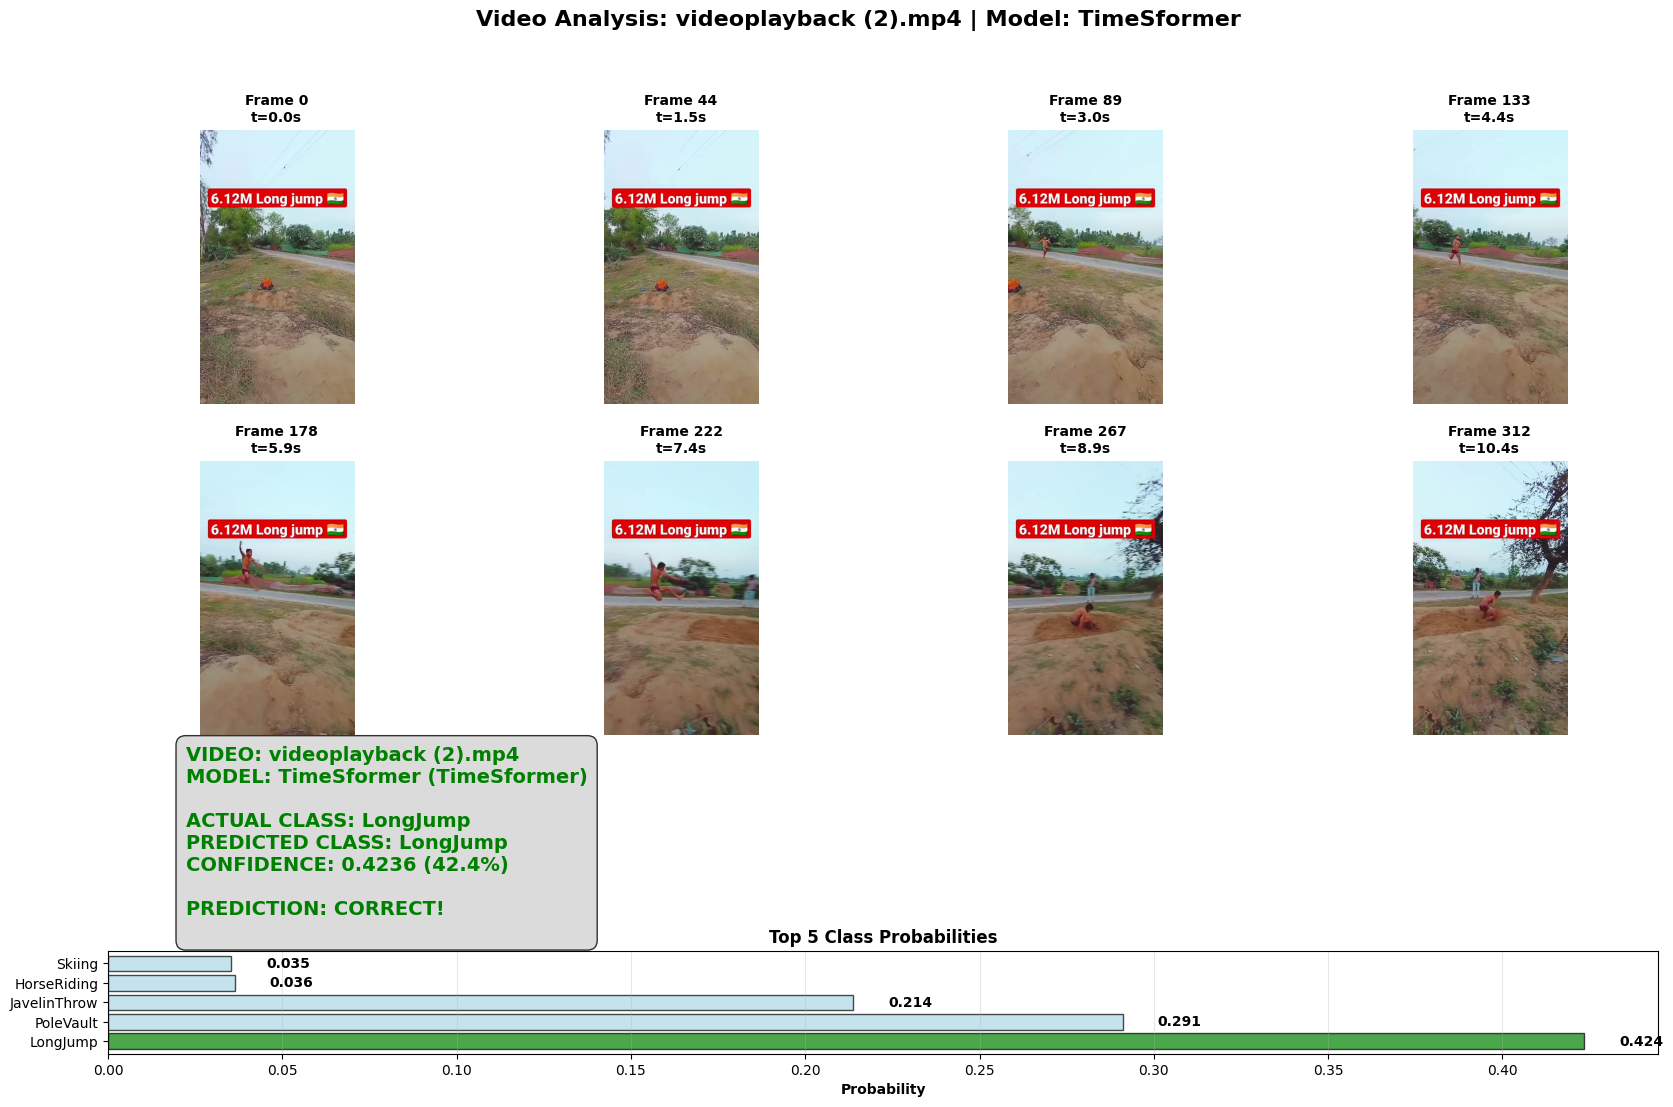


Detailed Results:
Video: videoplayback (2).mp4
Model: TimeSformer (TimeSformer)
Predicted: LongJump (Confidence: 0.4236)
Actual: LongJump
Correct: True
Frames analyzed: 8


In [ ]:
# # Define paths to your trained model weights
TIMESFORMER_WEIGHTS_PATH = "/content/drive/MyDrive/Big_vision_task_files&folders/trained_models/timesformer_model.pth"
# CUSTOM_WEIGHTS_PATH = "/content/drive/MyDrive/Big_vision_task_files&folders/trained_models/custom_video_transformer.pth"
# PRUNED_2L_WEIGHTS_PATH = "/content/drive/MyDrive/Big_vision_task_files&folders/trained_models/timesformer_removed2.pth"
# PRUNED_4L_WEIGHTS_PATH = "/content/drive/MyDrive/Big_vision_task_files&folders/trained_models/timesformer_removed4.pth"
# PRUNED_6L_WEIGHTS_PATH = "/content/drive/MyDrive/Big_vision_task_files&folders/trained_models/timesformer_removed6.pth"
# PRUNED_8L_WEIGHTS_PATH = "/content/drive/MyDrive/Big_vision_task_files&folders/trained_models/timesformer_removed8.pth"

# # OPTION 1: TimeSformer Original
model = load_model_with_detailed_analysis(num_classes=5)
weights_path = TIMESFORMER_WEIGHTS_PATH
model_name = "TimeSformer"
is_timesformer = True

# # OPTION 2: Custom Transformer
# model = load_simple_video_transformer(num_classes=len(class_names), num_frames=CONFIG['num_frames'])
# weights_path = CUSTOM_WEIGHTS_PATH
# model_name = "Custom_Transformer"
# is_timesformer = False

# # OPTION 3: Pruned TimeSformer (2 layers removed)
# model = load_model_with_layer_removal(layers_to_remove=2, num_classes=len(class_names))
# weights_path = PRUNED_2L_WEIGHTS_PATH
# model_name = "Pruned Model (10 layers)"
# is_timesformer = True

# # OPTION 4: Pruned TimeSformer (4 layers removed)
# model = load_model_with_layer_removal(layers_to_remove=4, num_classes=len(class_names))
# weights_path = PRUNED_4L_WEIGHTS_PATH
# model_name = "Pruned Model (8 layers)"
# is_timesformer = True

# # OPTION 5: Pruned TimeSformer (6 layers removed)
# model = load_model_with_layer_removal(layers_to_remove=6, num_classes=len(class_names))
# weights_path = PRUNED_6L_WEIGHTS_PATH
# model_name = "Pruned Model (6 layers)"
# is_timesformer = True

# # OPTION 6: Pruned TimeSformer (8 layers removed)
# model = load_model_with_layer_removal(layers_to_remove=8, num_classes=len(class_names))
# weights_path = PRUNED_8L_WEIGHTS_PATH
# model_name = "Heavily Pruned (4 layers)"
# is_timesformer = True

# Load the trained weights
state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)

model.to(device)

# Video path
video_path = "/content/drive/MyDrive/Big_vision_task_files&folders/Youtube_test_videos/LongJump/videoplayback (2).mp4"

# Test your video
result = predict_and_display_video(
    video_path=video_path,
    actual_class="LongJump",
    model=model,
    model_name=model_name,
    is_timesformer=is_timesformer,
    num_frames = CONFIG['num_frames']
)

# Display results
if result:
    print("\nDetailed Results:")
    print(f"Video: {os.path.basename(result['video_path'])}")
    print(f"Model: {result['model_name']} ({'TimeSformer' if result['is_timesformer'] else 'Custom Transformer'})")
    print(f"Predicted: {result['predicted_class']} (Confidence: {result['confidence']:.4f})")
    print(f"Actual: {result['actual_class']}")
    print(f"Correct: {result['is_correct']}")
    print(f"Frames analyzed: {result['frames_analyzed']}")
